In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from sklearn.preprocessing import power_transform
sns.set(style = "whitegrid",font_scale=1.4)


In [2]:
data_dir = '/Users/tessarusch/Library/CloudStorage/Box-Box/COVID-19 Adolphs Lab/core_analysis/external_selfResp_combined'
fig_dir = os.path.expanduser('~/Library/CloudStorage/Box-Box/COVID-19 Adolphs Lab/core_analysis/figures')
table_dir =  os.path.expanduser('~/Library/CloudStorage/Box-Box/COVID-19 Adolphs Lab/core_analysis/tables')

In [3]:
selfResp_data = pd.read_csv(os.path.join(data_dir, 'CVD_core_summary_scores.csv'))
extMeas_data = pd.read_csv(os.path.join(data_dir, 'externalKeyMeasures_county.csv'))
extMeas_nat_data = pd.read_csv(os.path.join(data_dir, 'externalKeyMeasures_national.csv'))

# ploting specs

In [4]:
# get color per wave for plotting 
# Get the colormap
colormap = plt.get_cmap('plasma')

# To retrieve multiple colors, you can use linspace
num_colors = len(selfResp_data.wave.unique())
wave_colors = colormap(np.linspace(0, 1, num_colors))

# column-value dicts

In [5]:
data = selfResp_data.merge(extMeas_data, on = ['PROLIFIC_PID', 'wave','week'])
data = data.merge(extMeas_nat_data, on = [ 'wave','week'])

data = data.loc[data.wave.isin([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]),:].reset_index(drop = True)

id_vars = ['week', 'wave', 'PROLIFIC_PID', 
           'ethnicity', 'race', 'polit_party','sex', 'agecats',  'education', 'age',      
           'state','county','loc_description','weekly_income_self_cat','weekly_income_self_med_num']
local_context_vars = ['cases_avg_per_100k','ueRate','restriction_sum']
personal_experience = ['mean_social_network_health','weekly_econ_impact','safety_measures']
attitude_vars = ['cvd_concern','cvd_norm_agreement', 'restrict_f1', 'restrict_f2', 'restrict_f3']
nat_vars  = ['cases_avg_per_100k_nat','ueRate_nat','restriction_sum_nat']





# reverse personal economic impact, i.e., high income --> low value, low income --> high value
data.loc[:,'weekly_econ_impact'] = data.weekly_income_self_cat_num.max()+1 - data.weekly_income_self_cat_num

# select relevant data
idx_cols = id_vars
value_cols = local_context_vars + personal_experience
data = data[id_vars+local_context_vars+personal_experience+attitude_vars+nat_vars]

# colapse sex var
data.loc[data.sex == 'Female, Female','sex'] = 'Female'
data.loc[data.sex == 'CONSENT REVOKED','sex'] = 'Prefer not to say'

# order demographic varianles var
incomecat_numeric_dict = {'<$250': 1, '$250 - $499':2, '$500 - $999':3,'$1000 -$1499':4,
                       '$1500 - $2999':5, '>$3000':6}
incomecat_cat_dict = {1:'<$250' ,2: '$250 - $499', 3:'$500 - $999',4:'$1000 -$1499',
                      5:  '$1500 - $2999', 6:'>$3000'}
data.loc[:,'incomecat_numeric'] = data['weekly_income_self_cat']
data['incomecat_numeric'].replace(incomecat_numeric_dict, inplace = True)

education_dict = {1: 'some high school', 2: 'high school',
                  3: 'some college', 4: "Associate's degree", 
                  5: "Bachelor's degree", 6: 'some graduate education',
                  7: "Master's degree", 8: 'PhD', 
                  9: "Professional degree", 10: 'other'}
data['education_numeric'] = data['education']
data['education_numeric'] = data['education_numeric'].replace(education_dict)


location_dict = {'countryside_remote': 0, 'countryside_near_town': 1,
               'suburb_small_city': 2,'middle_small_city':3,
               'suburb_med_city': 4,'middle_med_city':5,
               'suburb_large_city':6,'middle_large_city_spread':7, 'middle_large_city_dense':8 }
location_dict_label = {0:'countryside\nremote', 1: 'countryside\nnear town',
                 2: 'suburb\nsmall city',3: 'middle\nsmall city',
                 4: 'suburb\nmed city',5: 'middle\nmed city',
                 6: 'suburb\nlargecity',7:'middle large city\nspread housing',8: 'middle large city\ndense housing'}
data['loc_numeric'] = data['loc_description']
data['loc_numeric'] = data['loc_description'].replace(location_dict)



# subject count per wave

In [6]:
# drop duplicates
data = data.drop_duplicates().reset_index(drop=True)


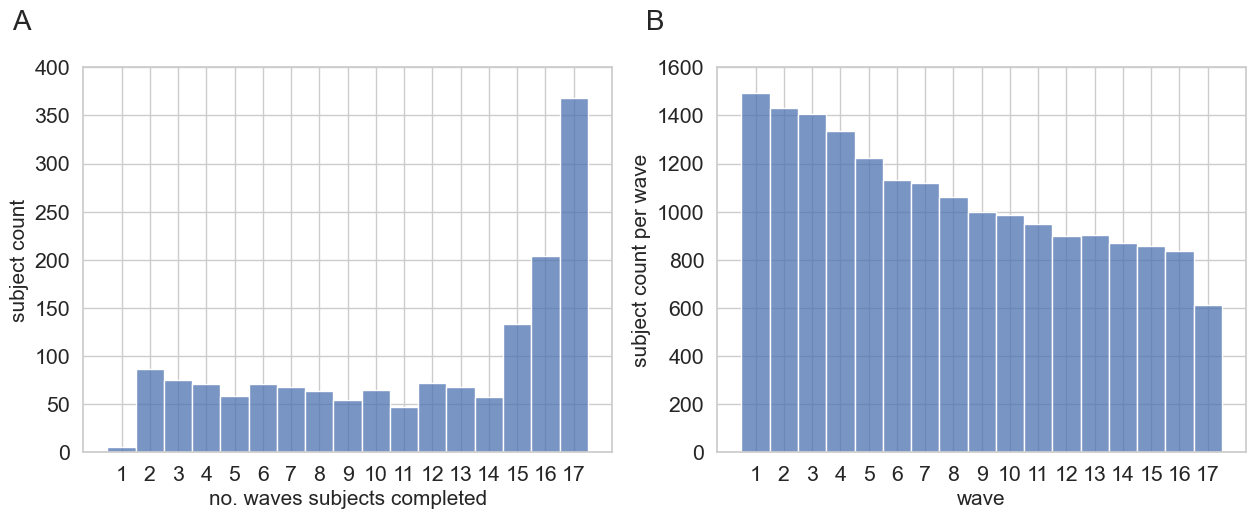

In [7]:
fig, ax = plt.subplots(1,2,figsize = (15,5))

# number of waves completed
sns.histplot(data.PROLIFIC_PID.value_counts(),ax = ax[0], bins = 17, discrete = True)
ax[0].set_xlabel('no. waves subjects completed', fontsize = 15)
ax[0].set_ylabel('subject count', fontsize = 15)
ax[0].set_ylim(0,400)
ax[0].set_xticks(data.wave.unique());
ax[0].set()

# subject count per wave
sns.histplot(data, x = 'wave', ax = ax[1], bins = 17, discrete = True)
ax[1].set_xticks(data.wave.unique());
ax[1].set_xlabel('wave', fontsize = 15)
ax[1].set_ylabel('subject count per wave', fontsize = 15)
ax[1].set_ylim(0,1600)

# add panel label
for i, label in enumerate(['A', 'B']):
    ax[i].text(-0.1, 1.15, label, transform=ax[i].transAxes,
               fontsize=20, va='top', ha='right')
    
img_format = 'png'
fig.savefig(os.path.join(fig_dir, 'subject_wave_counts.' + img_format), format=img_format)


# Drop Subjects with less than 10 waves

In [8]:
# drop subjects with less than 10 waves
pid_include = data.PROLIFIC_PID.value_counts().index[data.PROLIFIC_PID.value_counts()>9]
data = data.loc[data.PROLIFIC_PID.isin(pid_include)]


# Demographics 

In [9]:
w3_data = data.loc[data.wave==3,:].copy()
w3_data.education = w3_data.education.replace(education_dict)

print('sex')
print(w3_data.sex.value_counts()/len(w3_data)*100)

print('\n age median')
print(w3_data.age.median())
print('age min')
print(w3_data.age.min())
print('age max')
print(w3_data.age.max())

print('\n polit affil')
print(w3_data.polit_party.value_counts()/len(w3_data)*100)

print('\n race')
print(w3_data.race.value_counts()/len(w3_data)*100)

print('\n ethnicity')
print(w3_data.ethnicity.value_counts()/len(w3_data)*100)

print('\n weekly income self')
print(w3_data.weekly_income_self_cat.value_counts()/len(w3_data)*100)

print('\n education')
print(w3_data.education.value_counts()/len(w3_data)*100)

sex
Female               50.403226
Male                 49.193548
Prefer not to say     0.403226
Name: sex, dtype: float64

 age median
39.0
age min
18.0
age max
77.0

 polit affil
Democrat       53.427419
Independent    28.931452
Republican     14.818548
Other           2.822581
Name: polit_party, dtype: float64

 race
White                                        77.016129
Asian                                         9.778226
Black or African American                     7.056452
Multiracial                                   3.830645
Other                                         1.411290
Prefer not to disclose                        0.504032
American Indian/Alaska Native                 0.302419
Native Hawaiian or Other Pacific Islander     0.100806
Name: race, dtype: float64

 ethnicity
Not Hispanic or Latino     90.423387
Hispanic or Latino          8.971774
 Prefer not to disclose     0.604839
Name: ethnicity, dtype: float64

 weekly income self
<$250            41.431452
$250 - $

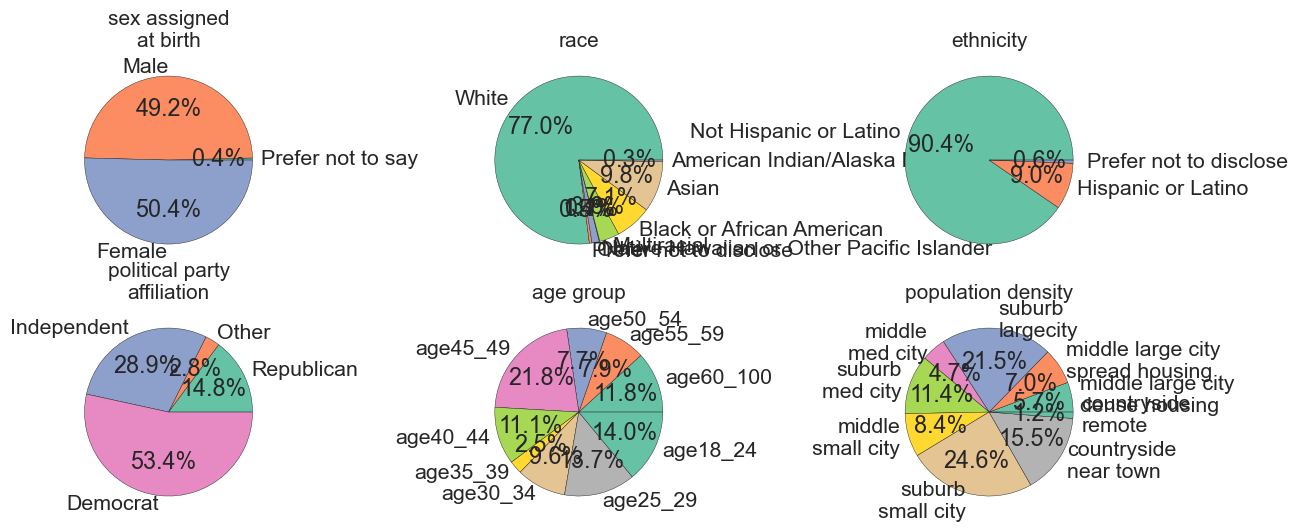

In [10]:
# Demographic pie charts

titles = ['sex assigned\nat birth', 'race', 'ethnicity',
          'political party\naffiliation', 'age group', 'population density']

fig, ax = plt.subplots(2,3, figsize = (15,6))
for idx, dem_var in enumerate(['sex', 'race', 'ethnicity',
                               'polit_party','agecats', 'loc_numeric']):
    row = 0
    if idx>2:
        row = 1
    col = idx%3
    
    data = data.sort_values(by=[dem_var])
    
    labels = data.loc[data.wave ==3,dem_var].value_counts().sort_index(ascending=False).index
    # semanitc labels
    if dem_var == 'education':
        labels = pd.Series(labels).replace(education_dict).values
    if dem_var == 'incomecat_numeric':
        labels = pd.Series(labels).replace(incomecat_cat_dict).values
    if dem_var == 'incomecat_numeric':
        labels = pd.Series(labels).replace(incomecat_cat_dict).values
    if dem_var == 'loc_numeric':
        labels = pd.Series(labels).replace(location_dict_label).values
    
        

        
    values = data.loc[data.wave ==3,dem_var].value_counts().sort_index(ascending=False)
    ax[row,col].pie(values,
                autopct='%1.1f%%',
                labels=labels,
                colors=sns.color_palette('Set2'),
                wedgeprops={"edgecolor":"k",'linewidth': 0.3,  'antialiased': True});
    ax[row,col].set_title(titles[idx], fontsize = 15);
    
    
    
img_format = 'svg'
fig.savefig(os.path.join(fig_dir, 'demographics_.' + img_format), format=img_format)


In [11]:
#### combine demographic groups that are too small (<5%) #######
# age group: 35-39 & 30-34
data.agecats = data.agecats.replace({'age30_34': 'age30_39', 
                                     'age35_39': 'age30_39'})
# population denisty: countryside remote & countryside near twon
data.loc_description = data.loc_description.replace({'countryside_remote': 'countryside', 
                                                     'countryside_near_town': 'countryside'})

# for other demographic variables, drop the categories that are <5%,i.e., 
# Sex: prefer not to say
data = data.loc[data.sex!='Prefer not to say',:]
# race: Multiracial, Other, Prefer not to disclose, American Indian/Alaska Native,Native Hawaiian or Other Pacific Islander 
data = data.loc[~data.race.isin(['Multiracial', 'Other', 'Prefer not to disclose',
                                 'American Indian/Alaska Native','Native Hawaiian or Other Pacific Islander']),:]
# ethnicity: prefer not to disclose
data = data.loc[data.ethnicity!=' Prefer not to disclose',:]
# political party: other
data.polit_party = data.polit_party.replace({'Other': 'Independent'})


# adapt id-dicts
location_dict = {'countryside':0,
               'suburb_small_city': 1,'middle_small_city':2,
               'suburb_med_city': 3,'middle_med_city':4,
               'suburb_large_city':5,'middle_large_city_spread':6, 'middle_large_city_dense':7 }
location_dict_label = {0:'countryside',1: 'suburb\nsmall city',2: 'middle\nsmall city',
                 3: 'suburb\nmed city',4: 'middle\nmed city',
                 5: 'suburb\nlargecity',6:'middle large city\nspread housing',7: 'middle large city\ndense housing'}
data['loc_numeric'] = data['loc_description']
data['loc_numeric'] = data['loc_description'].replace(location_dict)

agecat_numeric_dict = {'age18_24': 1, 'age25_29':2, 'age30_39':3,
                       'age40_44':4, 'age45_49':5, 'age50_54':6, 
                       'age55_59': 7, 'age60_100':8}


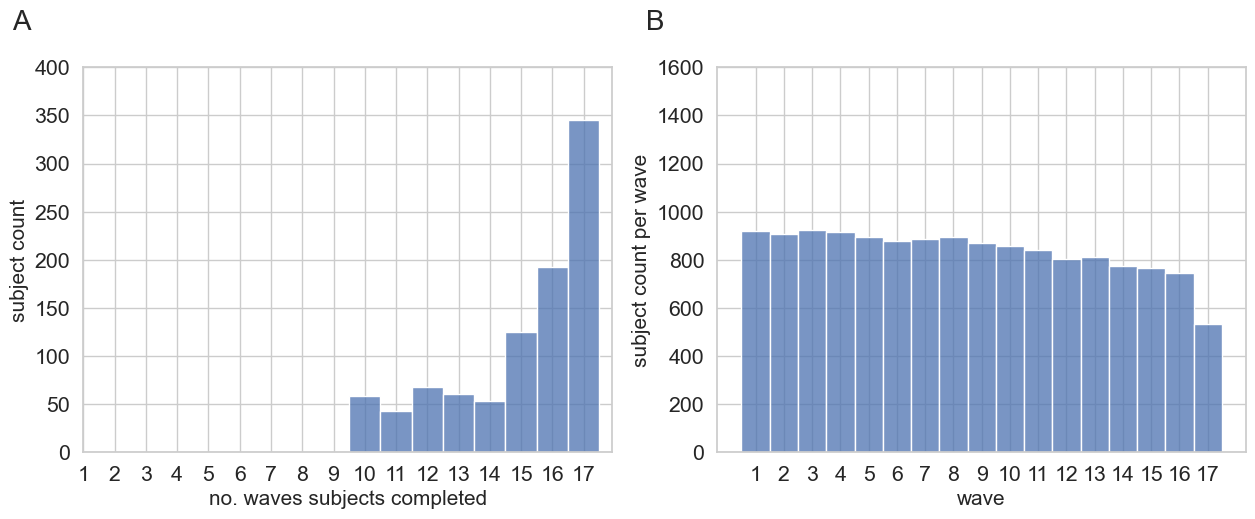

In [12]:
fig, ax = plt.subplots(1,2,figsize = (15,5))

# number of waves completed
sns.histplot(data.PROLIFIC_PID.value_counts(),ax = ax[0], bins = 17, discrete = True)
ax[0].set_xlabel('no. waves subjects completed', fontsize = 15)
ax[0].set_ylabel('subject count', fontsize = 15)
ax[0].set_ylim(0,400)
ax[0].set_xticks(data.wave.unique());
ax[0].set()

# subject count per wave
sns.histplot(data, x = 'wave', ax = ax[1], bins = 17, discrete = True)
ax[1].set_xticks(data.wave.unique());
ax[1].set_xlabel('wave', fontsize = 15)
ax[1].set_ylabel('subject count per wave', fontsize = 15)
ax[1].set_ylim(0,1600)

# add panel label
for i, label in enumerate(['A', 'B']):
    ax[i].text(-0.1, 1.15, label, transform=ax[i].transAxes,
               fontsize=20, va='top', ha='right')
    
img_format = 'png'
fig.savefig(os.path.join(fig_dir, 'subject_wave_counts.' + img_format), format=img_format)


# transformations

## yeo-johnson

In [13]:
data['cases_avg_per_100k_yeojohnson'] = power_transform(data['cases_avg_per_100k'].values.reshape(-1, 1), method='yeo-johnson')
data['restriction_sum_yeojohnson'] = power_transform(data['restriction_sum'].values.reshape(-1, 1), method='yeo-johnson')
data['ueRate_yeojohnson'] = power_transform(data['ueRate'].values.reshape(-1, 1), method='yeo-johnson')

data['mean_social_network_health_yeojohnson'] = power_transform(data['mean_social_network_health'].values.reshape(-1, 1), method='yeo-johnson')
data['weekly_econ_impact_yeojohnson'] = power_transform(data['weekly_econ_impact'].values.reshape(-1, 1), method='yeo-johnson')
data['safety_measures_yeojohnson'] = power_transform(data['safety_measures'].values.reshape(-1, 1), method='yeo-johnson')

for w in data.wave.unique():
    data.loc[data.wave == w,'cases_avg_per_100k_yeojohnson_w_by_w'] = power_transform(data.loc[data.wave == w,'cases_avg_per_100k'].values.reshape(-1, 1), method='yeo-johnson')
    data.loc[data.wave == w,'restriction_sum_yeojohnson_w_by_w'] = power_transform(data.loc[data.wave == w,'restriction_sum'].values.reshape(-1, 1), method='yeo-johnson')
    data.loc[data.wave == w,'ueRate_yeojohnson_w_by_w'] = power_transform(data.loc[data.wave == w,'ueRate'].values.reshape(-1, 1), method='yeo-johnson')

    data.loc[data.wave == w,'mean_social_network_health_yeojohnson_w_by_w'] = power_transform(data.loc[data.wave == w,'mean_social_network_health'].values.reshape(-1, 1), method='yeo-johnson')
    data.loc[data.wave == w,'weekly_econ_impact_yeojohnson_w_by_w'] = power_transform(data.loc[data.wave == w,'weekly_econ_impact'].values.reshape(-1, 1), method='yeo-johnson')
    data.loc[data.wave == w,'safety_measures_yeojohnson_w_by_w'] = power_transform(data.loc[data.wave == w,'safety_measures'].values.reshape(-1, 1), method='yeo-johnson')


## z-score and yeojohnson transform

In [14]:
from scipy import stats
def safe_z_score(x):
    std = x.std()
    if std == 0:
        return x * 0  # or return np.zeros_like(x)
    else:
        return (x - x.mean()) / std

def apply_yeojohnson(x):
    print(x)
    # Adding a check to ensure there is variance in the data
    if ~np.all(x.values == x.values[0]):
        # Adding a check to ensure there are no non-positive values
        if any(x <= 0):
            # Handling non-positive data is necessary before applying Box-Cox
            # This could be done by shifting the data to be strictly positive
            # Here, add a small constant (1 - min(x)) if min(x) is less or equal to 0
            x = x + (1 - x.min())
        # Apply Box-Cox transform
        x_transformed= power_transform(x.values.reshape(-1, 1), method='yeo-johnson').reshape(1, -1) 
        print(x_transformed)

    else:
        x_transformed = x.values
        
    return x_transformed    

In [15]:
data[value_cols+ attitude_vars] = data[value_cols + attitude_vars].apply(pd.to_numeric,axis=1) 

# additional variables to z-score
data.loc[:,'age_zscore'] = data['age']
additional_vars = ['age_zscore', 
                   'cvd_concern_yeojohnson','cvd_norm_agreement_yeojohnson',
                   'restrict_f1_yeojohnson', 'restrict_f2_yeojohnson']

# columns to z-score
z_score_cols = value_cols + nat_vars +attitude_vars +['age_zscore']

# subject level z-score 
data_sub_zscore = data[idx_cols + z_score_cols].copy()

#across subjects and waves  z-score 
data_zscore = data[idx_cols + z_score_cols].copy()
data_zscore.loc[:,'cvd_concern_yeojohnson'] =  power_transform(data_zscore['safety_measures'].values.reshape(-1, 1), method='yeo-johnson')
data_zscore.loc[:,'restrict_f1_yeojohnson'] = power_transform(data_zscore['restrict_f1'].values.reshape(-1, 1), method='yeo-johnson')
data_zscore.loc[~data_zscore.restrict_f2.isna(),'restrict_f2_yeojohnson'] = power_transform(data_zscore.loc[~data_zscore.restrict_f2.isna(),'restrict_f2'].values.reshape(-1, 1), method='yeo-johnson')
data_zscore.loc[:,'cvd_norm_agreement_yeojohnson'] = power_transform(data_zscore['cvd_norm_agreement'].values.reshape(-1, 1), method='yeo-johnson')

z_score_cols = z_score_cols+additional_vars
for col in z_score_cols:
    data_zscore[col] = data_zscore[col].transform(safe_z_score)        
    

# variable overview

## raw values

### local_context_vars

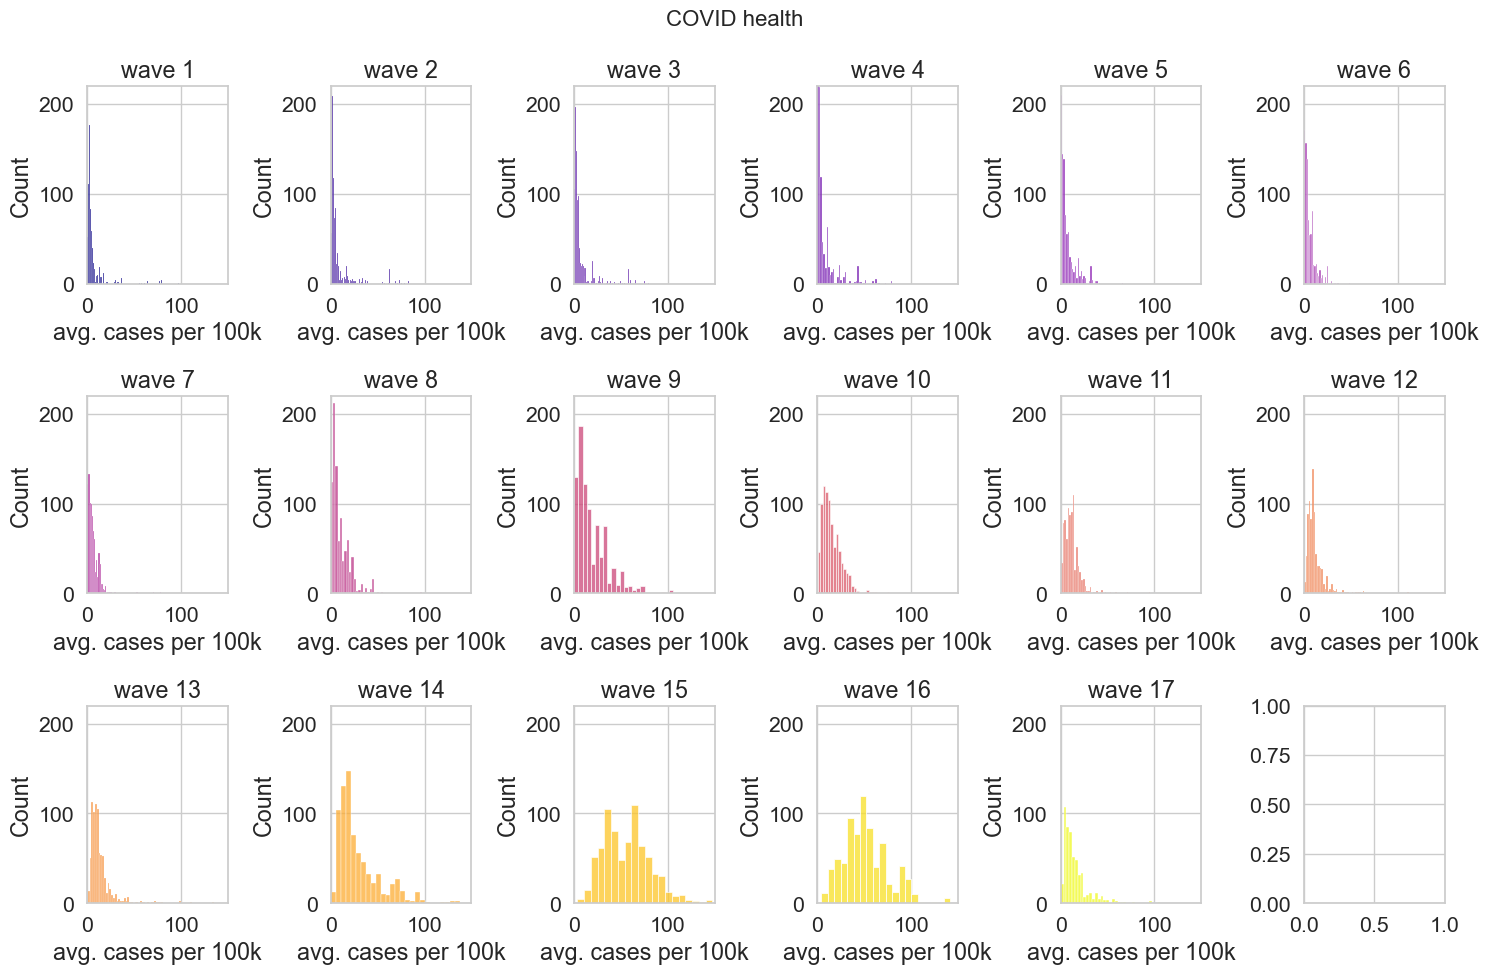

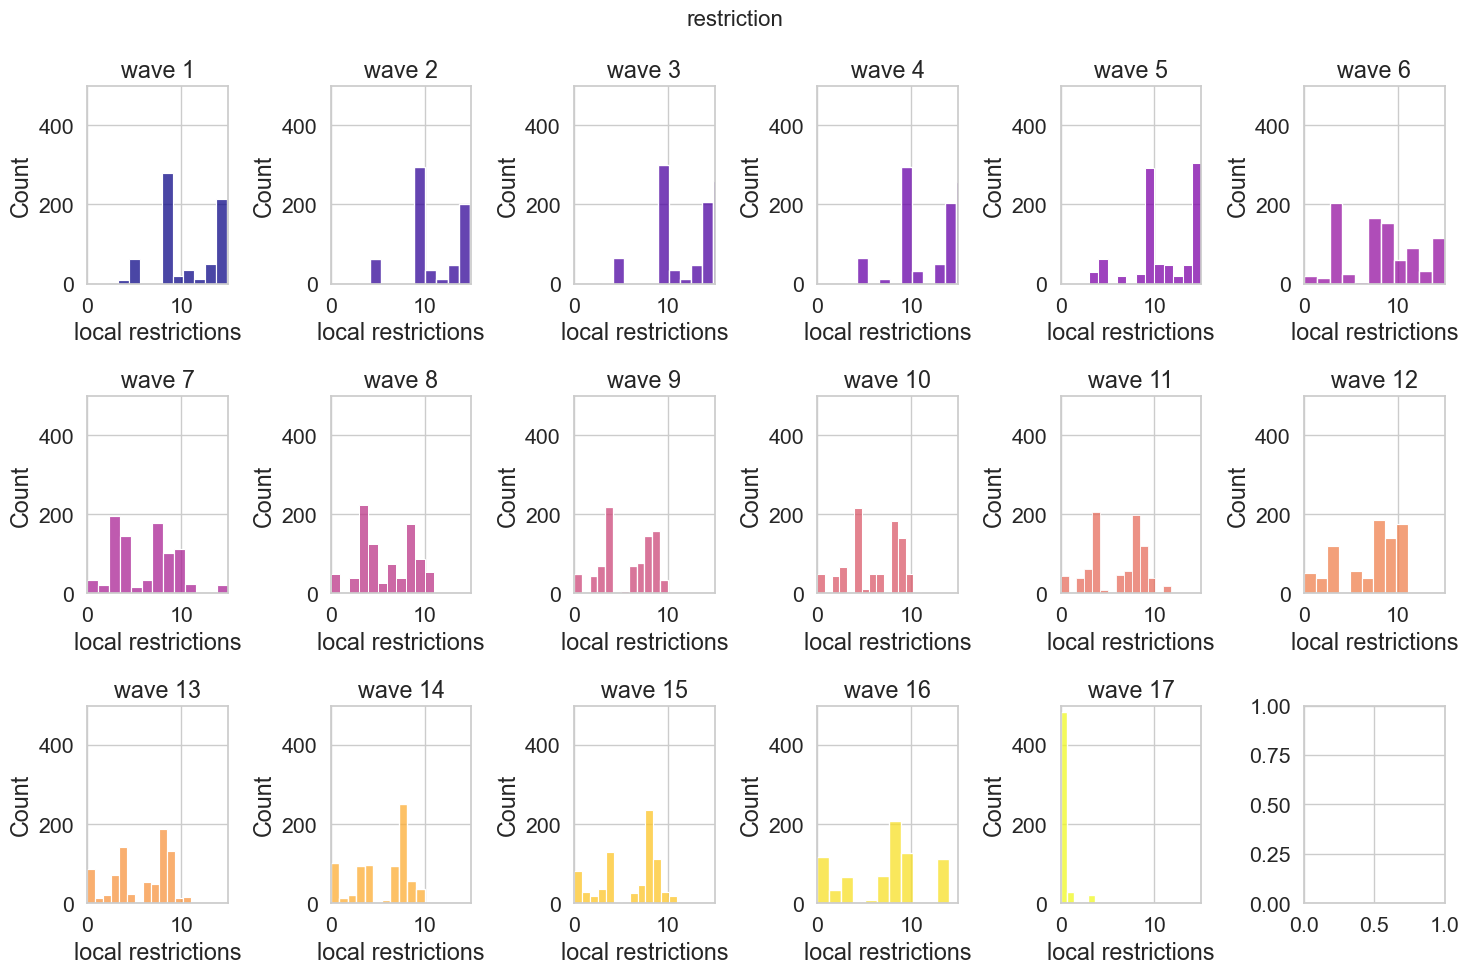

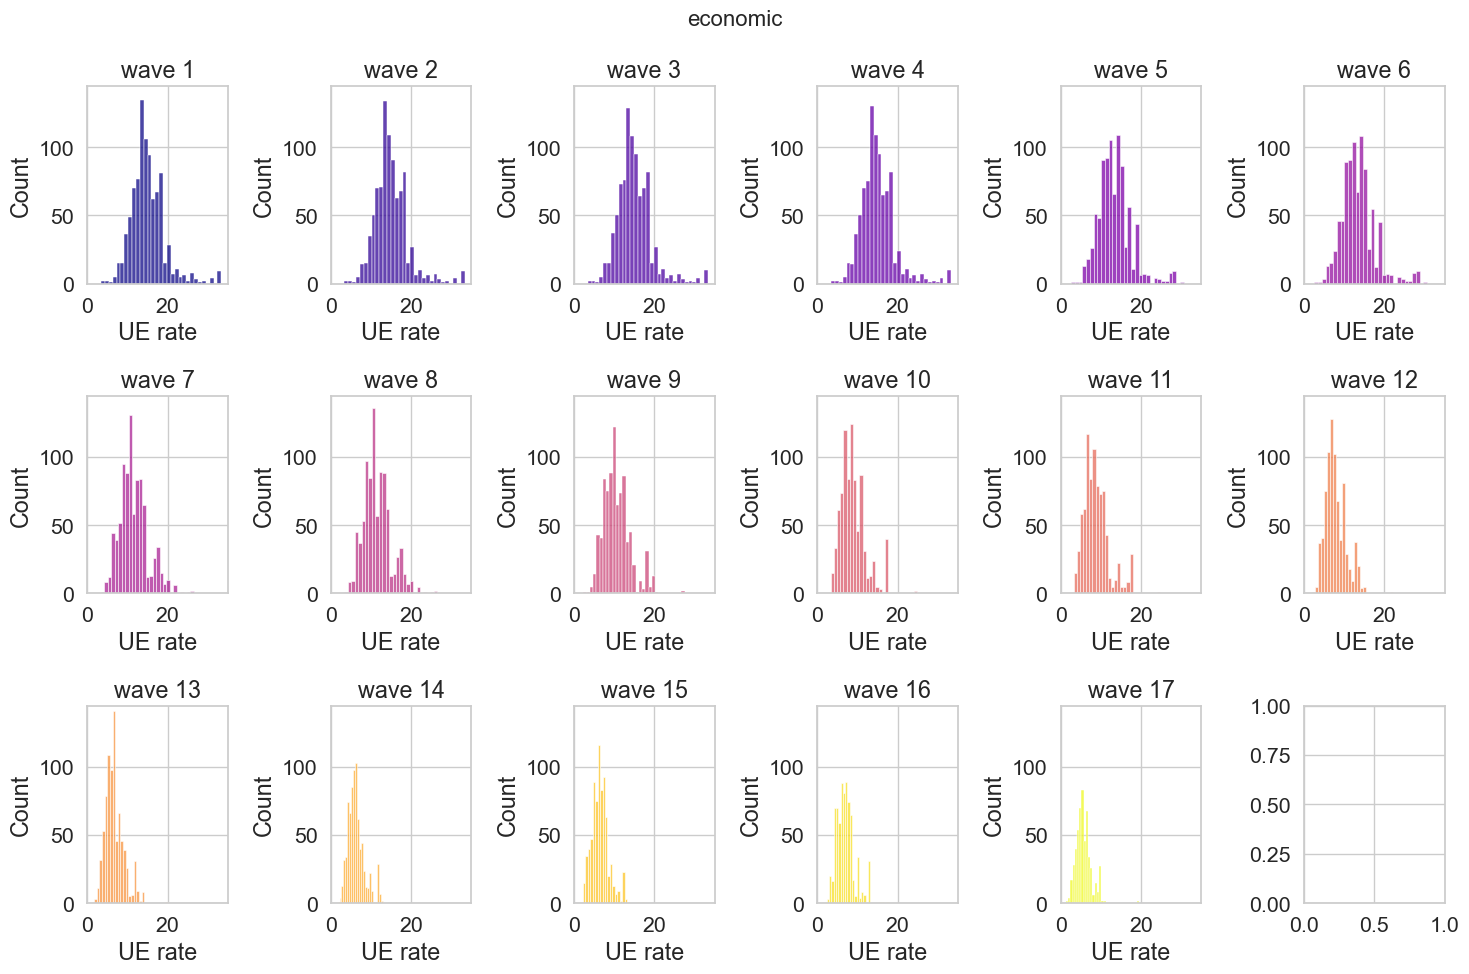

In [16]:
local_context_vars = ['cases_avg_per_100k','restriction_sum','ueRate']
# personal_experience = ['mean_social_network_health','weekly_econ_impact',
#                        'safety_measures']
# attitude_vars = ['cvd_concern','cvd_norm_agreement', 'restrict_f1', 'restrict_f2', 'restrict_f3']

var_label= ['COVID health', 'restriction', 'economic']
x_label = ['avg. cases per 100k', 'local restrictions', 'UE rate']
x_lim = [[0,150], [0,15], [0,35]]
y_lim = [[0,220], [0,500], [0,145]]

for j, var in enumerate(local_context_vars):
    fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(15,10))
    fig.suptitle(var_label[j], fontsize=16)

    for i, ax in enumerate(axs.flatten()):
        if i <data.wave.max():
            sns.histplot(data.loc[data.wave == i+1, var], ax = ax, color = wave_colors[i])
            ax.set_title("wave " + str(i+1))
            ax.set_xlabel(x_label[j])
            ax.set_xlim(x_lim[j])
            ax.set_ylim(y_lim[j])

    plt.tight_layout()
    fig.savefig(os.path.join(fig_dir,'raw_' +var+ '.png'), dpi=600)


### personal experience

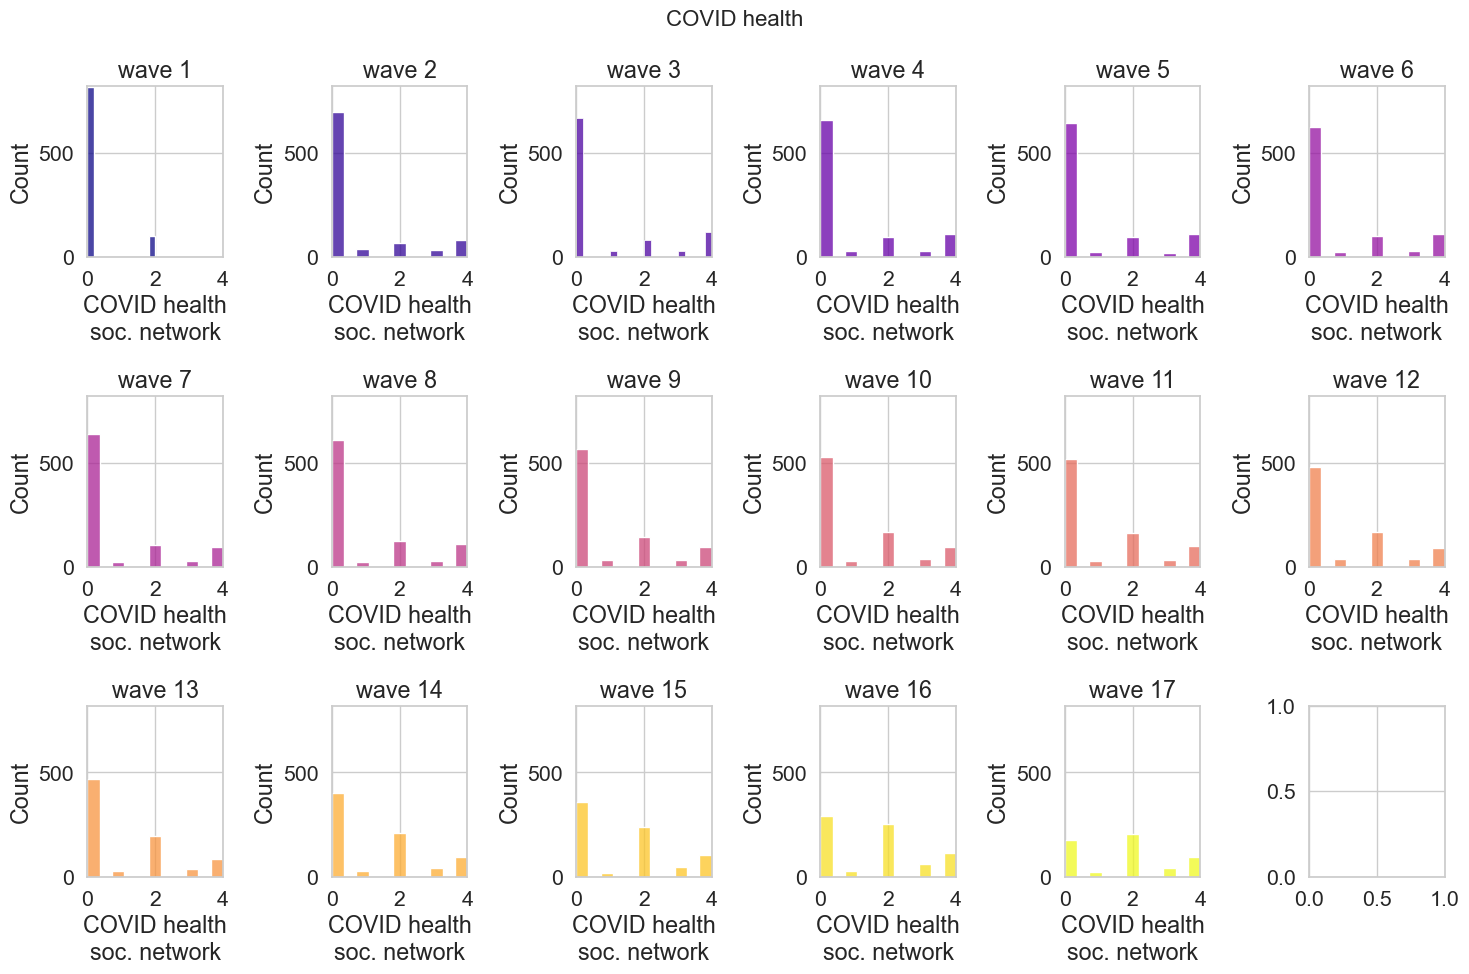

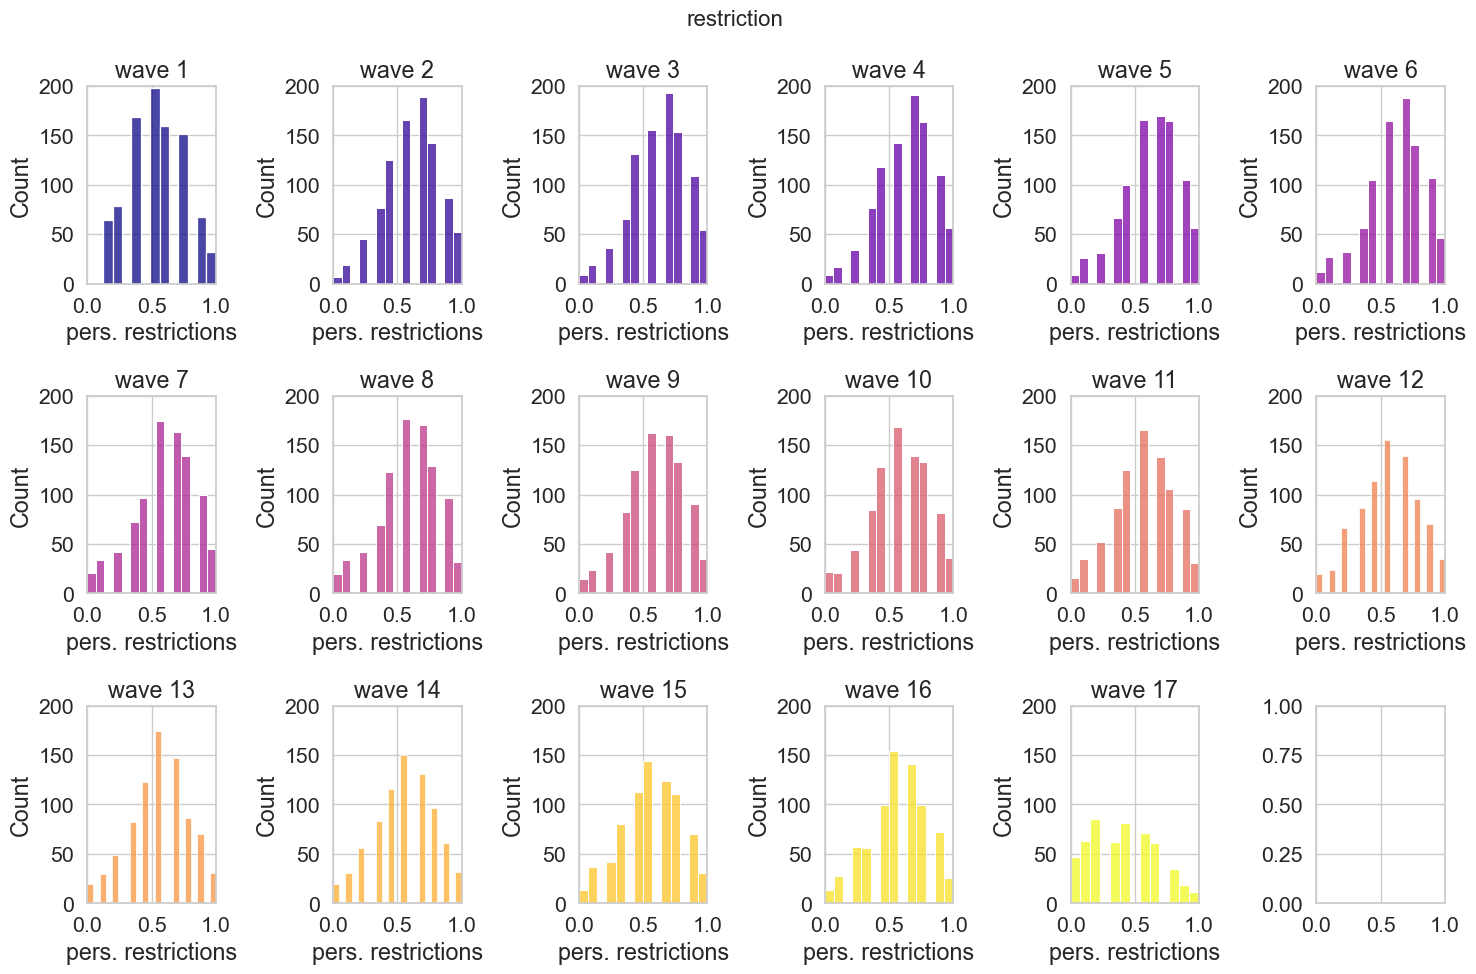

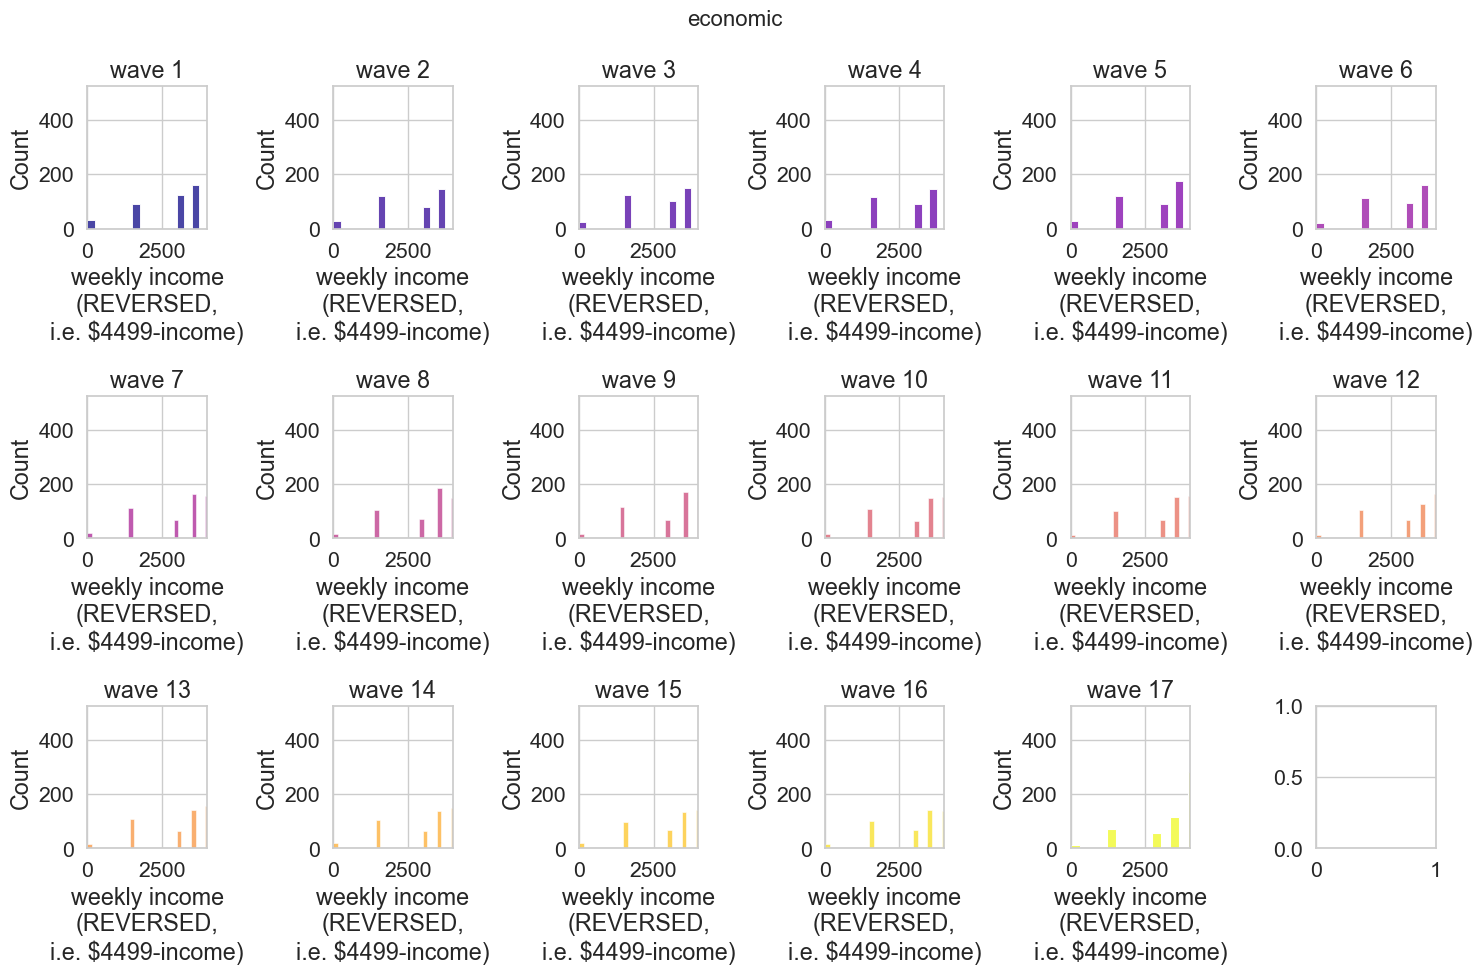

In [17]:
personal_experience = ['mean_social_network_health','safety_measures','weekly_econ_impact']
# attitude_vars = ['cvd_concern','cvd_norm_agreement', 'restrict_f1', 'restrict_f2', 'restrict_f3']

var_label= ['COVID health', 'restriction', 'economic']
x_label = ["COVID health\nsoc. network", 'pers. restrictions', "weekly income\n(REVERSED,\ni.e. $4499-income)"]
x_lim = [[0,4], [0,1], [0,4000]]
y_lim = [[0,820], [0,200], [0,525]]


for j, var in enumerate(personal_experience):
    fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(15,10))
    fig.suptitle(var_label[j], fontsize=16)

    for i, ax in enumerate(axs.flatten()):
        if i <data.wave.max():
            sns.histplot(data.loc[data.wave == i+1, var], ax = ax, color = wave_colors[i])
            ax.set_title("wave " + str(i+1))
            ax.set_xlabel(x_label[j])
            ax.set_xlim(x_lim[j])
            ax.set_ylim(y_lim[j])

    plt.tight_layout()
    fig.savefig(os.path.join(fig_dir,'raw_' +var+ '.png'), dpi=600)

### attitudes

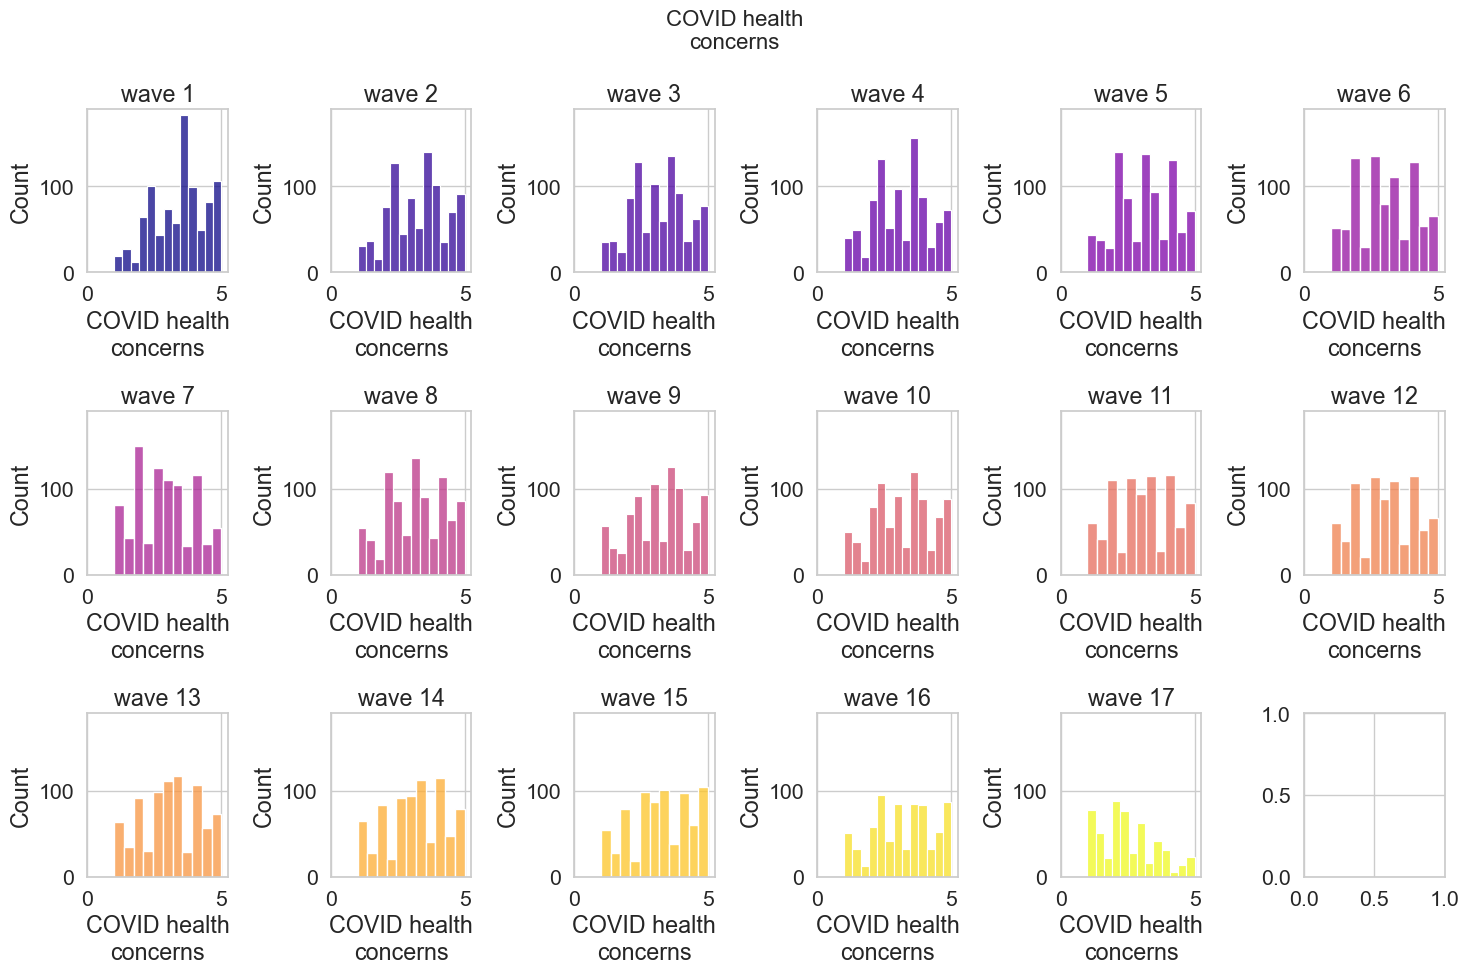

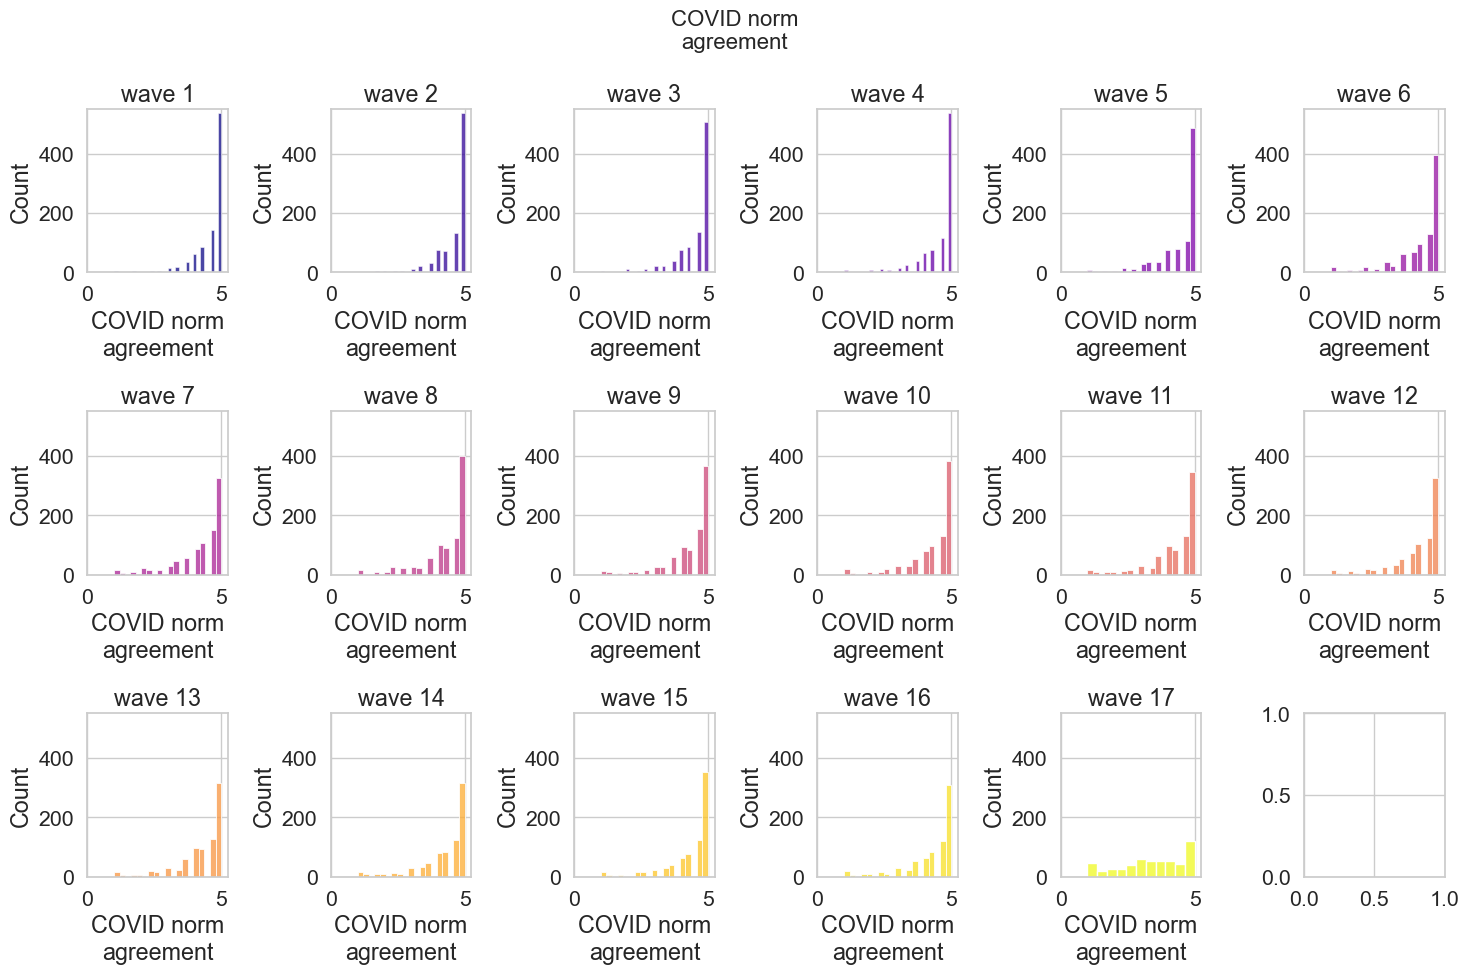

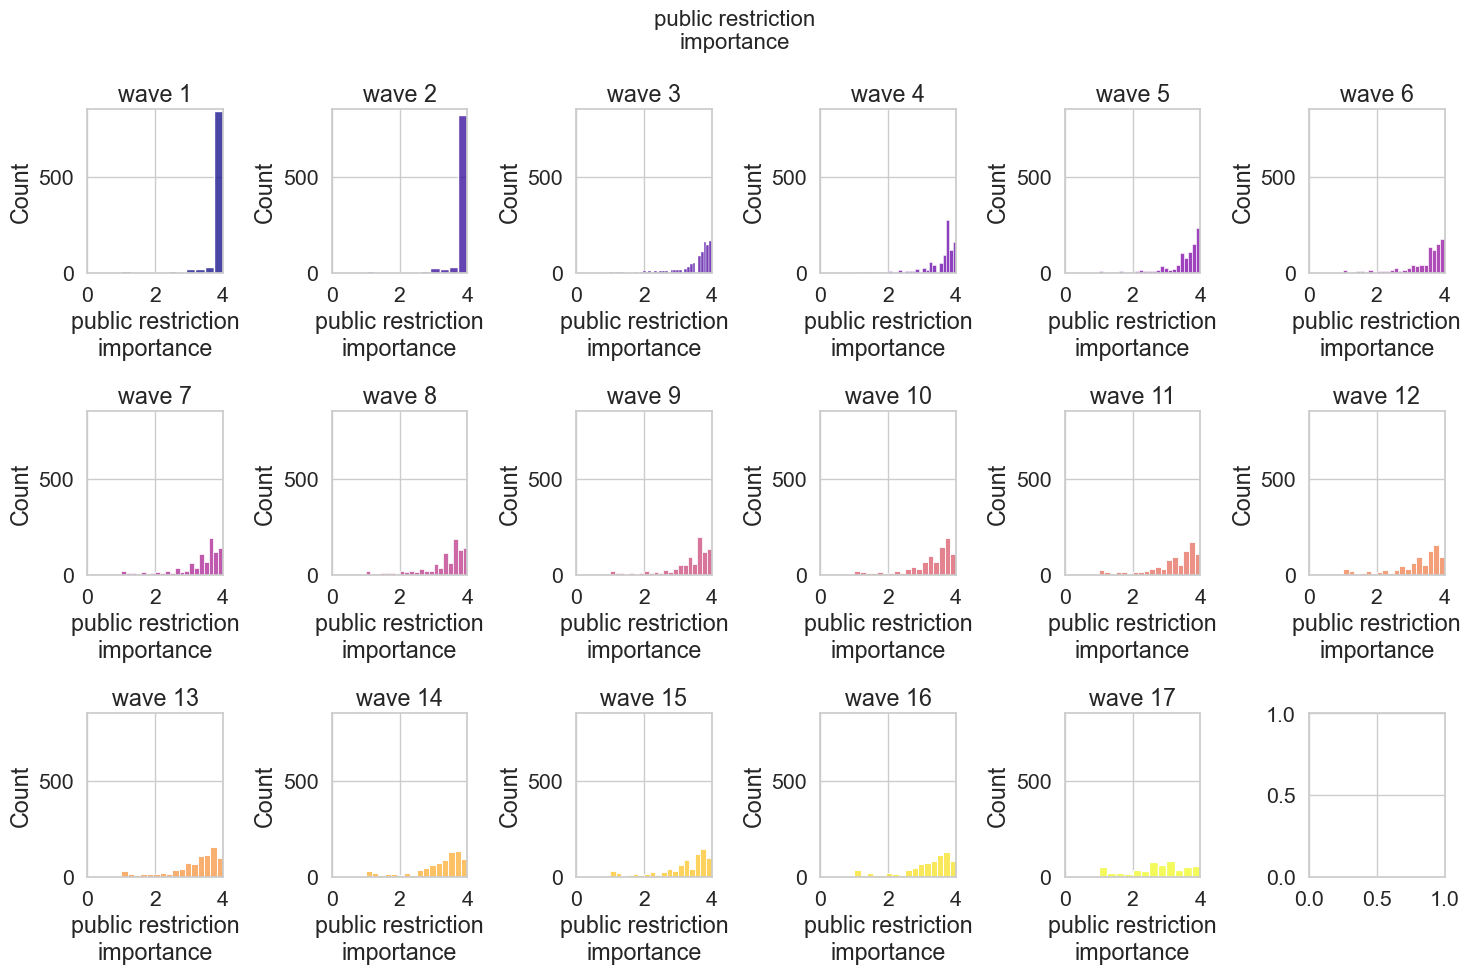

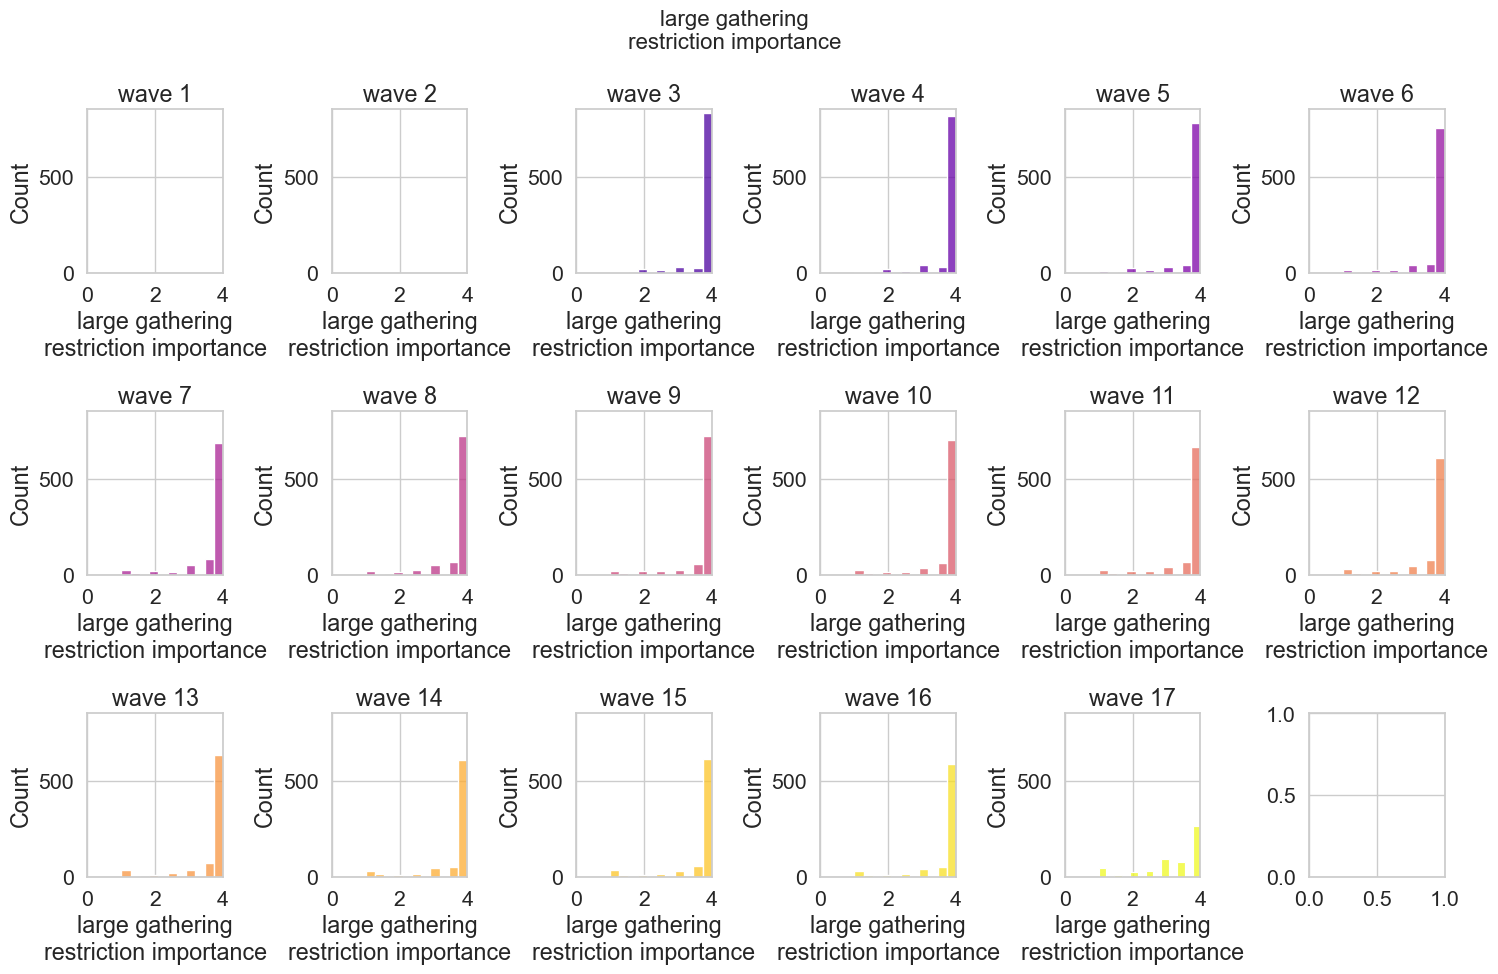

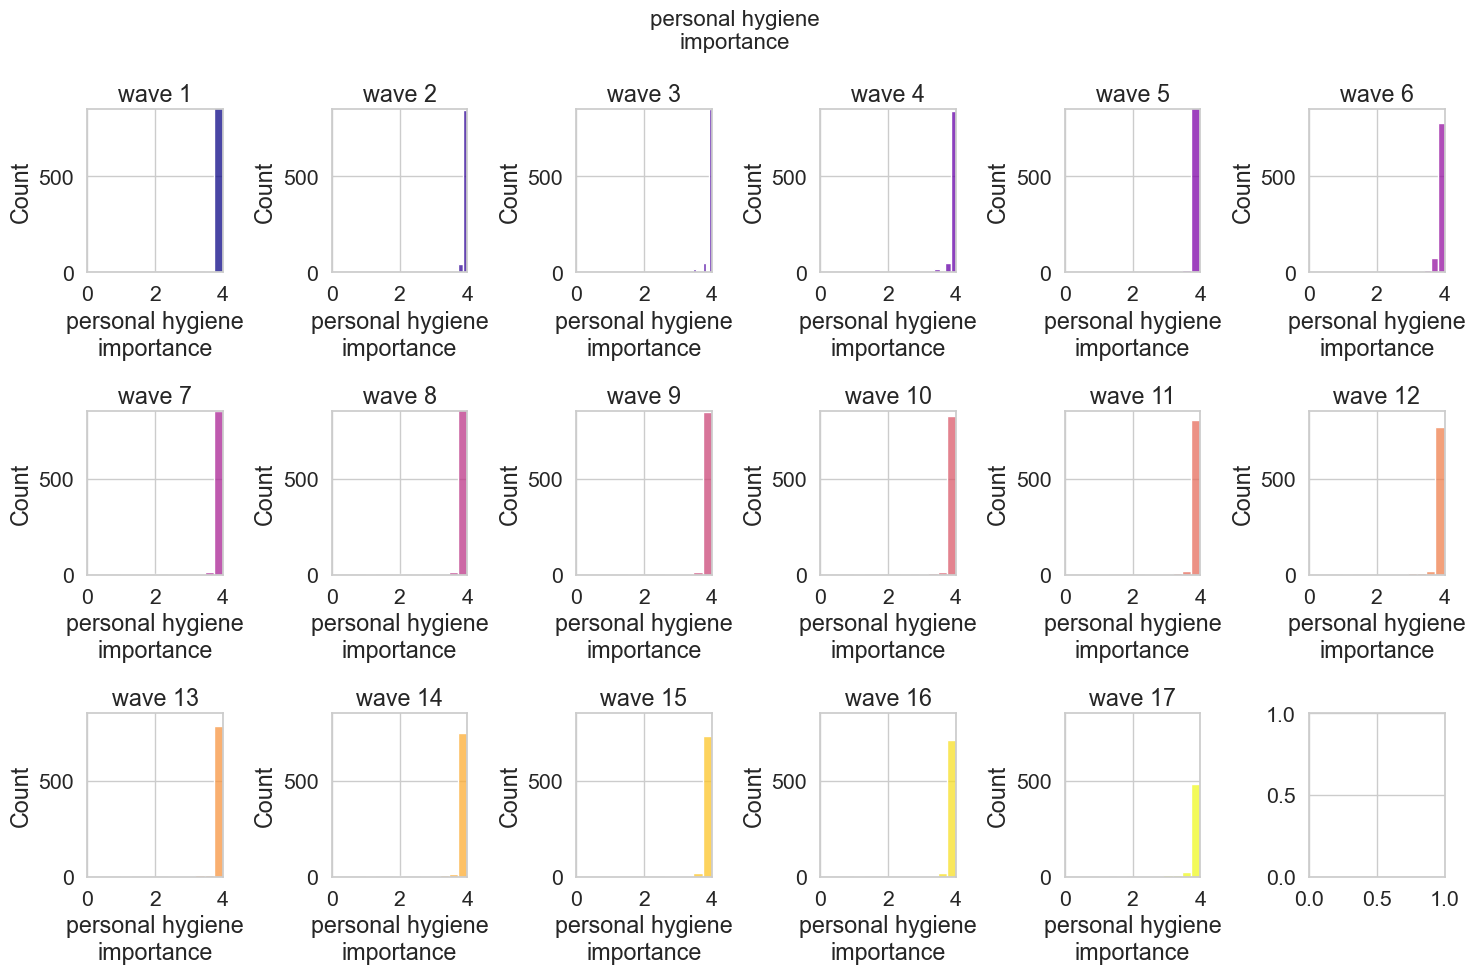

In [18]:
attitude_vars = ['cvd_concern','cvd_norm_agreement', 'restrict_f1', 'restrict_f2', 'restrict_f3']

var_label= ['COVID health\nconcerns', 'COVID norm\nagreement', 
           'public restriction\nimportance', 'large gathering\nrestriction importance', 'personal hygiene\nimportance']

x_label = var_label
x_lim = [[0,5.25], [0,5.25], [0,4],[0,4],[0,4]]
y_lim = [[0,190], [0,550], [0,850],[0,850],[0,850]]


for j, var in enumerate(attitude_vars):
    fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(15,10))
    fig.suptitle(var_label[j], fontsize=16)

    for i, ax in enumerate(axs.flatten()):
        if i <data.wave.max():
            sns.histplot(data.loc[data.wave == i+1, var], ax = ax, color = wave_colors[i])
            ax.set_title("wave " + str(i+1))
            ax.set_xlabel(x_label[j])
            ax.set_xlim(x_lim[j])
            ax.set_ylim(y_lim[j])

    plt.tight_layout()
    fig.savefig(os.path.join(fig_dir,'raw_' +var+ '.png'), dpi=600)

# multicolinearity 

## chi-square test to test vor co-variace between categorical demographic variables 

In [19]:
from scipy.stats import chi2_contingency

dataW3 = data.loc[data.wave == 3,['PROLIFIC_PID','ethnicity','race',
                                  'polit_party','sex','agecats', 'loc_description']].reset_index(drop = True)

# Create crosstabulations and perform chi-square tests for all pairs of demographic variables
categorical_vars = ['race','polit_party','sex','agecats','ethnicity','loc_description']

p_vals = pd.DataFrame(columns = categorical_vars, index = categorical_vars)

for i in range(len(categorical_vars)):
    for j in range(i + 1, len(categorical_vars)):
        var1 = categorical_vars[i]
        var2 = categorical_vars[j]
        
        # Create a crosstabulation (contingency table)
        cross_tab = pd.crosstab(dataW3[var1], dataW3[var2])
        
        # Print the names of the variables being tested
        print(f"\nChi-Square Test between {var1} and {var2}:")
        
        # Print the contingency table
        print("Contingency Table:")
        print(cross_tab)
        
        # Perform the chi-square test of independence
        chi2, p, dof, expected = chi2_contingency(cross_tab)
        p_vals.loc[categorical_vars[i], categorical_vars[j]] = p
        p_vals.loc[categorical_vars[j],categorical_vars[i]] = p

        # Print the chi-square statistic, p-value, degrees of freedom, and expected frequencies
        print("\nChi-Square Statistic:", chi2)
        print("P-Value:", p)
        print("Degrees of Freedom:", dof)
        
        cross_tab.loc['Chi-Square Statistic','stats'] = chi2
        cross_tab.loc['P-Value','stats'] = p
        cross_tab.loc['Degrees of Freedom','stats'] = dof
        
        cross_tab.to_csv(os.path.join(table_dir,'chi_square_test_' + var1 + '_' + var2 + '.csv'))


Chi-Square Test between race and polit_party:
Contingency Table:
polit_party                Democrat  Independent  Republican
race                                                        
Asian                            61           23          11
Black or African American        48           21           1
White                           385          247         127

Chi-Square Statistic: 18.843641333198157
P-Value: 0.0008435267718679404
Degrees of Freedom: 4

Chi-Square Test between race and sex:
Contingency Table:
sex                        Female  Male
race                                   
Asian                          41    54
Black or African American      41    29
White                         389   370

Chi-Square Statistic: 3.9625704567621036
P-Value: 0.1378919007919248
Degrees of Freedom: 2

Chi-Square Test between race and agecats:
Contingency Table:
agecats                    age18_24  age25_29  age30_39  age40_44  age45_49  \
race                                       

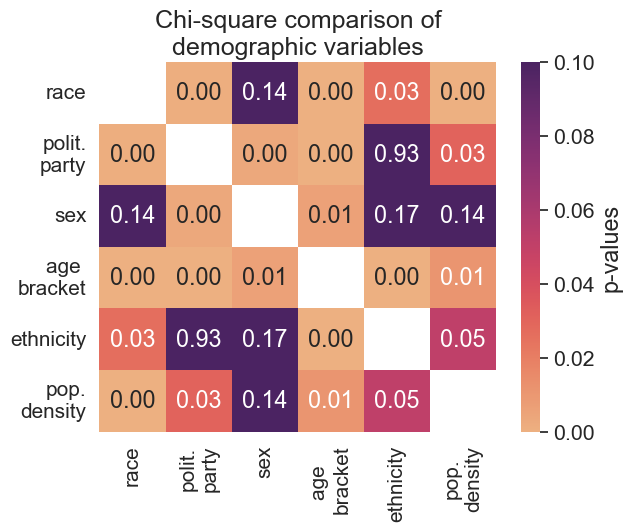

In [124]:
fig, ax = plt.subplots(1,1)
tick_labels = ['race', 'polit.\nparty', 'sex', 'age \nbracket', 'ethnicity', 'pop.\ndensity']
# heatmap p-values
sns.heatmap(p_vals.astype(float), cmap='flare', vmin=0, vmax=0.1, annot=True, fmt=".2f", ax = ax);
# label color bar
cbar = ax.collections[0].colorbar
cbar.set_label('p-values')
# set axis tick labels
ax.set_xticklabels(tick_labels, fontsize = 15);
ax.set_yticklabels(tick_labels, fontsize = 15);

ax.set_title('Chi-square comparison of\ndemographic variables',fontsize = 18)

img_format = 'svg'
fig.savefig(os.path.join(fig_dir, 'dem_var_chi_square_p_vals.' + img_format), format=img_format)



## covariance continous IVs -  measure averages within subject correlation 

In [102]:
def mean_correlation_and_variance(correlations, confidence_level=0.95):
    # drop nan values and exactly -+1
    correlations = correlations[~np.isnan(correlations)]
    correlations[correlations == 1] = 0.9999
    correlations[correlations == -1] = -0.9999
    # Fisher transformation
    z_values = 0.5 * np.log((1 + correlations) / (1 - correlations))
    
    # Compute the mean of the Fisher z-transformed values
    z_mean = np.nanmean(z_values)
    
    # Compute the standard error of the mean z value
    se_z_mean = 1 / np.sqrt(len(correlations) - 1)
    
    # Compute the critical value for the given confidence level
    z_critical = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    
    # Compute the confidence interval for the mean z value
    z_lower = z_mean - z_critical * se_z_mean
    z_upper = z_mean + z_critical * se_z_mean
    
    # Convert the mean z value and confidence interval back to the correlation scale
    mean_r = inverse_fisher_z(z_mean)
    r_lower = inverse_fisher_z(z_lower)
    r_upper = inverse_fisher_z(z_upper)
    
    return mean_r, (r_lower, r_upper), se_z_mean

def inverse_fisher_z(z):
    """
    Perform the inverse of Fisher's Z transformation.
    
    Parameters:
    z (float): Fisher's Z value.
    
    Returns:
    float: Pearson correlation coefficient.
    """
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

In [103]:
# participant level between measures correlation 
measures = local_context_vars+personal_experience+attitude_vars 
pid_corr = pd.DataFrame(columns = ['pid', 'index_var']+measures)
for pid in data.PROLIFIC_PID.unique():
    if data.loc[data.PROLIFIC_PID==pid].shape[0]>2:
        tmp_df = data.loc[data.PROLIFIC_PID==pid, measures].corr().reset_index()
        tmp_df  = tmp_df.rename(columns = {'index': 'index_var'})
        tmp_df['pid'] = pid
        pid_corr = pd.concat([pid_corr, tmp_df])

# average correlation coefficent 
avg_corr = pd.DataFrame(index =pid_corr.index_var.unique(), columns = pid_corr.index_var.unique())
CI = pd.DataFrame(index =pid_corr.index_var.unique(), columns = pid_corr.index_var.unique())
SE = pd.DataFrame(index =pid_corr.index_var.unique(), columns = pid_corr.index_var.unique())

for row in avg_corr.index:
    for col in avg_corr.columns:
# for row in ['weekly_econ_impact']:
#     for col in ['mean_social_network_health']:
        corr_vals = pid_corr.loc[pid_corr.index_var == row, pid_corr.columns== col]
        mean_r, confidence_interval, se_z_mean = mean_correlation_and_variance(corr_vals.values)
        avg_corr.loc[row, col] = mean_r
        CI.loc[row, col] = np.array(confidence_interval).round(2)
        SE.loc[row, col] = se_z_mean
        

/var/folders/fc/_2yc799j3dq5tc6c7h7f9z5c0000gn/T/ipykernel_28075/2676563909.py:7: RuntimeWarning: invalid value encountered in log
  z_values = 0.5 * np.log((1 + correlations) / (1 - correlations))


In [57]:
# within wave between measures correlation 
measures = local_context_vars+personal_experience+attitude_vars 
wave_corr = pd.DataFrame(columns = ['wave','index_var']+measures)


for wave in sorted(set(data.wave)):
    tmp_df = data.loc[data.wave==wave, measures].corr().reset_index()
    tmp_df  = tmp_df.rename(columns = {'index': 'index_var'})
    tmp_df['wave'] = wave
    wave_corr = pd.concat([wave_corr, tmp_df])

# average correlation coefficent 
avg_corr = pd.DataFrame(index =wave_corr.index_var.unique(), columns = wave_corr.index_var.unique())
CI = pd.DataFrame(index =wave_corr.index_var.unique(), columns = wave_corr.index_var.unique())
SE = pd.DataFrame(index =wave_corr.index_var.unique(), columns = wave_corr.index_var.unique())

for row in avg_corr.index:
    for col in avg_corr.columns:
# for row in ['weekly_econ_impact']:
#     for col in ['mean_social_network_health']:
        corr_vals = wave_corr.loc[wave_corr.index_var == row, wave_corr.columns== col]
        mean_r, confidence_interval, se_z_mean = mean_correlation_and_variance(corr_vals.values)
        avg_corr.loc[row, col] = mean_r
        CI.loc[row, col] = np.array(confidence_interval).round(2)
        SE.loc[row, col] = se_z_mean
    

In [95]:
wave_corr.columns

Index(['wave', 'index_var', 'cases_avg_per_100k', 'restriction_sum', 'ueRate',
       'mean_social_network_health', 'safety_measures', 'weekly_econ_impact',
       'cvd_concern', 'cvd_norm_agreement', 'restrict_f1', 'restrict_f2',
       'restrict_f3'],
      dtype='object')

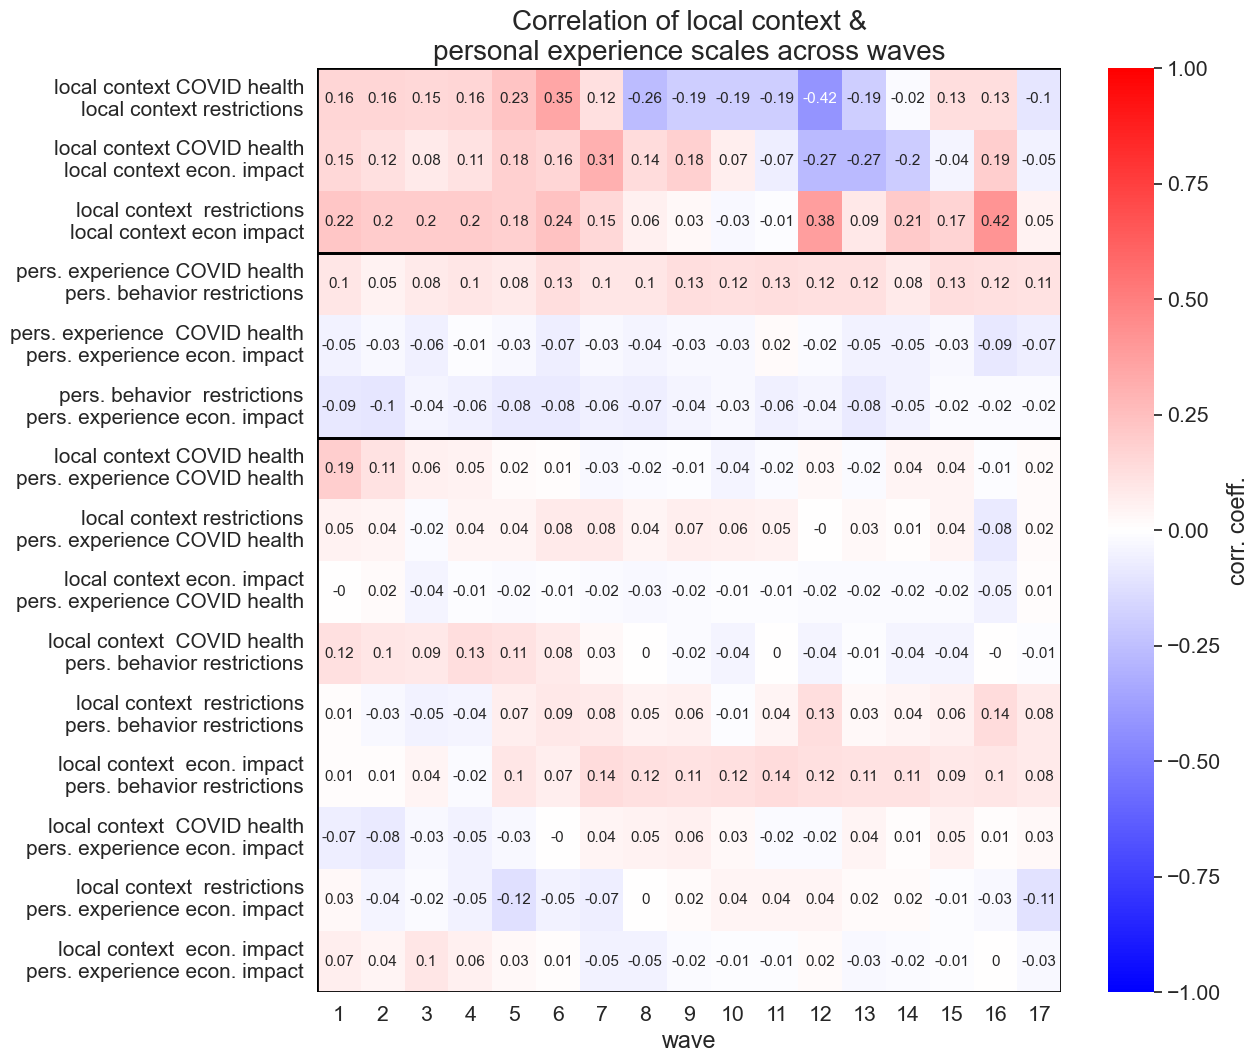

In [208]:
corr_timecourse = pd.DataFrame(columns = ['wave', 
                                          'local_health_restrict', 'local_health_econ', 'local_restrict_econ',
                                          'pers_health_restrict', 'pers_health_econ', 'pers_restrict_econ',
                                          'local_health_pers_health', 'local_restrict_pers_health', 'local_econ_pers_health', 
                                          'local_health_pers_restrict', 'local_restrict_pers_restrict', 'local_econ_pers_restrict',
                                          'local_health_pers_econ', 'local_restrict_pers_econ', 'local_econ_pers_econ'])
#                                           'healthConcern_norm','healthConcern_restrictImportance','norm_restrictImportance'])

corr_timecourse.wave = sorted(set(data.wave))

corr_timecourse['local_health_restrict'] = wave_corr.loc[wave_corr.index_var == 'cases_avg_per_100k', 'restriction_sum'].values
corr_timecourse['local_health_econ'] = wave_corr.loc[wave_corr.index_var == 'cases_avg_per_100k', 'ueRate'].values
corr_timecourse['local_restrict_econ'] = wave_corr.loc[wave_corr.index_var == 'restriction_sum', 'ueRate'].values

corr_timecourse['pers_health_restrict'] = wave_corr.loc[wave_corr.index_var == 'mean_social_network_health', 'safety_measures'].values
corr_timecourse['pers_health_econ'] = wave_corr.loc[wave_corr.index_var == 'mean_social_network_health', 'weekly_econ_impact'].values
corr_timecourse['pers_restrict_econ'] = wave_corr.loc[wave_corr.index_var == 'safety_measures', 'weekly_econ_impact'].values

corr_timecourse['local_health_pers_health'] = wave_corr.loc[wave_corr.index_var == 'cases_avg_per_100k', 'mean_social_network_health'].values
corr_timecourse['local_restrict_pers_health'] = wave_corr.loc[wave_corr.index_var == 'restriction_sum', 'mean_social_network_health'].values
corr_timecourse['local_econ_pers_health'] = wave_corr.loc[wave_corr.index_var == 'ueRate', 'mean_social_network_health'].values
corr_timecourse['local_health_pers_restrict'] = wave_corr.loc[wave_corr.index_var == 'cases_avg_per_100k', 'safety_measures'].values
corr_timecourse['local_restrict_pers_restrict'] = wave_corr.loc[wave_corr.index_var == 'restriction_sum', 'safety_measures'].values
corr_timecourse['local_econ_pers_restrict'] = wave_corr.loc[wave_corr.index_var == 'ueRate', 'safety_measures'].values
corr_timecourse['local_health_pers_econ'] = wave_corr.loc[wave_corr.index_var == 'cases_avg_per_100k', 'weekly_econ_impact'].values
corr_timecourse['local_restrict_pers_econ'] = wave_corr.loc[wave_corr.index_var == 'restriction_sum', 'weekly_econ_impact'].values
corr_timecourse['local_econ_pers_econ'] = wave_corr.loc[wave_corr.index_var == 'ueRate', 'weekly_econ_impact'].values

# corr_timecourse['healthConcern_norm'] = wave_corr.loc[wave_corr.index_var == 'cvd_concern', 'cvd_norm_agreement'].values
# corr_timecourse['healthConcern_restrictImportance'] = wave_corr.loc[wave_corr.index_var == 'cvd_concern', 'restrict_f1'].values
# corr_timecourse['norm_restrictImportance'] = wave_corr.loc[wave_corr.index_var == 'cvd_norm_agreement', 'restrict_f1'].values


y_labels = ['local context COVID health\nlocal context restrictions',
           'local context COVID health\nlocal context econ. impact',
           'local context  restrictions\nlocal context econ impact',
           'pers. experience COVID health\npers. behavior restrictions',
           'pers. experience  COVID health\npers. experience econ. impact',
           'pers. behavior  restrictions\npers. experience econ. impact',
           'local context COVID health\npers. experience COVID health',
           'local context restrictions\npers. experience COVID health',
           'local context econ. impact\npers. experience COVID health',
           'local context  COVID health\npers. behavior restrictions',
           'local context  restrictions\npers. behavior restrictions',
           'local context  econ. impact\npers. behavior restrictions',
           'local context  COVID health\npers. experience econ. impact',
           'local context  restrictions\npers. experience econ. impact',
           'local context  econ. impact\npers. experience econ. impact']

fig, ax = plt.subplots(1,1, figsize = (12,12))
sns.heatmap(corr_timecourse.set_index('wave').T.round(2),cmap='bwr', annot=True,annot_kws={"size": 11}
            ,vmin = -1, vmax = 1,ax = ax)
ax.set_yticklabels( y_labels,fontsize = 15);

# county level impact measures
ax.add_patch(
    patches.Rectangle((0, 0),
                      17,3,
                      edgecolor='black',
                      fill=False,
                      lw=2))

# personal level impact measures
ax.add_patch(
    patches.Rectangle((0, 3),
                      17,3,
                      edgecolor='black',
                      fill=False,
                      lw=2))

# personal level impact measures
ax.add_patch(
    patches.Rectangle((0, 6),
                      17,9,
                      edgecolor='black',
                      fill=False,
                      lw=2))
ax.set_title('Correlation of local context &\npersonal experience scales across waves', fontsize = 20);
cbar = ax.collections[0].colorbar
cbar.set_label('corr. coeff.') 

img_format = 'svg'
fig.savefig(os.path.join(fig_dir, 'corrAcrossWaves_localCntectPersExp.' + img_format), format=img_format)


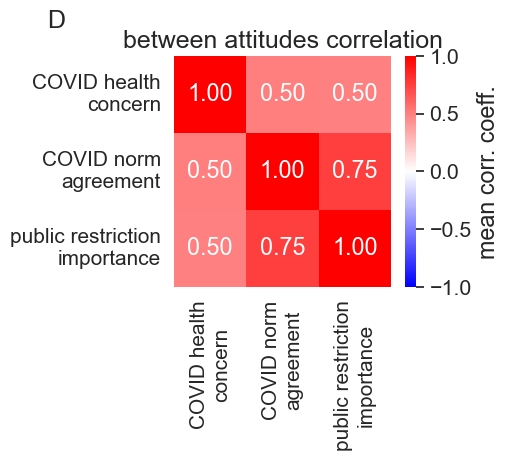

In [44]:
tick_lables = ['COVID health\nconcern', 'COVID norm\nagreement','public restriction\nimportance']
col_include = ['cvd_concern','cvd_norm_agreement','restrict_f1']

fig, ax = plt.subplots(1,1, figsize = (3.5,3))
sns.heatmap(avg_corr.loc[col_include,col_include].round(3).astype(float),cmap='bwr', annot=True,vmin = -1, vmax = 1,
           yticklabels=tick_lables,  xticklabels=tick_lables, ax = ax, fmt=".2f")
ax.set_xticklabels( tick_lables,fontsize = 15);
ax.set_yticklabels( tick_lables,fontsize = 15);
ax.set_ylabel("")
ax.set_title('between attitudes correlation',fontsize = 18)
cbar = ax.collections[0].colorbar
cbar.set_label('mean corr. coeff.') 
ax.text(-0.5, 1.2, 'D', transform=ax.transAxes, fontsize=18, fontweight='normal', va='top', ha='right')

img_format = 'svg'
fig.savefig(os.path.join(fig_dir, 'corrMat_attitudes.' + img_format), format=img_format)



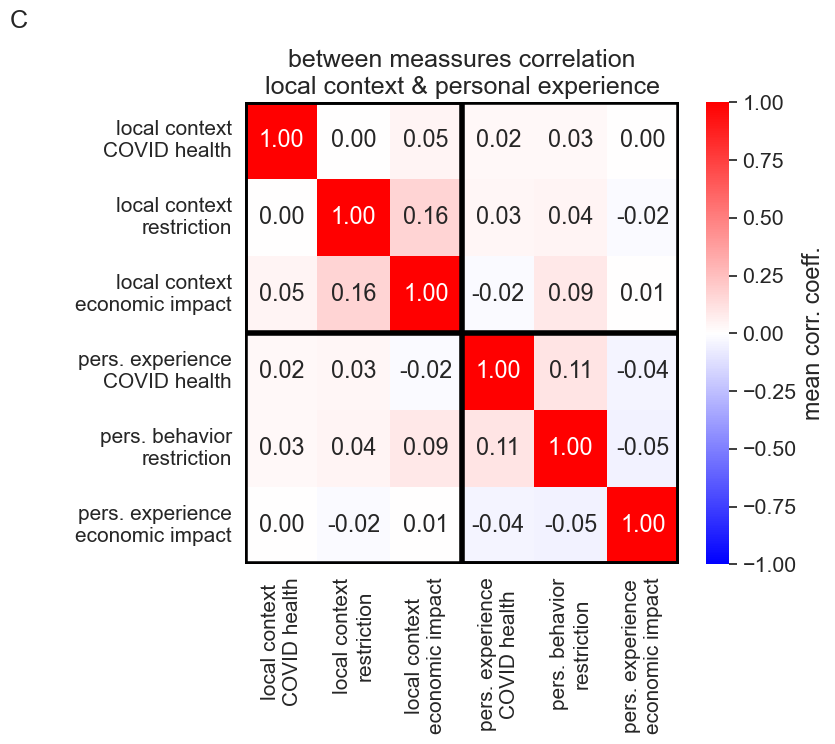

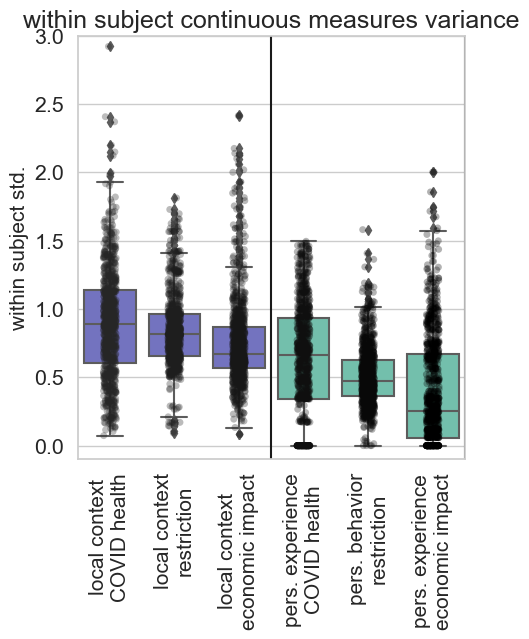

In [45]:
tick_lables = ['local context\nCOVID health', 'local context\nrestriction','local context\neconomic impact',
               'pers. experience\nCOVID health','pers. behavior\nrestriction', 'pers. experience\neconomic impact']
col_include = ['cases_avg_per_100k','restriction_sum', 'ueRate', 
               'mean_social_network_health','safety_measures', 'weekly_econ_impact',]            

fig, ax = plt.subplots(1,1, figsize = (7,6))
sns.heatmap(avg_corr.loc[col_include,col_include].round(3).astype(float),cmap='bwr', annot=True,vmin = -1, vmax = 1,
           yticklabels=tick_lables,  xticklabels=tick_lables, ax = ax, fmt=".2f")
ax.set_xticklabels( tick_lables,fontsize = 15);
ax.set_yticklabels( tick_lables,fontsize = 15);
ax.set_ylabel("")
ax.set_title('between meassures correlation\nlocal context & personal experience',fontsize = 18)
cbar = ax.collections[0].colorbar
cbar.set_label('mean corr. coeff.') 

# county level impact measures
ax.add_patch(
    patches.Rectangle((0, 0),
                      3,3,
                      edgecolor='black',
                      fill=False,
                      lw=4))

# personal level impact measures
ax.add_patch(
    patches.Rectangle((3, 3),
                      3,3,
                      edgecolor='black',
                      fill=False,
                      lw=4))

# overall frame
ax.add_patch(
    patches.Rectangle((0, 0),
                      6,6,
                      edgecolor='black',
                      fill=False,
                      lw=4))

ax.text(-0.5, 1.2, 'C', transform=ax.transAxes, fontsize=18, fontweight='normal', va='top', ha='right')

img_format = 'svg'
fig.savefig(os.path.join(fig_dir, 'corrMat_local_and_personal_context.' + img_format), format=img_format)


fig, ax = plt.subplots(1,1, figsize = (5,5.5))

# Within subject variance across waves per measure
sns.boxplot(data_zscore[col_include+['PROLIFIC_PID']].groupby(by = 'PROLIFIC_PID').std(), ax = ax,
            palette = [[0.4,0.4,0.8], [0.4,0.4,0.8],[0.4,0.4,0.8], 
                        [0.4,0.8,0.7], [0.4,0.8,0.7],[0.4,0.8,0.7], 
                        [1,0.8,0.3], [1,0.8,0.3],[1,0.8,0.3],[1,0.8,0.3], [1,0.8,0.3],])
sns.stripplot(data_zscore[col_include+['PROLIFIC_PID']].groupby(by = 'PROLIFIC_PID').std(), ax = ax, 
                palette='dark:black', alpha = 0.3)
ax.set_xticklabels( tick_lables,rotation = 90, fontsize = 15);
ax.set_ylim((-0.1,3));
ax.set_ylabel('within subject std.',fontsize = 15)
ax.set_title('within subject continuous measures variance',fontsize = 18)
ax.plot([2.5,2.5], [-.1,3], c='k')
ax.plot([5.5,5.5], [-.1,3], c='k')


img_format = 'svg'
fig.savefig(os.path.join(fig_dir, 'withinSubVar_local_and_personal_context.' + img_format), format=img_format)


## continuous and categorical IVs Correlation Ratio

In [155]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)

    for i in range(0, cat_num):
        cat_measures = measurements.loc[fcat == i].values
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.mean(cat_measures)

    y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(n_array)
    numerator = np.sum(np.multiply(n_array, np.square(np.subtract(y_avg_array, y_total_avg))))
    denominator = np.sum(np.square(np.subtract(measurements, y_total_avg)))

    if denominator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator / denominator)
    return eta     

dem_vars = ['sex','agecats', 'polit_party',
            'race','ethnicity','loc_description']
cont_vars = ['cases_avg_per_100k', 'ueRate', 'restriction_sum',
               'mean_social_network_health', 'weekly_econ_impact','safety_measures']            


eta_df = pd.DataFrame(index = cont_vars, columns = dem_vars)
for dem_v in dem_vars:
    for cont_v in cont_vars:
        eta_squared = np.empty((data.wave.max(), 1))
        for w in np.sort(data.wave.unique()):
            data_tmp = data.loc[data.wave == w,[dem_v,cont_v ]].dropna()
            eta_squared[w-1] = correlation_ratio(data_tmp[dem_v], data_tmp[cont_v])
            
        eta_df.loc[cont_v,dem_v] = float(np.mean(eta_squared))

sex
cases_avg_per_100k
[[0.09445971]
 [0.09831819]
 [0.09786091]
 [0.07988657]
 [0.00054731]
 [0.01837592]
 [0.04121203]
 [0.03328035]
 [0.01351822]
 [0.01846195]
 [0.01248453]
 [0.02665972]
 [0.03668371]
 [0.00332355]
 [0.01256614]
 [0.00499217]
 [0.06462973]]
ueRate
[[0.01576611]
 [0.03246718]
 [0.01338992]
 [0.01520381]
 [0.04781504]
 [0.06669445]
 [0.08469422]
 [0.06938638]
 [0.09031173]
 [0.06999457]
 [0.07877687]
 [0.07182831]
 [0.08938853]
 [0.10131589]
 [0.09039453]
 [0.1064385 ]
 [0.114977  ]]
restriction_sum
[[0.01519911]
 [0.01022886]
 [0.00285049]
 [0.00897971]
 [0.01117695]
 [0.03191764]
 [0.03555875]
 [0.01447372]
 [0.03043041]
 [0.00349094]
 [0.01264285]
 [0.04636248]
 [0.00935159]
 [0.03413801]
 [0.03129157]
 [0.05762864]
 [0.0364935 ]]
mean_social_network_health
[[0.00125184]
 [0.00684474]
 [0.0379966 ]
 [0.04982349]
 [0.06524368]
 [0.04041006]
 [0.06368957]
 [0.05965028]
 [0.07047946]
 [0.05966281]
 [0.03962444]
 [0.08951686]
 [0.03266231]
 [0.05020104]
 [0.06312402]


[[0.12194814]
 [0.08099916]
 [0.07016375]
 [0.07733434]
 [0.10781283]
 [0.10225773]
 [0.08742129]
 [0.09900163]
 [0.08567752]
 [0.08776028]
 [0.1086596 ]
 [0.077055  ]
 [0.07749409]
 [0.08762072]
 [0.11015114]
 [0.04810147]
 [0.13762859]]
weekly_econ_impact
[[0.1571651 ]
 [0.15714251]
 [0.15585275]
 [0.15529981]
 [0.12469875]
 [0.14635976]
 [0.14688122]
 [0.14204557]
 [0.13112164]
 [0.11361855]
 [0.14959412]
 [0.14625545]
 [0.13719854]
 [0.16130346]
 [0.15401339]
 [0.16708731]
 [0.23459704]]
safety_measures
[[0.19459911]
 [0.16886209]
 [0.17543848]
 [0.19592394]
 [0.18915275]
 [0.19902762]
 [0.2080524 ]
 [0.1936564 ]
 [0.19641352]
 [0.17530531]
 [0.20855701]
 [0.17252652]
 [0.16837811]
 [0.13366642]
 [0.15189479]
 [0.16239168]
 [0.11619396]]


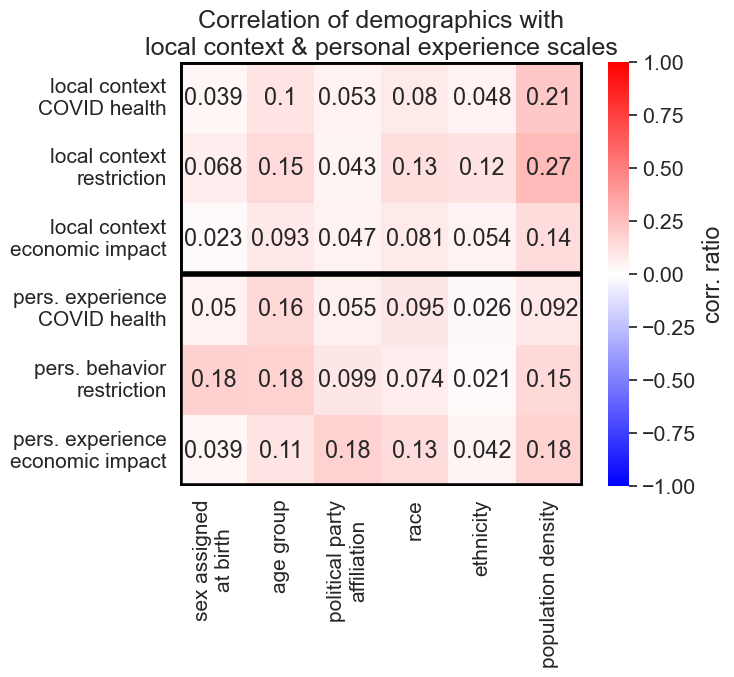

In [126]:
y_tick_lables = ['local context\nCOVID health', 'local context\nrestriction','local context\neconomic impact',
               'pers. experience\nCOVID health','pers. behavior\nrestriction', 'pers. experience\neconomic impact']

x_tick_lables = ['sex assigned\nat birth', 'age group', 'political party\naffiliation', 'race','ethnicity', 'population density']
for col in eta_df.columns:
    eta_df[col] = pd.to_numeric(eta_df[col])  # 'coerce' will set non-convertible values to NaN


fig, ax = plt.subplots(1,1, figsize = (6.5,5.5))
sns.heatmap(eta_df.round(3),cmap='bwr', annot=True,vmin = -1, vmax = 1,
           yticklabels=y_tick_lables,  xticklabels=x_tick_lables, ax = ax)
ax.set_xticklabels( x_tick_lables,fontsize = 15);
ax.set_yticklabels( y_tick_lables,fontsize = 15);
ax.set_ylabel("")
ax.set_title('Correlation of demographics with\nlocal context & personal experience scales',fontsize = 18)
cbar = ax.collections[0].colorbar
cbar.set_label('corr. ratio') 

# county level impact measures
ax.add_patch(
    patches.Rectangle((0, 0),
                      6,3,
                      edgecolor='black',
                      fill=False,
                      lw=4))

# overall frame
ax.add_patch(
    patches.Rectangle((0, 0),
                      6,6,
                      edgecolor='black',
                      fill=False,
                      lw=4))


img_format = 'svg'
fig.savefig(os.path.join(fig_dir, 'corrRatio_continous_cat_vars.' + img_format), format=img_format)


In [179]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)

    for i in range(0, cat_num):
        cat_measures = measurements.loc[fcat == i].values
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.mean(cat_measures)

    y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(n_array)
    numerator = np.sum(np.multiply(n_array, np.square(np.subtract(y_avg_array, y_total_avg))))
    denominator = np.sum(np.square(np.subtract(measurements, y_total_avg)))

    if denominator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator / denominator)
    return eta     

dem_vars = ['sex','agecats', 'polit_party',
            'race','ethnicity','loc_description']
cont_vars = ['cases_avg_per_100k', 'ueRate', 'restriction_sum',
               'mean_social_network_health', 'weekly_econ_impact','safety_measures']            


eta_squared_sex = pd.DataFrame(index = np.sort(data.wave.unique()), columns = cont_vars)
for cont_v in cont_vars:
    for w in np.sort(data.wave.unique()):
        data_tmp = data.loc[data.wave == w,['sex',cont_v ]].dropna()
        eta_squared_sex.loc[eta_squared_sex.index == w, cont_v] = correlation_ratio(data_tmp['sex'], data_tmp[cont_v])   
eta_squared_sex = eta_squared_sex.astype('float')

eta_squared_age = pd.DataFrame(index = np.sort(data.wave.unique()), columns = cont_vars)
for cont_v in cont_vars:
    for w in np.sort(data.wave.unique()):
        data_tmp = data.loc[data.wave == w,['agecats',cont_v ]].dropna()
        eta_squared_age.loc[eta_squared_age.index == w, cont_v] = correlation_ratio(data_tmp['agecats'], data_tmp[cont_v])
eta_squared_age = eta_squared_age.astype('float')

eta_squared_polit_party = pd.DataFrame(index = np.sort(data.wave.unique()), columns = cont_vars)
for cont_v in cont_vars:
    for w in np.sort(data.wave.unique()):
        data_tmp = data.loc[data.wave == w,['polit_party',cont_v ]].dropna()
        eta_squared_polit_party.loc[eta_squared_polit_party.index == w, cont_v] = correlation_ratio(data_tmp['polit_party'], data_tmp[cont_v])
eta_squared_polit_party = eta_squared_polit_party.astype('float')

eta_squared_race = pd.DataFrame(index = np.sort(data.wave.unique()), columns = cont_vars)
for cont_v in cont_vars:
    for w in np.sort(data.wave.unique()):
        data_tmp = data.loc[data.wave == w,['race',cont_v ]].dropna()
        eta_squared_race.loc[eta_squared_race.index == w, cont_v] = correlation_ratio(data_tmp['race'], data_tmp[cont_v])
eta_squared_race = eta_squared_race.astype('float')
        
eta_squared_ethnicity = pd.DataFrame(index = np.sort(data.wave.unique()), columns = cont_vars)
for cont_v in cont_vars:
    for w in np.sort(data.wave.unique()):
        data_tmp = data.loc[data.wave == w,['ethnicity',cont_v ]].dropna()
        eta_squared_ethnicity.loc[eta_squared_ethnicity.index == w, cont_v] = correlation_ratio(data_tmp['ethnicity'], data_tmp[cont_v])
eta_squared_ethnicity = eta_squared_ethnicity.astype('float')

eta_squared_loc = pd.DataFrame(index = np.sort(data.wave.unique()), columns = cont_vars)
for cont_v in cont_vars:
    for w in np.sort(data.wave.unique()):
        data_tmp = data.loc[data.wave == w,['loc_description',cont_v ]].dropna()
        eta_squared_loc.loc[eta_squared_loc.index == w, cont_v] = correlation_ratio(data_tmp['loc_description'], data_tmp[cont_v])
eta_squared_loc = eta_squared_loc.astype('float')



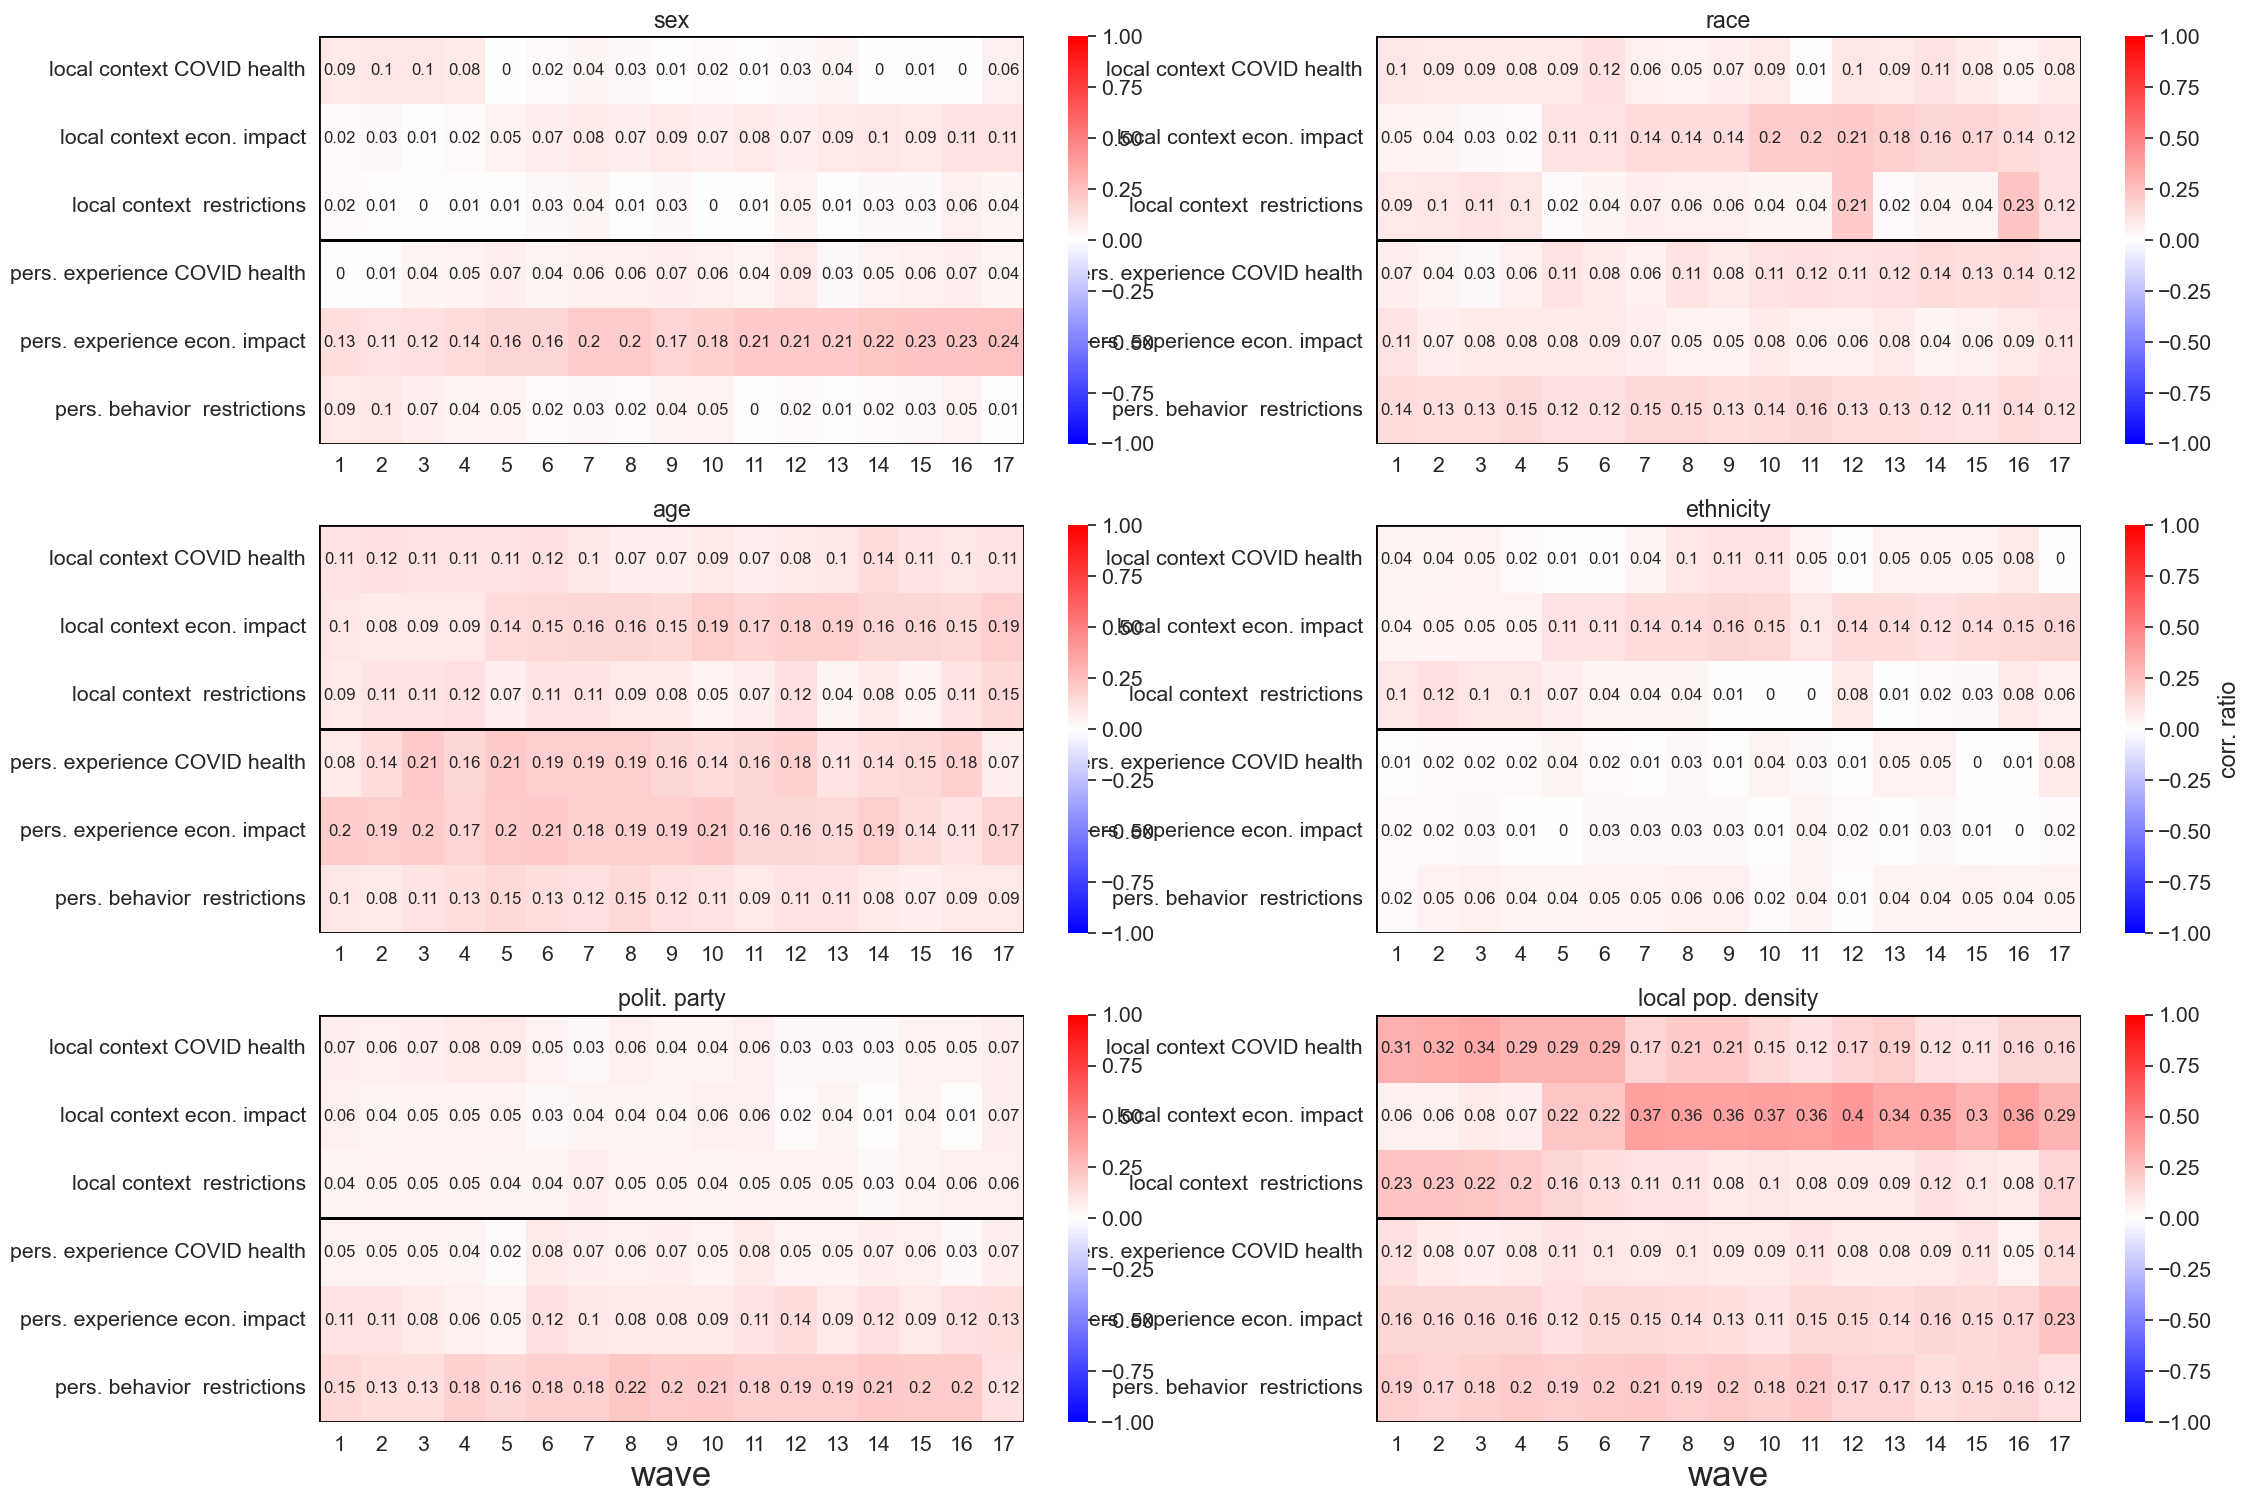

In [211]:
y_labels = ['local context COVID health',
           'local context econ. impact',
           'local context  restrictions',
           'pers. experience COVID health',
           'pers. experience econ. impact',
           'pers. behavior  restrictions']


fig, ax = plt.subplots(3,2, figsize = (25,18))


sns.heatmap(eta_squared_sex.T.round(2),cmap='bwr', annot=True,annot_kws={"size": 12}
            ,vmin = -1, vmax = 1,ax = ax[0,0]);
ax[0,0].set_yticklabels(y_labels);
ax[0,0].set_title('sex');
# county level impact measures
ax[0,0].add_patch(
    patches.Rectangle((0, 0),
                      17,3,
                      edgecolor='black',
                      fill=False,
                      lw=2))

# personal level impact measures
ax[0,0].add_patch(
    patches.Rectangle((0, 3),
                      17,3,
                      edgecolor='black',
                      fill=False,
                      lw=2))



sns.heatmap(eta_squared_age.T.round(2),cmap='bwr', annot=True,annot_kws={"size": 12}
            ,vmin = -1, vmax = 1,ax = ax[1,0]);
ax[1,0].set_yticklabels(y_labels);
ax[1,0].set_title('age');
# county level impact measures
ax[1,0].add_patch(
    patches.Rectangle((0, 0),
                      17,3,
                      edgecolor='black',
                      fill=False,
                      lw=2))

# personal level impact measures
ax[1,0].add_patch(
    patches.Rectangle((0, 3),
                      17,3,
                      edgecolor='black',
                      fill=False,
                      lw=2))

sns.heatmap(eta_squared_polit_party.T.round(2),cmap='bwr', annot=True,annot_kws={"size": 12}
            ,vmin = -1, vmax = 1,ax = ax[2,0]);
ax[2,0].set_yticklabels(y_labels);
ax[2,0].set_title('polit. party');
ax[2,0].set_xlabel('wave', fontsize = 25);
# county level impact measures
ax[2,0].add_patch(
    patches.Rectangle((0, 0),
                      17,3,
                      edgecolor='black',
                      fill=False,
                      lw=2))

# personal level impact measures
ax[2,0].add_patch(
    patches.Rectangle((0, 3),
                      17,3,
                      edgecolor='black',
                      fill=False,
                      lw=2))


sns.heatmap(eta_squared_race.T.round(2),cmap='bwr', annot=True,annot_kws={"size": 12}
            ,vmin = -1, vmax = 1,ax = ax[0,1]);
ax[0,1].set_yticklabels(y_labels);
ax[0,1].set_title('race');
# county level impact measures
ax[0,1].add_patch(
    patches.Rectangle((0, 0),
                      17,3,
                      edgecolor='black',
                      fill=False,
                      lw=2))

# personal level impact measures
ax[0,1].add_patch(
    patches.Rectangle((0, 3),
                      17,3,
                      edgecolor='black',
                      fill=False,
                      lw=2))

sns.heatmap(eta_squared_ethnicity.T.round(2),cmap='bwr', annot=True,annot_kws={"size": 12}
            ,vmin = -1, vmax = 1,ax = ax[1,1]);
ax[1,1].set_yticklabels(y_labels);
ax[1,1].set_title('ethnicity');
# county level impact measures
ax[1,1].add_patch(
    patches.Rectangle((0, 0),
                      17,3,
                      edgecolor='black',
                      fill=False,
                      lw=2))

# personal level impact measures
ax[1,1].add_patch(
    patches.Rectangle((0, 3),
                      17,3,
                      edgecolor='black',
                      fill=False,
                      lw=2))

sns.heatmap(eta_squared_loc.T.round(2),cmap='bwr', annot=True,annot_kws={"size": 12}
            ,vmin = -1, vmax = 1,ax = ax[2,1]);
ax[2,1].set_yticklabels(y_labels);
ax[2,1].set_title('local pop. density');
ax[2,1].set_xlabel('wave', fontsize = 25);
cbar = ax[1,1].collections[0].colorbar
cbar.set_label('corr. ratio') 
# county level impact measures
ax[2,1].add_patch(
    patches.Rectangle((0, 0),
                      17,3,
                      edgecolor='black',
                      fill=False,
                      lw=2))

# personal level impact measures
ax[2,1].add_patch(
    patches.Rectangle((0, 3),
                      17,3,
                      edgecolor='black',
                      fill=False,
                      lw=2))


img_format = 'svg'
fig.savefig(os.path.join(fig_dir, 'corrRatio_continous_cat_vars_waveByWave.' + img_format), format=img_format)


##  DVs -  within subject variance


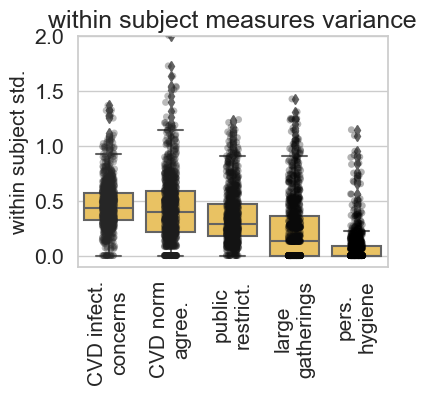

In [28]:
tick_lables = [ 'CVD infect.\nconcerns', 'CVD norm\nagree.', 'public\nrestrict.', 'large\ngatherings', 'pers.\nhygiene']
col_include = attitude_vars    



fig, ax = plt.subplots(1,1, figsize = (4,3))

# Within subject variance across waves per measure
sns.boxplot(data[col_include+['PROLIFIC_PID']].groupby(by = 'PROLIFIC_PID').std(), ax = ax,
            palette = [[1,0.8,0.3], [1,0.8,0.3],[1,0.8,0.3],[1,0.8,0.3], [1,0.8,0.3],])
sns.stripplot(data[col_include+['PROLIFIC_PID']].groupby(by = 'PROLIFIC_PID').std(), ax = ax, 
                palette='dark:black', alpha = 0.3)
ax.set_xticklabels( tick_lables,rotation = 90, fontsize = 15);
ax.set_ylim((-0.1,2));
ax.set_ylabel('within subject std.',fontsize = 15)
ax.set_title('within subject measures variance',fontsize = 18)

img_format = 'svg'
fig.savefig(os.path.join(fig_dir, 'withinSubVar_attMeasures.' + img_format), format=img_format)


# Lasso Regression

## dems predicting local and personal context

KeyboardInterrupt: 

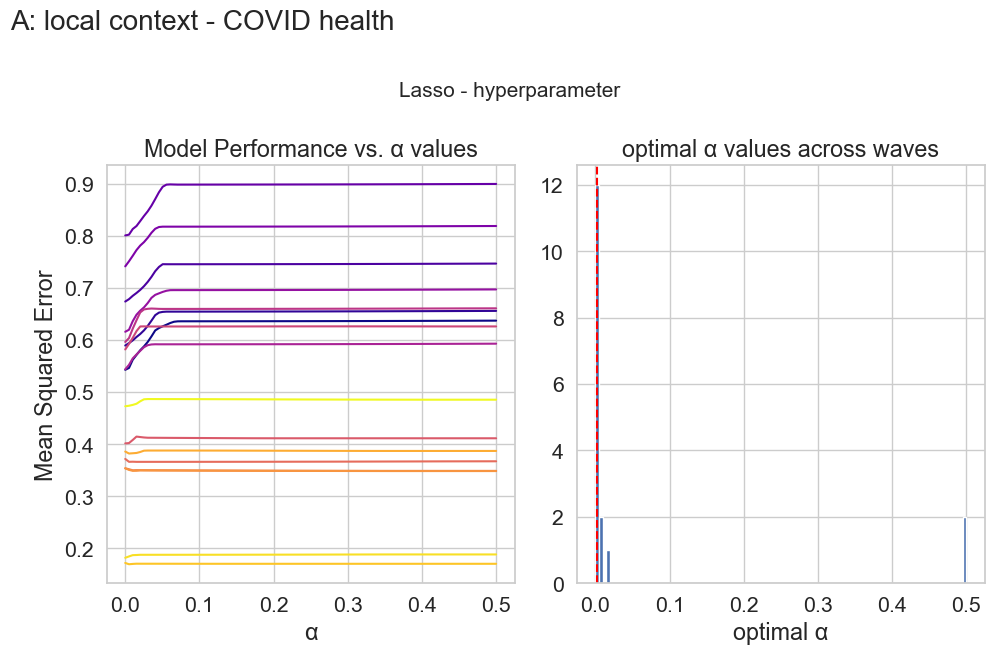

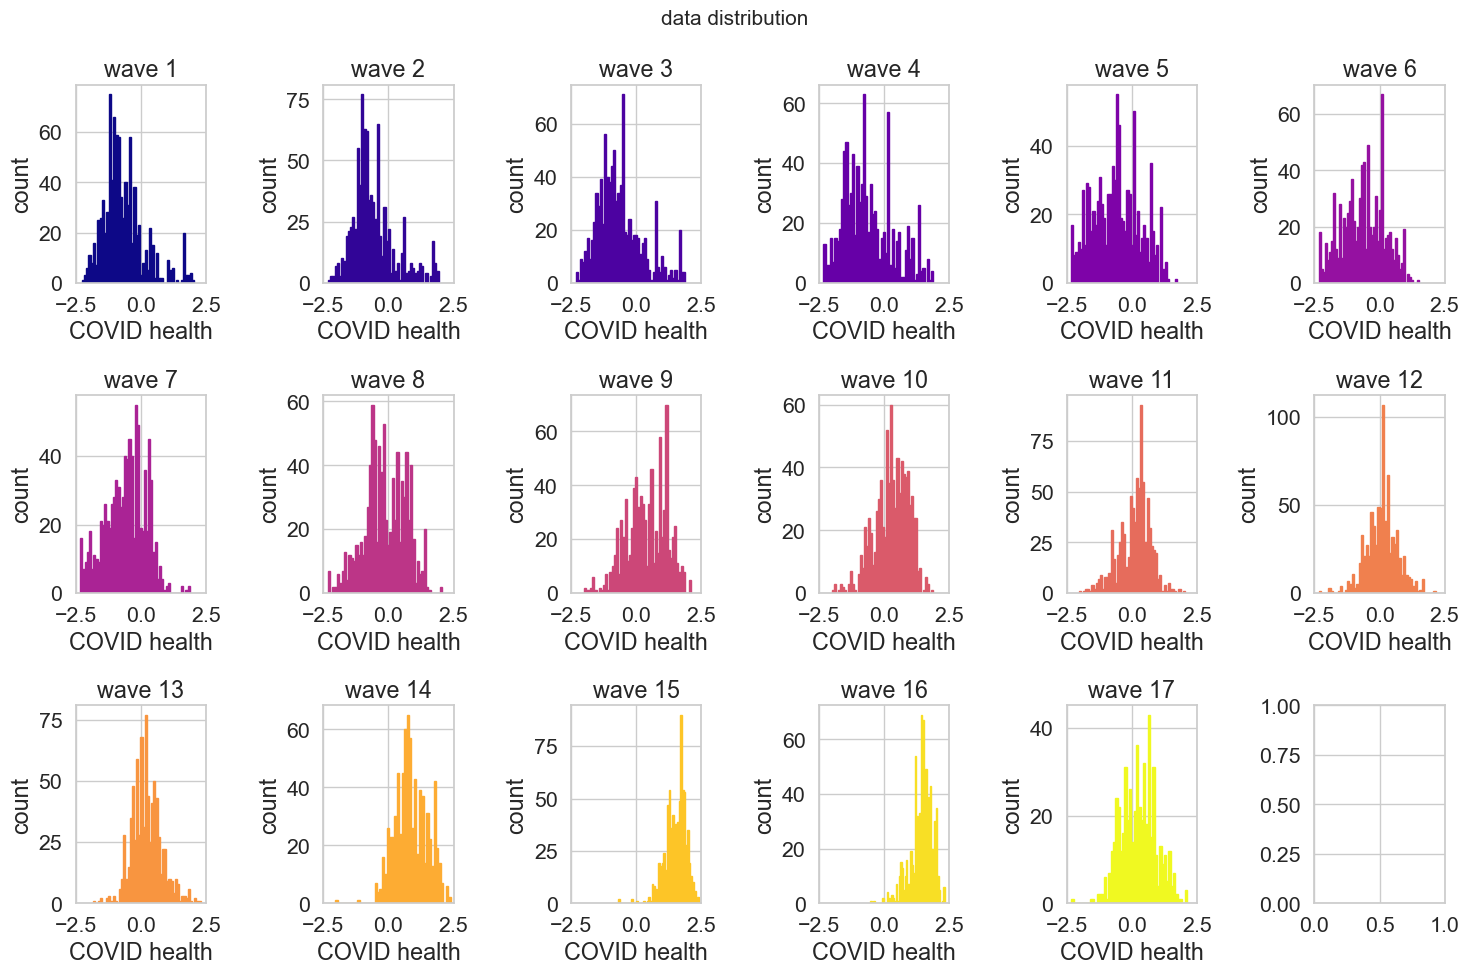

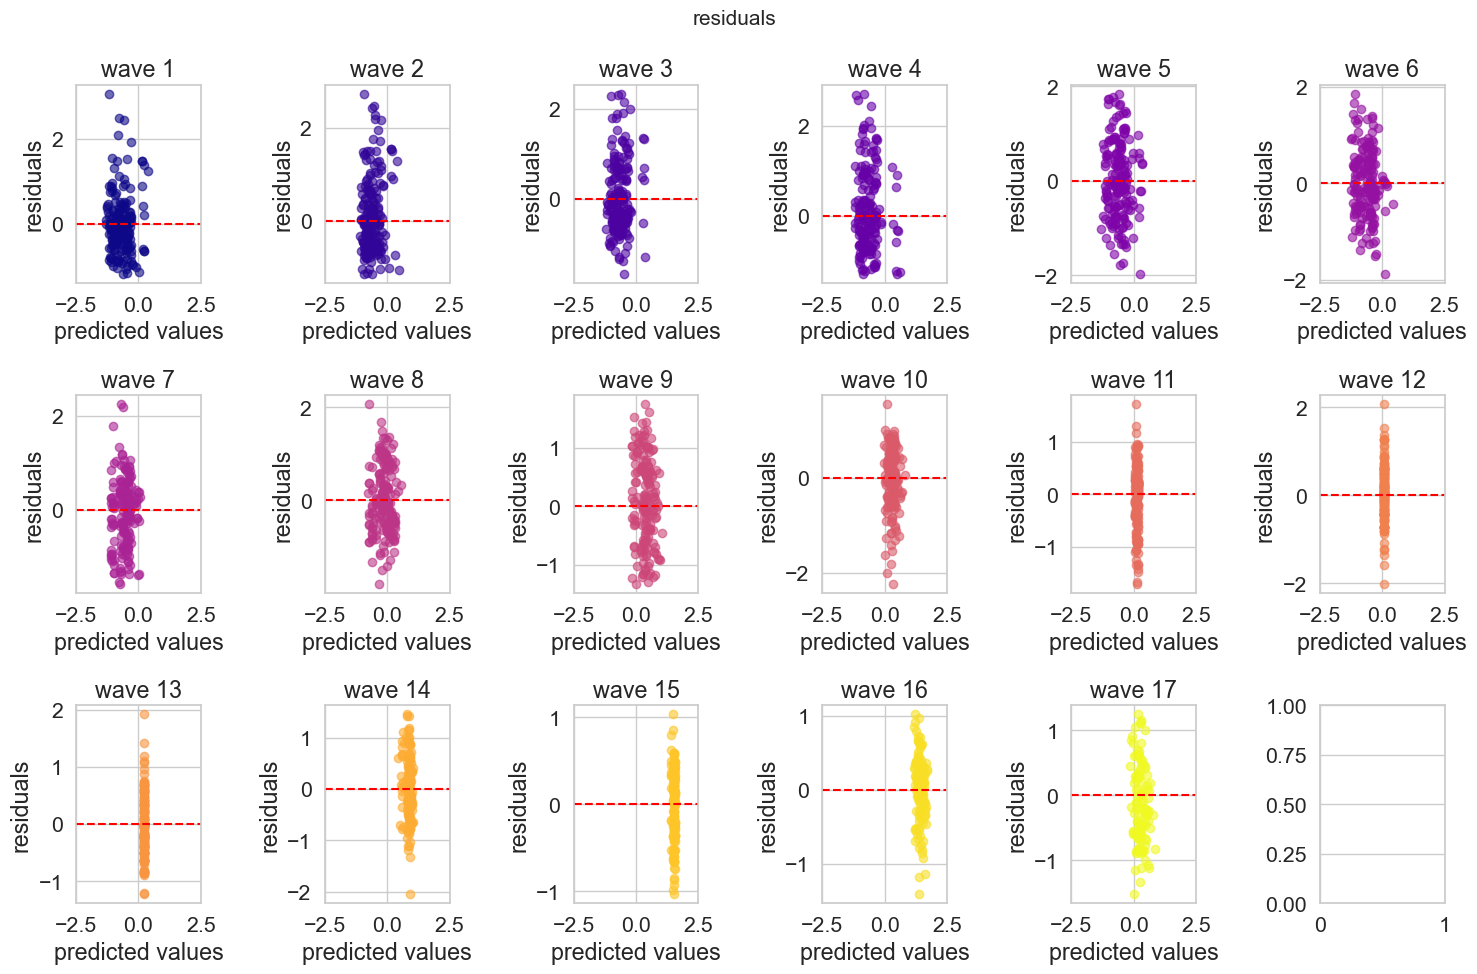

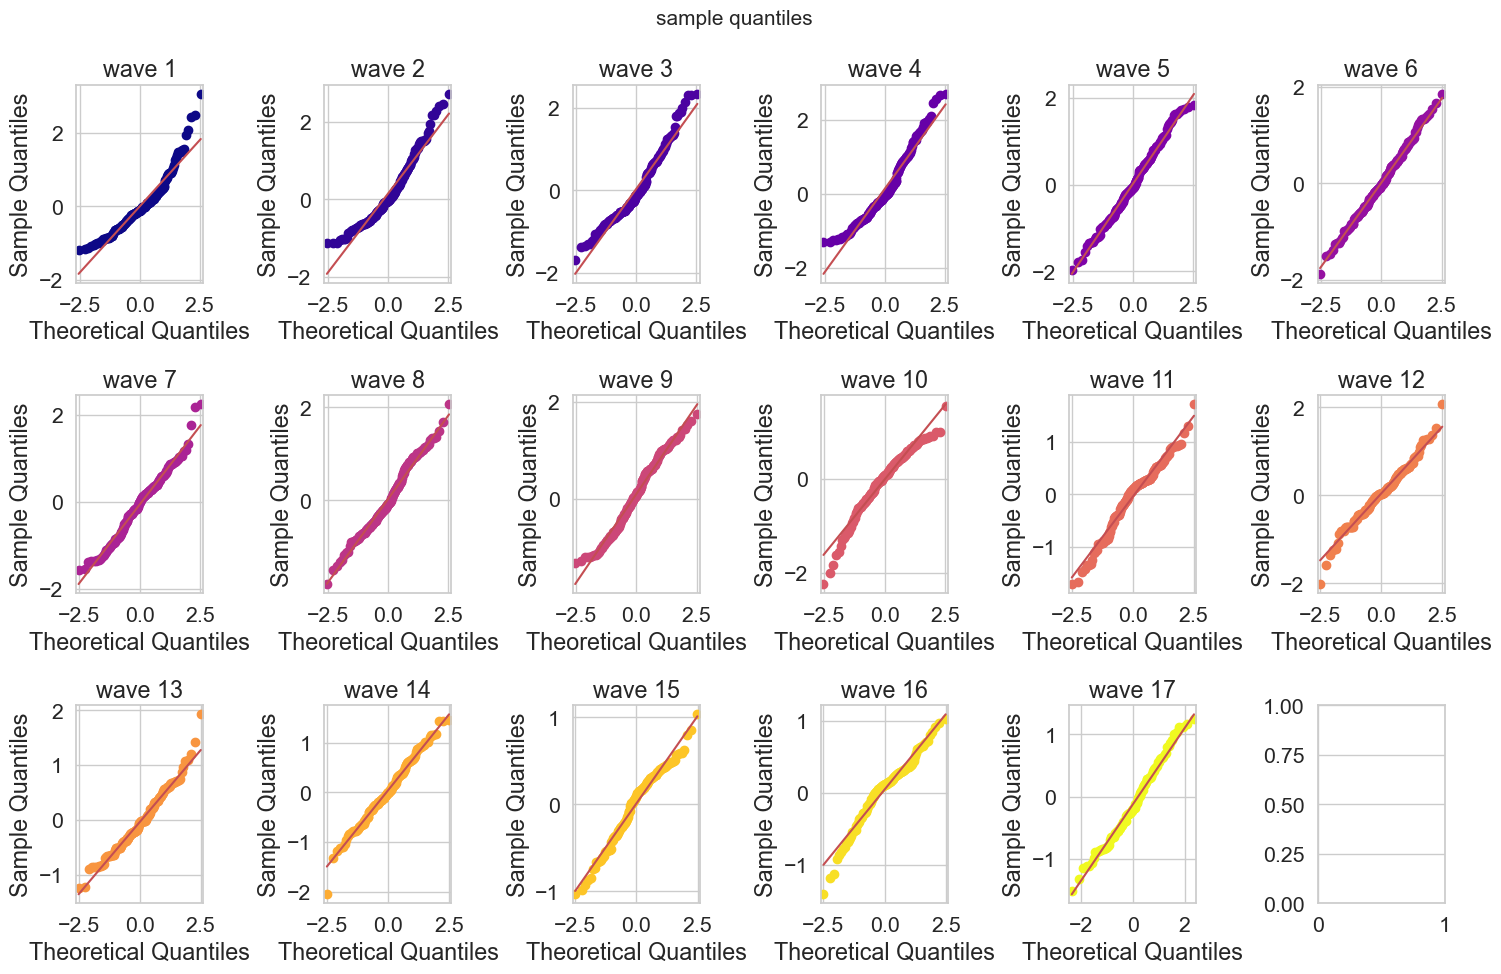

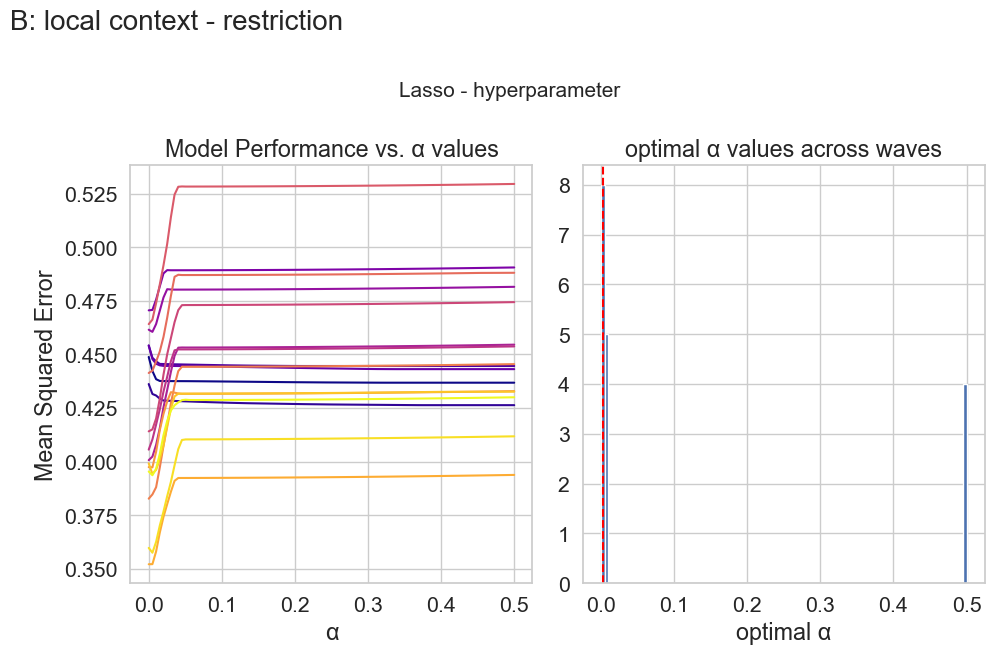

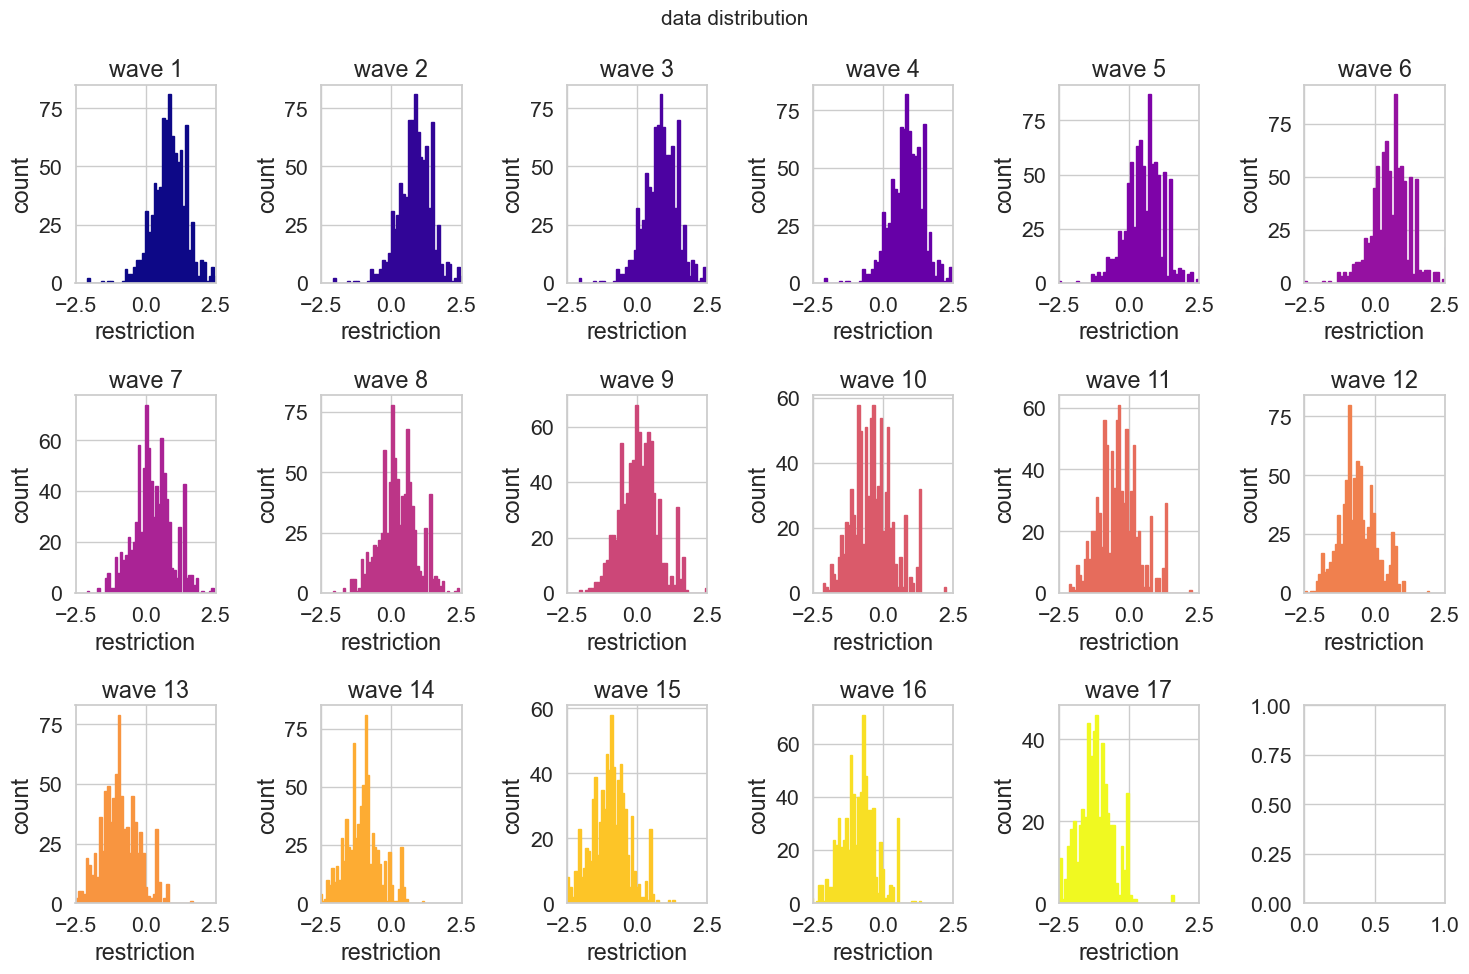

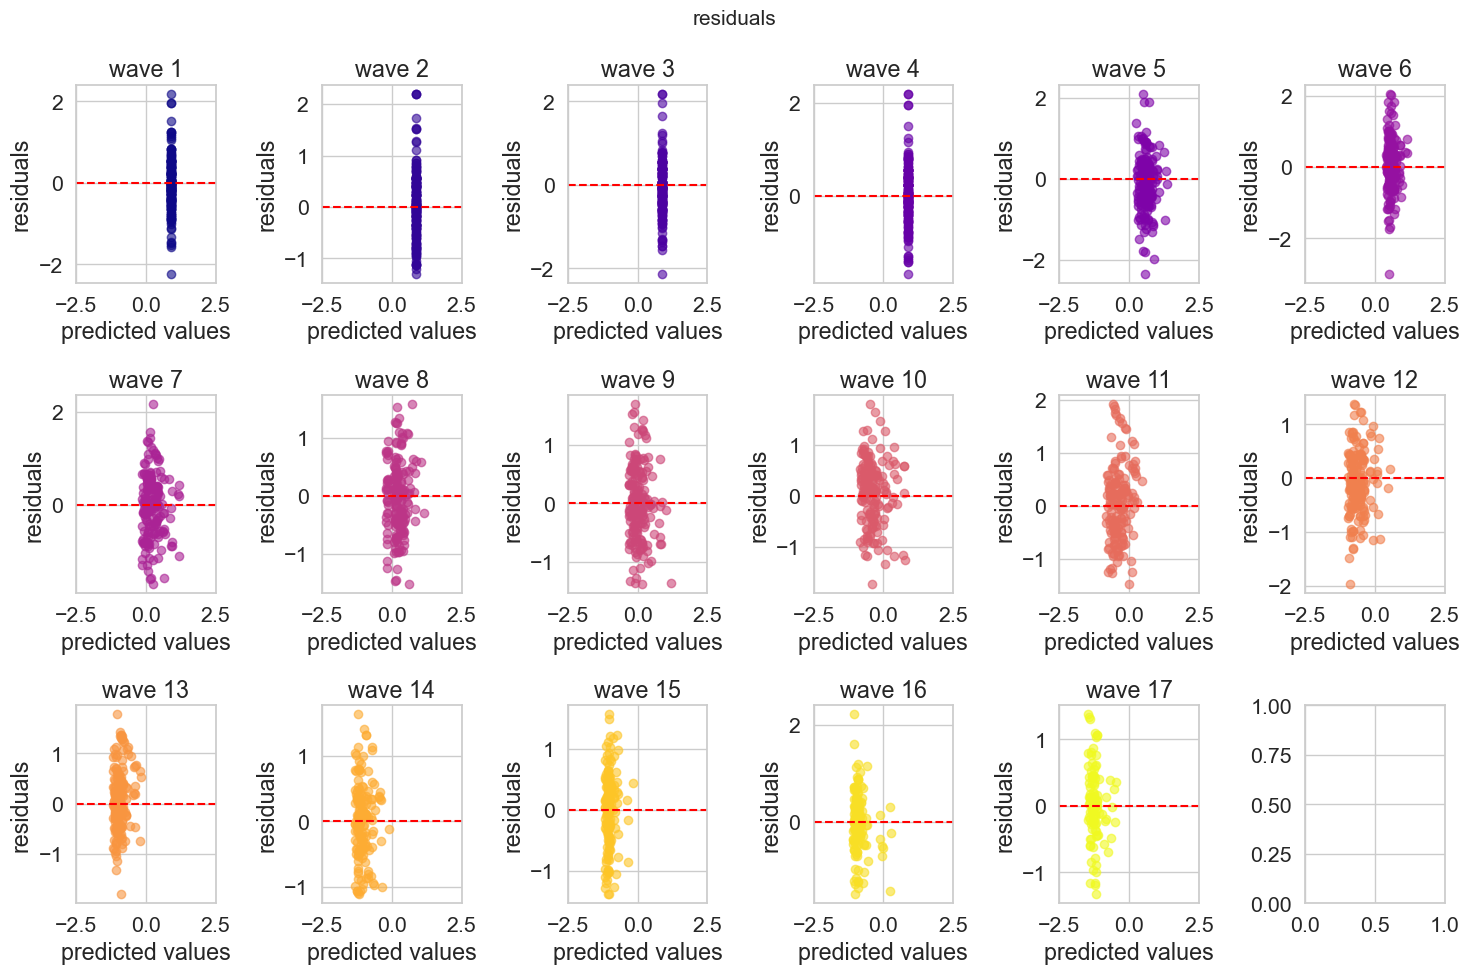

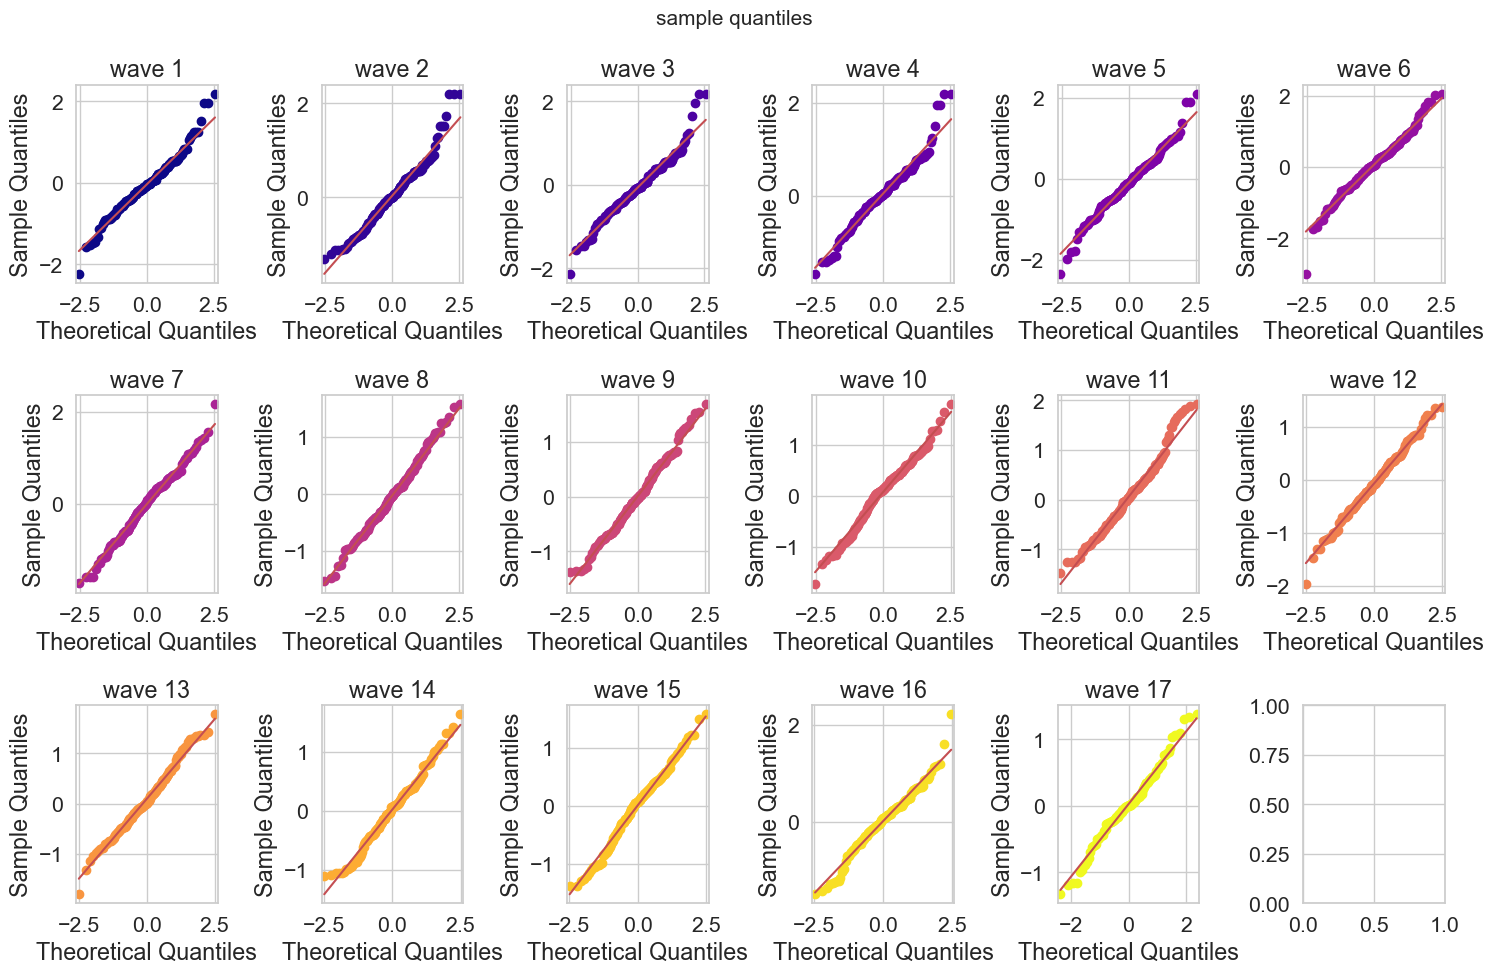

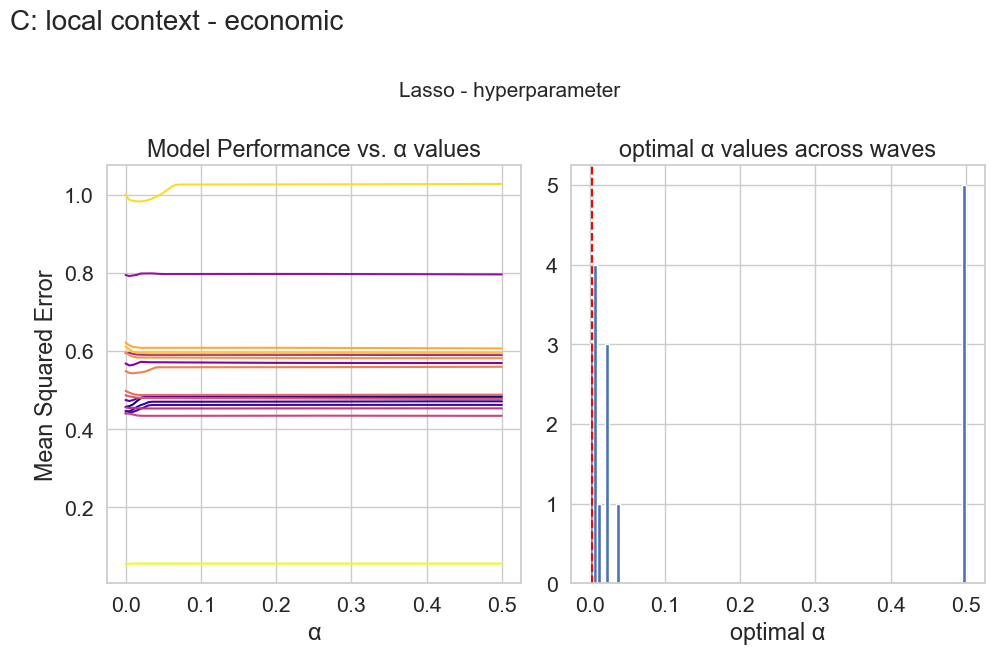

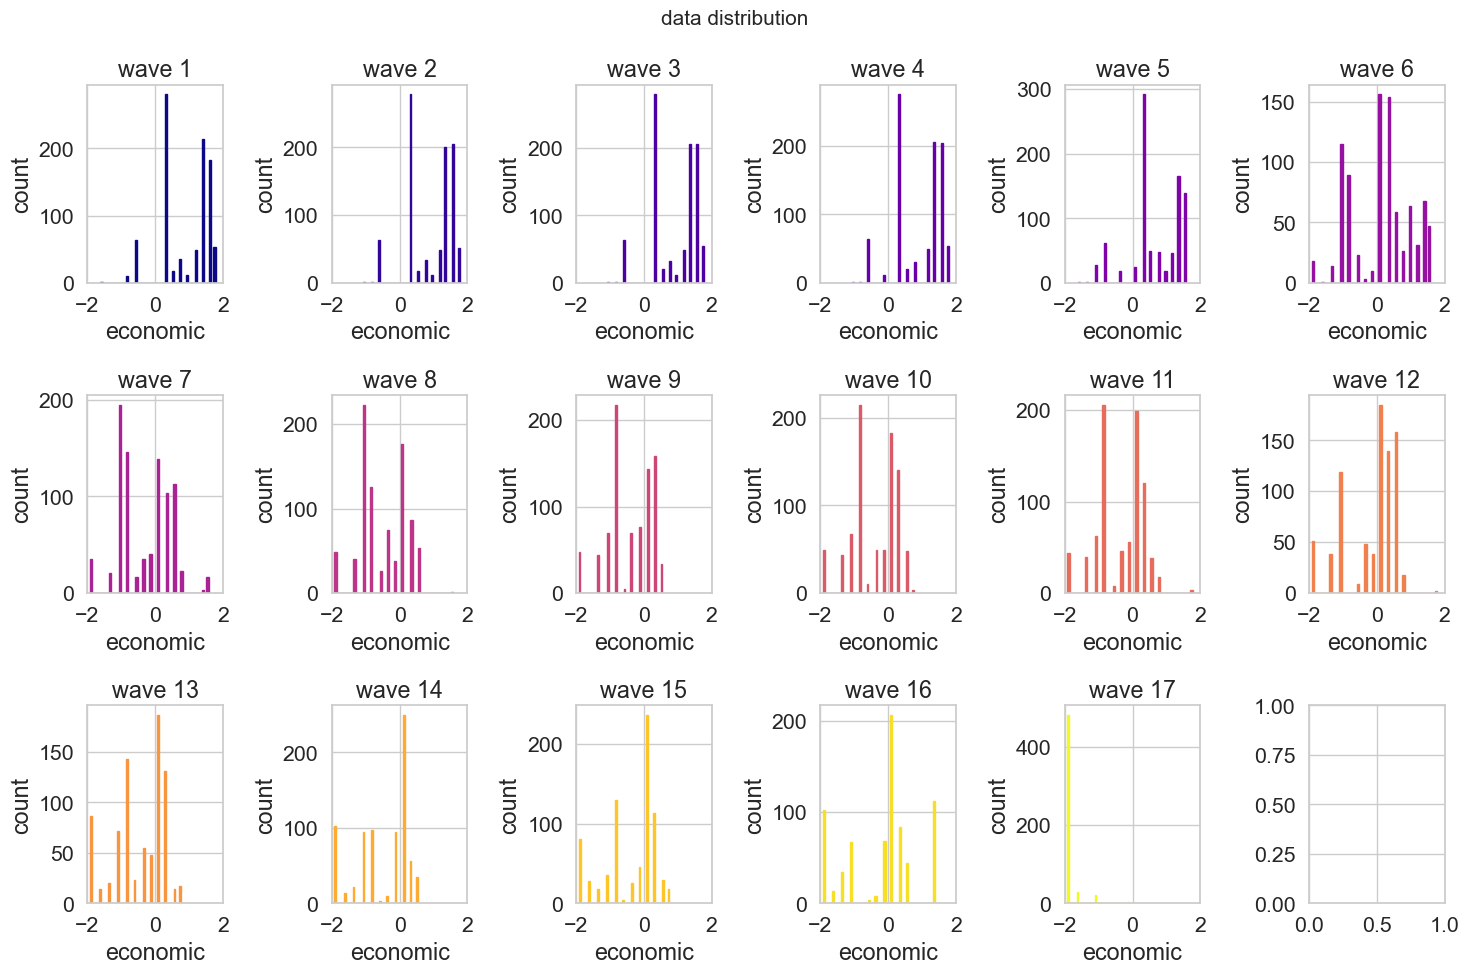

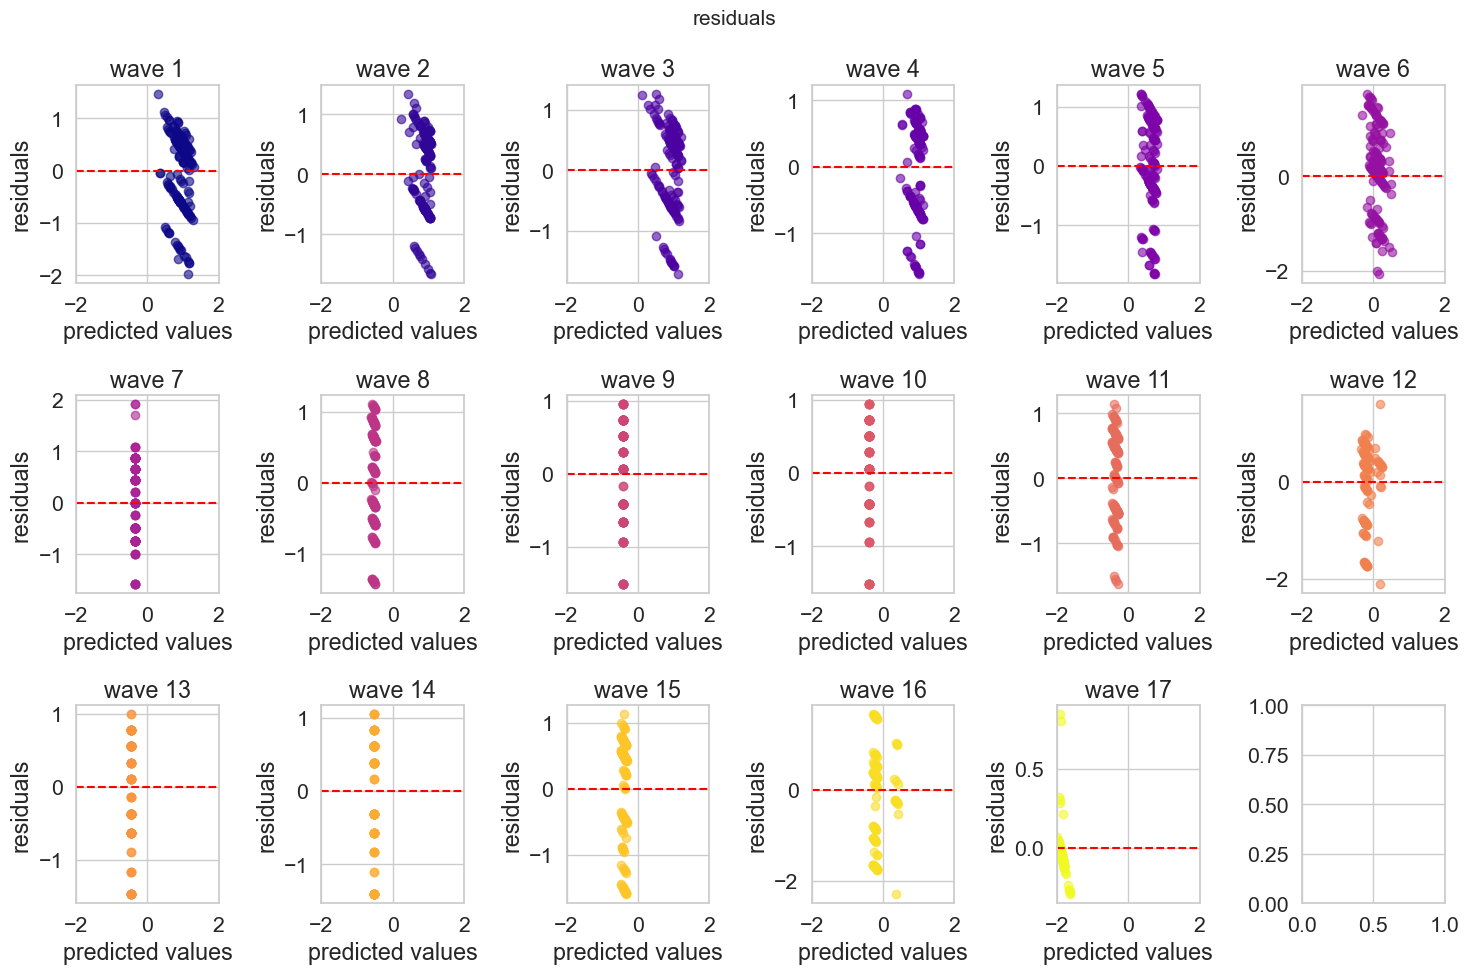

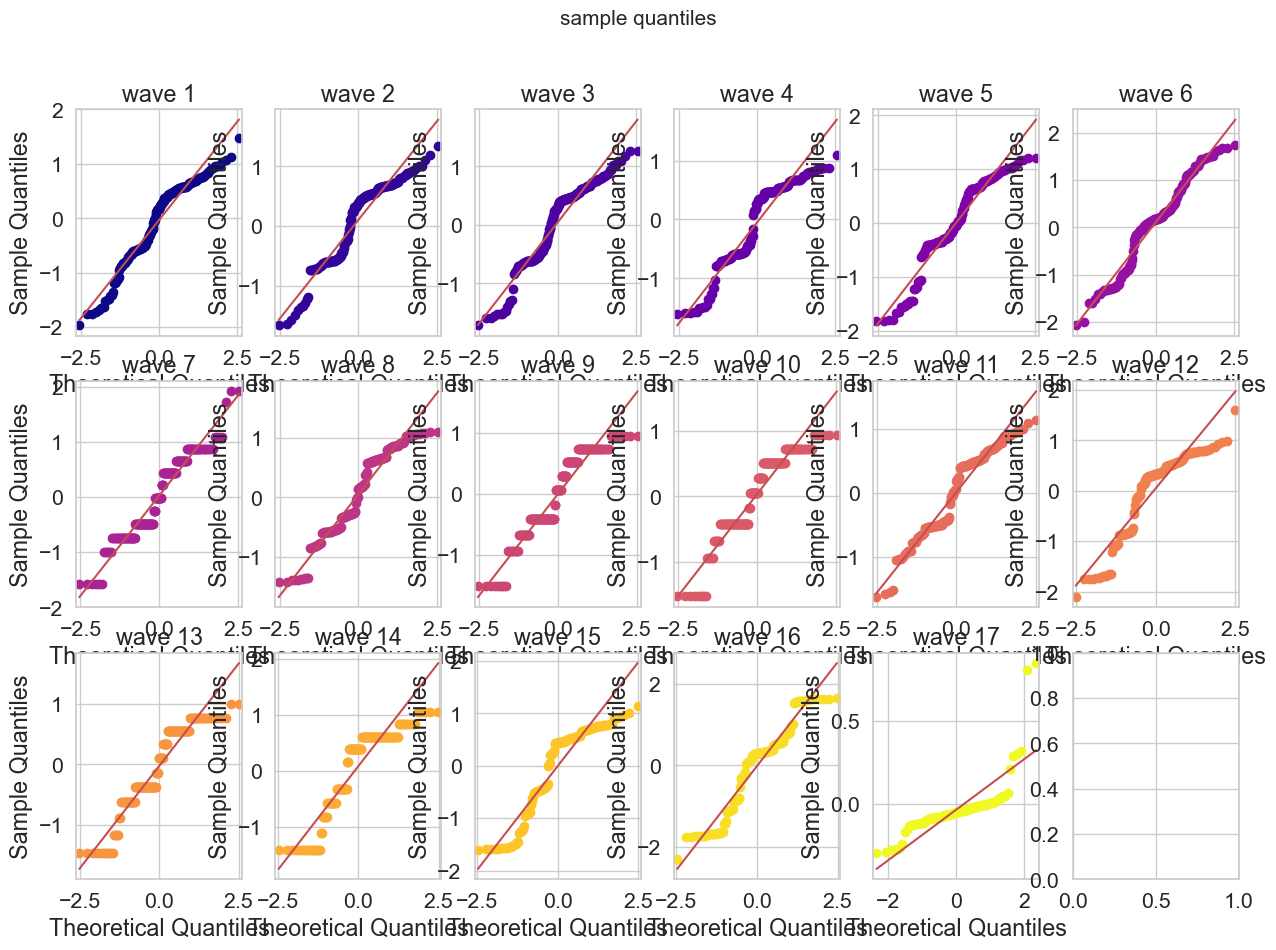

In [29]:
# Load packages
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
import statistics
import warnings

# Suppress a specific warning by message
warnings.filterwarnings('ignore', category=FutureWarning, module='matplotlib')


y_vec = ['cases_avg_per_100k_yeojohnson','ueRate_yeojohnson','restriction_sum_yeojohnson',
        'mean_social_network_health_yeojohnson','weekly_econ_impact_yeojohnson','safety_measures_yeojohnson']



x_lim = [[-2.5, 2.5], [-2.5, 2.5], [-2,2], [-1,1.5],[-2.5,1],[-2.5, 2.5]]


subplot_label = ['A: local context - COVID health', 
                 'B: local context - restriction',
                 'C: local context - economic', 
                 'D: pers. experience - COVID health',
                 'E: pers. experience - restriction',
                 'F: pers. experience - economic']

x_label = ['COVID health', 'restriction', 'economic', 'COVID health', 'restriction', 'economic']


overall_alpha = pd.DataFrame(columns = y_vec)

max_alpha = 0.5

loop_waves = list(range(1,18))
wave_restrict2 = list(range(3,18))
for idx, y_var in enumerate(y_vec):
    
    fig_alpha, ax_alpha = plt.subplots(1,2, figsize=(10, 6))
    fig_alpha.suptitle('Lasso - hyperparameter',  fontsize = 15)
    fig_alpha.text(0, 1.1, subplot_label[idx], verticalalignment='top', horizontalalignment='left',  fontsize = 20)
    fig_alpha.tight_layout()

    rows = 3
    cols = 6
    fig_ydata, ax_ydata = plt.subplots(rows,cols, figsize=(15,10))
    fig_ydata.suptitle('data distribution',  fontsize = 15)

    fig_resid, ax_resid = plt.subplots(rows,cols, figsize=(15,10))
    fig_resid.suptitle('residuals',  fontsize = 15)
    fig_resid.tight_layout()

    fig_resid_normal, ax_resid_normal = plt.subplots(rows,cols, figsize=(15,10))
    fig_resid_normal.suptitle('sample quantiles',  fontsize = 15)

    for wave in loop_waves:    
        row = (wave-1) // cols
        col = (wave-1) % cols
        data_singleWave = data.loc[data.wave == wave,[y_var,
                                                      'ethnicity',
                                                      'race',
                                                      'polit_party',
                                                      'sex',
                                                      'loc_description',
                                                      'age']].reset_index(drop = True)
        

        df = data_singleWave.dropna()
    
        
         # Encode categorical variables into dummy variables
        df_encoded = pd.get_dummies(df, columns=['sex',
                                                 'race',
                                                 'ethnicity',
                                                 'polit_party',
                                                 'loc_description'])


        # Manually set a reference category 
        reference_category_dict = {'sex': 'Male', 'race': 'White', 
                               'ethnicity': 'Not Hispanic or Latino', 'polit_party': 'Democrat', 
                               'loc_description':'countryside'}
        for ref_cat in list(reference_category_dict.keys()):
            df_encoded.drop(columns=ref_cat+'_'+reference_category_dict[ref_cat], inplace=True)
            
        # Split the data into predictors (X) and the target variable (y)
        X = df_encoded.drop(y_var, axis=1)
        y = df_encoded[y_var]


        # Split your data into training, validation, and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create a LassoCV model with a range of alpha values
        alphas = np.linspace(0.000001, max_alpha, 100)

        lasso_cv = LassoCV(alphas = alphas, cv=10)  # Use 10-fold cross-validation

        # Fit the LassoCV model on the training data
        lasso_cv.fit(X_train, y_train)
        
        # Calculate predicted values and residuals for the test dataset
        y_pred = lasso_cv.predict(X_test)
        residuals = y_test - y_pred
        
        # y-data histograms
        ax_ydata[row,col].hist(y, 50, color = wave_colors[wave-1], ec=wave_colors[wave-1]);
        ax_ydata[row,col].set_title('wave '+str(wave))
        ax_ydata[row,col].set_xlabel(x_label[idx])
        ax_ydata[row,col].set_ylabel('count')

        ax_ydata[row,col].set_xlim(x_lim[idx])


        # Plot residuals vs. predicted values
        ax_resid[row,col].scatter(y_pred, residuals, alpha=0.6, color = wave_colors[wave-1])
        ax_resid[row,col].axhline(0, color='red', linestyle='--')
        ax_resid[row,col].set_xlabel('predicted values')       
        ax_resid[row,col].set_ylabel('residuals')
        ax_resid[row,col].grid(True)
        ax_resid[row,col].set_title('wave '+str(wave))
        ax_resid[row,col].set_xlim(x_lim[idx])
        
        # QQ-plots
        sm.qqplot(residuals, line='s', ax = ax_resid_normal[row,col])
        scatter_line = ax_resid_normal[row,col].get_lines()[0]
        scatter_line.set_markerfacecolor(wave_colors[wave-1])
        scatter_line.set_markeredgecolor(wave_colors[wave-1])
        ax_resid_normal[row,col].set_title('wave '+str(wave))
        ax_resid[row,col].set_xlim(x_lim[idx])
        
        # plot wave-specfifc MSE vs alpha values
        ax_alpha[0].plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=1), label='Mean MSE across folds',
                        color = wave_colors[wave-1])

        # Get the optimal alpha value
        optimal_alpha = lasso_cv.alpha_
        # # Fit a Lasso regression model
        lasso = Lasso(alpha=optimal_alpha, max_iter=10000)  # You can adjust the alpha (penalty) parameter
        lasso.fit(X_train, y_train)

        # Predict the target variable on the test set
        y_pred = lasso.predict(X_test)

        # Evaluate the model (you can use different metrics)
        from sklearn.metrics import mean_squared_error, r2_score

        mse = mean_squared_error(y_test, y_pred)
        r_squared = r2_score(y_test, y_pred)

        # coefficients of the Lasso regression model
        coefficients = lasso.coef_

        if wave == loop_waves[0]:
            coef = pd.DataFrame(index = list(X.columns) + ['optimal_alpha', 'MSE', 'R_squared'], columns = loop_waves)
        coef.loc[list(X.columns),wave] = coefficients
        coef.loc['optimal_alpha',wave] = optimal_alpha
        coef.loc['MSE',wave] = mse
        coef.loc['RMSE',wave] = np.sqrt(mse)
        coef.loc['R_squared',wave] = r_squared
        


    
    ax_alpha[0].set_xlabel('α')
    ax_alpha[0].set_ylabel('Mean Squared Error')
    ax_alpha[0].set_title('Model Performance vs. α values')
    ax_alpha[0].grid(True)
    ax_alpha[1].hist(coef.loc['optimal_alpha',:],100);
    #ax_alpha[1].set_xlim(0,0.25)
    ax_alpha[1].set_xlabel('optimal α')
    ax_alpha[1].set_title('optimal α values across waves')
    coef.loc['optimal_alpha',coef.loc['optimal_alpha',:]==max_alpha] = np.nan
    
    mean_alpha = coef.loc['optimal_alpha',:].mean()
    # bin best alpha values
    bins = np.linspace(0, max_alpha, 101)
    binned_data = pd.cut(coef.loc['optimal_alpha',:], bins)
    bin_means = binned_data.apply(lambda x: (x.left + x.right) / 2 if pd.notnull(x) else np.nan)
    mode_alpha = bin_means.mode()[0]
    ax_alpha[1].axvline(x=mode_alpha, color='red', linestyle='--', label=f'mean α: {mean_alpha:.2f}')
    ax_alpha[1].grid(True)
    
    fig_alpha.tight_layout()
    fig_alpha.savefig(os.path.join(fig_dir,'dem_lasso_alpha_' +y_var+ '.png'), dpi=600)

    
    fig_ydata.tight_layout()
    fig_ydata.savefig(os.path.join(fig_dir,'dem_lasso_y_data_' +y_var+ '.png'), dpi=600)

    fig_resid.tight_layout()
    fig_resid.savefig(os.path.join(fig_dir,'dem_lasso_resid_' +y_var+ '.png'), dpi=600)

    fig_resid_normal.tight_layout()
    fig_resid_normal.savefig(os.path.join(fig_dir,'dem_lasso_resid_normal' +y_var+ '.png'), dpi=600)

    

    overall_alpha.loc[0,y_var] = mode_alpha
    coef.to_csv(os.path.join(table_dir,'dem_lasso_wave_specific_alpha_' +y_var+ '.csv'))

   

In [ ]:
fig, ax = plt.subplots(6,1, figsize = (25,40))
    
plot_index_order = ['age_zscore', 
                    'sex_Female',
                    'race_Asian', 'race_Black or African American',
                    'ethnicity_Hispanic or Latino',
                    'polit_party_Independent', 'polit_party_Republican',
                    'loc_description_middle_large_city_dense','loc_description_middle_large_city_spread','loc_description_suburb_large_city',
                    'loc_description_middle_med_city',  'loc_description_suburb_med_city',
                    'loc_description_middle_small_city', 'loc_description_suburb_small_city',
                    'optimal_alpha', 'MSE', 'RMSE','R_squared']

heatmap_ylabel = ['dem. |age', 
                 'dem. | sex - female',
                 'dem. | race - Asian', 'dem. |race - Black/African American',
                 'dem. | ethnicity - Hispanic/Latino',
                 'dem. | polit. party - Independent',  'dem. | polit. party - Republican',
                 'dem. | pop. density - middle large city dense', 'dem. | pop. density - middle large city spread','dem. | pop. density - suburb large city', 
                 'dem. | pop. density - middle med. city','dem. | pop. density - suburb med. city', 
                 'dem. | pop. density | middle small city','dem. | pop. density - suburb small city',
                  'R-squared']
titles = ['COVID health concerns', 'COVID norm agreement', 
           'public restriction importance', 'large gathering restriction importance']

for idx, y_var in enumerate(y_vec):        

        for wave in loop_waves:    
            data_singleWave = data.loc[data.wave == wave,[y_var,
                                                          'ethnicity',
                                                          'race',
                                                          'polit_party',
                                                          'sex',
                                                          'loc_description', 
                                                          'age_zscore']].reset_index(drop = True)

            df = data_singleWave.dropna()

             # Encode categorical variables into dummy variables
            df_encoded = pd.get_dummies(df, columns=['sex',
                                                     'race','ethnicity',
                                                     'polit_party','loc_description'])


            # Manually set a reference category 
            reference_category_dict = {'sex': 'Male', 'race': 'White', 
                                   'ethnicity': 'Not Hispanic or Latino', 'polit_party': 'Democrat', 
                                   'loc_description':'countryside'}
            for ref_cat in list(reference_category_dict.keys()):
                df_encoded.drop(columns=ref_cat+'_'+reference_category_dict[ref_cat], inplace=True)

            # Split the data into predictors (X) and the target variable (y)
            X = df_encoded.drop(y_var, axis=1)
            y = df_encoded[y_var]


            # Get the optimal alpha value
            optimal_alpha = overall_alpha.loc[0,y_var]

            
            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # # Fit a Lasso regression model
            lasso = Lasso(alpha=optimal_alpha)  # You can adjust the alpha (penalty) parameter
            lasso.fit(X_train, y_train)

            # Predict the target variable on the test set
            y_pred = lasso.predict(X_test)

            mse = mean_squared_error(y_test, y_pred)
            r_squared = r2_score(y_test, y_pred)


            # Print the coefficients of the Lasso regression model
            coefficients = lasso.coef_

            if wave == loop_waves[0]:
                coef = pd.DataFrame(index = list(X.columns) + ['optimal_alpha', 'MSE', 'R_squared'], columns = loop_waves)
            coef.loc[list(X.columns),wave] = coefficients
            coef.loc['optimal_alpha',wave] = optimal_alpha
            coef.loc['MSE',wave] = mse
            coef.loc['RMSE',wave] = np.sqrt(mse)
            coef.loc['R_squared',wave] = r_squared

        coef = coef.reindex(plot_index_order)
        coef.to_csv(os.path.join(table_dir,'dem_lasso_' +y_var+ '.csv'))
        coef_to_plot = coef.drop(['MSE', 'RMSE','optimal_alpha'])
        coef_to_plot.loc[:,'mean\nacross waves'] = coef_to_plot.astype(float).mean(axis=1).round(2)        

        annot_array = coef_to_plot.applymap(lambda x: '0' if np.isclose(x, 0, atol=1e-2) else f'{x:.2f}').values
        #annot_array = annot_array.astype(float)
        coef_to_plot.loc[:] =annot_array
        value_idx = coef_to_plot.reset_index(drop=True).index[~(coef_to_plot == 0).all(axis=1)]
        
        #coef_to_plot = coef_to_plot.astype(float)
        coef_to_plot = coef_to_plot.loc[~(coef_to_plot == 0).all(axis=1)]
        rows_to_drop = np.all(annot_array == 0, axis=1)

        # Use boolean indexing to filter out those rows
        annot_array = annot_array[~rows_to_drop]
        
        tmp_labels = pd.Series(heatmap_ylabel)
        tmp_labels = tmp_labels[value_idx].values
        
        sns.heatmap(data = coef_to_plot.astype(float), cmap = 'bwr', vmin = -1, vmax =1,  ax = ax[idx], annot=annot_array, fmt='')
        ax[idx].set_yticklabels(tmp_labels)
        ax[idx].set_xlabel('wave')
        ax[idx].set_title(subplot_label[idx], fontsize = 20)
        
        cbar = ax[idx].collections[0].colorbar

        # Set the label of the colorbar
        cbar.set_label('regression coefficients\nR-squared values')
        
        # box sizes
        label_series = pd.Series(tmp_labels)
        dem_length = label_series.index[label_series.str.startswith('dem')].max()+1
        local_length = label_series.index[label_series.str.startswith('local')].max()-dem_length+1
        pers_length = label_series.index[label_series.str.startswith('pers')].max()-dem_length-local_length+1
        box_width = np.array(loop_waves).max()+1-np.array(loop_waves).min()
        ax[idx].add_patch(
                      patches.Rectangle((0, 0),
                      box_width,dem_length,
                      edgecolor='black',
                      fill=False,
                      lw=2))
        ax[idx].add_patch(
                      patches.Rectangle((0, dem_length),
                      box_width+1,1,
                      edgecolor='black',
                      fill=False,
                      lw=2))
        ax[idx].add_patch(
                      patches.Rectangle((17, 0),
                      1,dem_length+1,
                      edgecolor='black',
                      fill=False,
                      lw=2))
        

plt.tight_layout()
img_format = 'svg'
fig.savefig(os.path.join(fig_dir, 'dem_lasso_local_pers_context.'+ img_format), format=img_format, dpi = 600)






## dems, local and personal context predicting attitudes

In [ ]:
# Suppress a specific warning by message
warnings.filterwarnings('ignore', category=FutureWarning, module='matplotlib')

y_vec = ['cvd_concern_yeojohnson','cvd_norm_agreement_yeojohnson', 'restrict_f1_yeojohnson', 'restrict_f2']
y_vec = ['cvd_concern', 'cvd_norm_agreement_yeojohnson', 'restrict_f1_yeojohnson', 'restrict_f2_yeojohnson']
y_vec = ['cvd_concern', 'cvd_norm_agreement_yeojohnson', 'restrict_f1_yeojohnson']


y_label = ['COVID health\nconcerns', 'COVID norm\nagreement', 
           'public restriction\nimportance', 'large gathering\nrestriction importance']

overall_alpha = pd.DataFrame(columns = y_vec)

max_alpha = 0.5

waves = list(range(1,18))
wave_restrict2 = list(range(3,18))
for idx, y_var in enumerate(y_vec):

    if (y_var == 'restrict_f2') | (y_var == 'restrict_f2_yeojohnson'):
        loop_waves = wave_restrict2
    else:
        loop_waves = waves
    
    fig_alpha, ax_alpha = plt.subplots(1,2, figsize=(10, 6))
    fig_alpha.suptitle(y_label[idx],  fontsize = 15)
    #fig_alpha.text(0.05, 1, 'A', verticalalignment='top', horizontalalignment='left',  fontsize = 20)

    rows = 3
    cols = 6
    fig_ydata, ax_ydata = plt.subplots(rows,cols, figsize=(15,10))
    fig_ydata.suptitle(y_label[idx],  fontsize = 15)
    #fig_ydata.text(0.05, 1, 'B', verticalalignment='top', horizontalalignment='left',  fontsize = 20)

    fig_resid, ax_resid = plt.subplots(rows,cols, figsize=(15,10))
    fig_resid.suptitle(y_label[idx],  fontsize = 15)
    #fig_resid.text(0.05, 1, 'C', verticalalignment='top', horizontalalignment='left',  fontsize = 20)

    fig_resid_normal, ax_resid_normal = plt.subplots(rows,cols, figsize=(15,10))
    fig_resid_normal.suptitle(y_label[idx],  fontsize = 15)
   # fig_resid_normal.text(0.05, 1, 'D', verticalalignment='top', horizontalalignment='left',  fontsize = 20)
    
    for wave in loop_waves:    
        row = (wave-1) // cols
        col = (wave-1) % cols
        data_singleWave = data_zscore.loc[data_zscore.wave == wave,[y_var,
                                                                    'ethnicity',
                                                                    'race',
                                                                    'polit_party',
                                                                    'sex',
                                                                    'loc_description', 
                                                                    'age_zscore',
                                                                    'cases_avg_per_100k',
                                                                    'ueRate',
                                                                    'restriction_sum',
                                                                    'mean_social_network_health',
                                                                    'weekly_econ_impact',
                                                                    'safety_measures']].reset_index(drop = True)
        
        df = data_singleWave.dropna()
    
        
         # Encode categorical variables into dummy variables
        df_encoded = pd.get_dummies(df, columns=['sex',
                                                 'race','ethnicity',
                                                 'polit_party','loc_description'])


        # Manually set a reference category 
        reference_category_dict = {'sex': 'Male', 'race': 'White', 
                               'ethnicity': 'Not Hispanic or Latino', 'polit_party': 'Democrat', 
                               'loc_description':'countryside'}
        for ref_cat in list(reference_category_dict.keys()):
            df_encoded.drop(columns=ref_cat+'_'+reference_category_dict[ref_cat], inplace=True)
            
        # Split the data into predictors (X) and the target variable (y)
        X = df_encoded.drop(y_var, axis=1)
        y = df_encoded[y_var]


        # Split your data into training, validation, and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create a LassoCV model with a range of alpha values
        alphas = np.linspace(0.000001, max_alpha, 1000)

        lasso_cv = LassoCV(alphas = alphas, cv=10)  # Use 10-fold cross-validation

        # Fit the LassoCV model on the training data
        lasso_cv.fit(X_train, y_train)
        
        # Calculate predicted values and residuals for the entire dataset
        y_pred = lasso_cv.predict(X_test)
        residuals = y_test - y_pred
        
        # y-data histograms
        ax_ydata[row,col].hist(y, 50, color = wave_colors[wave-1], ec=wave_colors[wave-1]);
        ax_ydata[row,col].set_title('wave '+str(wave))
        ax_ydata[row,col].set_xlabel(y_label[idx])
        ax_ydata[row,col].set_ylabel('count')


        # Plot residuals vs. predicted values
        ax_resid[row,col].scatter(y_pred, residuals, alpha=0.6, color = wave_colors[wave-1])
        ax_resid[row,col].axhline(0, color='red', linestyle='--')
        ax_resid[row,col].set_xlabel('predicted values')       
        ax_resid[row,col].set_ylabel('residuals')
        ax_resid[row,col].grid(True)
        ax_resid[row,col].set_title('wave '+str(wave))
        
        # QQ-plots
        sm.qqplot(residuals, line='s', ax = ax_resid_normal[row,col])
        scatter_line = ax_resid_normal[row,col].get_lines()[0]
        scatter_line.set_markerfacecolor(wave_colors[wave-1])
        scatter_line.set_markeredgecolor(wave_colors[wave-1])
        ax_resid_normal[row,col].set_title('wave '+str(wave))

        
        # plot wave-specfifc MSE vs alpha values
        ax_alpha[0].plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=1), label='Mean MSE across folds',
                        color = wave_colors[wave-1])

        # Get the optimal alpha value
        optimal_alpha = lasso_cv.alpha_

        # # Fit a Lasso regression model
        lasso = Lasso(alpha=optimal_alpha, max_iter=10000)  # You can adjust the alpha (penalty) parameter
        lasso.fit(X_train, y_train)

        # Predict the target variable on the test set
        y_pred = lasso.predict(X_test)

        # Evaluate the model (you can use different metrics)
        from sklearn.metrics import mean_squared_error, r2_score

        mse = mean_squared_error(y_test, y_pred)
        r_squared = r2_score(y_test, y_pred)

        # coefficients of the Lasso regression model
        coefficients = lasso.coef_

        if wave == loop_waves[0]:
            coef = pd.DataFrame(index = list(X.columns) + ['optimal_alpha', 'MSE', 'R_squared'], columns = loop_waves)
        coef.loc[list(X.columns),wave] = coefficients
        coef.loc['optimal_alpha',wave] = optimal_alpha
        coef.loc['MSE',wave] = mse
        coef.loc['RMSE',wave] = np.sqrt(mse)
        coef.loc['R_squared',wave] = r_squared
        


    
    ax_alpha[0].set_ylabel('Mean Squared Error')
    ax_alpha[0].set_title('Model Performance vs. α values')
    ax_alpha[0].grid(True)
    ax_alpha[1].hist(coef.loc['optimal_alpha',:],10);
    ax_alpha[1].set_xlim(0,max_alpha)
    ax_alpha[1].set_xlabel('optimal α')
    ax_alpha[1].set_title('optimal α values across waves')
    mean_alpha = coef.loc['optimal_alpha',:].mean()
    # bin best alpha values
    bins = np.linspace(0, max_alpha, 101)
    binned_data = pd.cut(coef.loc['optimal_alpha',:], bins)
    bin_means = binned_data.apply(lambda x: (x.left + x.right) / 2 if pd.notnull(x) else np.nan)
    mode_alpha = bin_means.mode()[0]
    ax_alpha[1].axvline(x=mode_alpha, color='red', linestyle='--', label=f'mean α: {mean_alpha:.2f}')
    ax_alpha[1].grid(True)

    fig_alpha.tight_layout()
    fig_ydata.tight_layout()
    fig_resid.tight_layout()
    fig_resid_normal.tight_layout()

    overall_alpha.loc[0,y_var] = coef.loc['optimal_alpha',:].mean()
    coef.to_csv(os.path.join(table_dir,'dem_lasso_wave_specific_alpha_' +y_var+ '.csv'))



In [ ]:
subplot_label = ['A', 'B', 'C', 'D']
fig, ax = plt.subplots(len(y_vec),1, figsize =  (25,28))
    
plot_index_order = ['age_zscore', 
                    'sex_Female',
                    'race_Asian', 'race_Black or African American',
                    'ethnicity_Hispanic or Latino',
                    'polit_party_Independent', 'polit_party_Republican',
                    'loc_description_middle_large_city_dense','loc_description_middle_large_city_spread','loc_description_suburb_large_city',
                    'loc_description_middle_med_city',  'loc_description_suburb_med_city',
                    'loc_description_middle_small_city', 'loc_description_suburb_small_city',
                    'cases_avg_per_100k', 'restriction_sum','ueRate',
                    'mean_social_network_health','safety_measures', 'weekly_econ_impact',
                    'optimal_alpha', 'MSE', 'RMSE','R_squared']

heatmap_ylabel = ['dem. |age', 
                 'dem. | sex - female',
                 'dem. | race - Asian', 'dem. |race - Black/African American',
                 'dem. | ethnicity - Hispanic/Latino',
                 'dem. | polit. party - Independent',  'dem. | polit. party - Republican',
                 'dem. | pop. density - middle large city dense', 'dem. | pop. density - middle large city spread','dem. | pop. density - suburb large city', 
                 'dem. | pop. density - middle med. city','dem. | pop. density - suburb med. city', 
                 'dem. | pop. density | middle small city','dem. | pop. density - suburb small city',
                 'local context | COVID health', 'local context | restrictions', 'local context | economic',
                 'pers. experience| COVID health','pers. behavior | restriction', 'pers. experience | economic',
                 'R-squared']

heatmap_xlabel = list(np.array(range(1,18)).astype(str)) + ['mean\nacross waves']


for idx, y_var in enumerate(y_vec):        
        if (y_var == 'restrict_f2') | (y_var == 'restrict_f2_yeojohnson'):
            loop_waves = wave_restrict2
        else:
            loop_waves = waves

        for wave in loop_waves:    
            data_singleWave = data_zscore.loc[data_zscore.wave == wave,[y_var,
                                                                        'ethnicity',
                                                                        'race',
                                                                        'polit_party',
                                                                        'sex',
                                                                        'loc_description', 
                                                                        'age_zscore',
                                                                        'cases_avg_per_100k','ueRate',
                                                                        'restriction_sum',
                                                                        'mean_social_network_health',
                                                                        'weekly_econ_impact',
                                                                        'safety_measures']].reset_index(drop = True)

            df = data_singleWave.dropna()

             # Encode categorical variables into dummy variables
            df_encoded = pd.get_dummies(df, columns=['sex',
                                                     'race','ethnicity',
                                                     'polit_party','loc_description'])


            # Manually set a reference category 
            reference_category_dict = {'sex': 'Male', 'race': 'White', 
                                   'ethnicity': 'Not Hispanic or Latino', 'polit_party': 'Democrat', 
                                   'loc_description':'countryside'}
            for ref_cat in list(reference_category_dict.keys()):
                df_encoded.drop(columns=ref_cat+'_'+reference_category_dict[ref_cat], inplace=True)

            # Split the data into predictors (X) and the target variable (y)
            X = df_encoded.drop(y_var, axis=1)
            y = df_encoded[y_var]


            # Get the optimal alpha value
            optimal_alpha = overall_alpha.loc[0,y_var]
            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # # Fit a Lasso regression model
            lasso = Lasso(alpha=optimal_alpha)  # You can adjust the alpha (penalty) parameter
            lasso.fit(X_train, y_train)

            # Predict the target variable on the test set
            y_pred = lasso.predict(X_test)

            mse = mean_squared_error(y_test, y_pred)
            r_squared = r2_score(y_test, y_pred)


            # Print the coefficients of the Lasso regression model
            coefficients = lasso.coef_

            if wave == loop_waves[0]:
                coef = pd.DataFrame(index = list(X.columns) + ['optimal_alpha', 'MSE', 'R_squared'], columns = loop_waves)
            coef.loc[list(X.columns),wave] = coefficients
            coef.loc['optimal_alpha',wave] = optimal_alpha
            coef.loc['MSE',wave] = mse
            coef.loc['RMSE',wave] = np.sqrt(mse)
            coef.loc['R_squared',wave] = r_squared

        coef = coef.reindex(plot_index_order)
        coef.to_csv(os.path.join(table_dir,'dem_lasso_' +y_var+ '.csv'))
        coef_to_plot = coef.drop(['MSE', 'RMSE','optimal_alpha'])
        coef_to_plot.loc[:,'mean\nacross waves'] = coef_to_plot.astype(float).mean(axis=1).round(2)        
        annot_array = coef_to_plot.applymap(lambda x: '0' if np.isclose(x, 0, atol=1e-2) else f'{x:.2f}').values
        coef_to_plot.loc[:] =annot_array
        value_idx = coef_to_plot.reset_index(drop=True).index[~(coef_to_plot == 0).all(axis=1)]
        
        tmp_labels = pd.Series(heatmap_ylabel)
        tmp_labels = tmp_labels[value_idx].values
        
#         print()
#         print(y_label[idx])
#         print('mean')
#         print(coef_to_plot.astype(float).mean(axis = 1))
#         print('min')
#         print(coef_to_plot.astype(float).min(axis = 1))
#         print('max')
#         print(coef_to_plot.astype(float).max(axis = 1))
        
        
        sns.heatmap(data = coef_to_plot.astype(float), cmap = 'bwr', vmin = -1, vmax =1,  ax = ax[idx], annot=annot_array, fmt='')
        ax[idx].set_yticklabels(tmp_labels)
        ax[idx].set_xlabel('wave')
        ax[idx].set_title(y_label[idx], fontsize = 20)
        
        cbar = ax[idx].collections[0].colorbar

        # Set the label of the colorbar
        cbar.set_label('regression coefficients\nR-squared values')
        
        # box sizes
        label_series = pd.Series(tmp_labels)
        dem_length = label_series.index[label_series.str.startswith('dem')].max()+1
        local_length = label_series.index[label_series.str.startswith('local')].max()-dem_length+1
        pers_length = label_series.index[label_series.str.startswith('pers')].max()-dem_length-local_length+1
        box_width = np.array(loop_waves).max()+1-np.array(loop_waves).min()+1
        ax[idx].add_patch(
                      patches.Rectangle((0, 0),
                      box_width,dem_length,
                      edgecolor='black',
                      fill=False,
                      lw=2))
        ax[idx].add_patch(
                      patches.Rectangle((0, dem_length),
                      box_width,local_length,
                      edgecolor='black',
                      fill=False,
                      lw=2))
        ax[idx].add_patch(
                      patches.Rectangle((0, dem_length+local_length),
                      box_width,pers_length,
                      edgecolor='black',
                      fill=False,
                      lw=2))
        ax[idx].add_patch(
                      patches.Rectangle((0, dem_length+local_length+pers_length),
                      box_width,1,
                      edgecolor='black',
                      fill=False,
                      lw=2))
        if y_var == 'restrict_f2_yeojohnson':
            ax[idx].add_patch(
                          patches.Rectangle((15, 0),
                          1,dem_length+local_length+pers_length+1,
                          edgecolor='black',
                          fill=False,
                          lw=2))
        else: 
            ax[idx].add_patch(
                      patches.Rectangle((17, 0),
                      1,dem_length+local_length+pers_length+1,
                      edgecolor='black',
                      fill=False,
                      lw=2))
        
        ax[idx].text(-1.5, -1, subplot_label[idx], verticalalignment='top', horizontalalignment='left',  fontsize = 20)

        
        #ax[idx].tick_params(axis='x', labelrotation=20)
        ax[idx].xaxis.set_label_coords(0.5, -.06)

        #fig.tight_layout()
        img_format = 'svg'
        fig.savefig(os.path.join(fig_dir, 'dem_lasso_' +y_var +'.'+ img_format), format=img_format)






# Visualize attitude differences in demographic groups

In [ ]:
# y_vec = ['cvd_concern', 'cvd_norm_agreement', 'restrict_f1', 'restrict_f2']
# y_label = ['COVID health concern', 'COVID norm agreement', 'public restriction importance', 'large gathering restriction importance']

y_vec = ['cvd_concern', 'cvd_norm_agreement', 'restrict_f1']
y_label = ['COVID health concern', 'COVID norm agreement', 'public restriction importance']
subplot_labels = ['A', 'B', 'C', 'D']
ylims = [[1,5], [1,5], [1,4], [1,4]]
fig, axs = plt.subplots(1,3,figsize = (22,7))
axs_flat = axs.flatten()
x_ticks = data.week.unique()
x_tick_labels = data.wave.unique()
for idx, y in enumerate(y_vec):
    sns.lineplot(data = data.loc[data.polit_party.isin(['Republican', 'Democrat', 'Independent'])],
                 x = 'week', y = y, hue = 'polit_party', ax = axs_flat[idx],
                 palette=['b','r','orange'], linewidth = 2)
    axs_flat[idx].set_xticks(x_ticks)
    axs_flat[idx].set_xticklabels(x_tick_labels)
    axs_flat[idx].set_ylabel(y_label[idx])
    axs_flat[idx].set_xlabel('wave')

    axs_flat[idx].set_xlim([0,70])
    axs_flat[idx].set_ylim(ylims[idx])
    axs_flat[idx].text(-0.1, 1.15, subplot_labels[idx], transform=axs_flat[idx].transAxes,
               fontsize=20, va='top', ha='right')
    axs_flat[idx].legend(title='polit. party')


fig.tight_layout()

In [ ]:
# y_vec = ['cvd_concern', 'cvd_norm_agreement', 'restrict_f1', 'restrict_f2']
# y_label = ['COVID health concern', 'COVID norm agreement', 'public restriction importance', 'large gathering restriction importance']

y_vec = ['cvd_concern', 'cvd_norm_agreement', 'restrict_f1']
y_label = ['COVID health concern', 'COVID norm agreement', 'public restriction importance']

subplot_labels = ['A', 'B', 'C', 'D']
ylims = [[1,5], [1,5], [1,4], [1,4]]
fig, axs = plt.subplots(1,3,figsize = (22,7))
axs_flat = axs.flatten()
x_ticks = data.week.unique()
x_tick_labels = data.wave.unique()
for idx, y in enumerate(y_vec):
    sns.lineplot(data = data.loc[data.sex.isin(['Male', 'Female'])],
                 x = 'week', y = y, hue = 'sex', ax = axs_flat[idx],
                 palette=['b', 'r'], linewidth = 2)
    axs_flat[idx].set_xticks(x_ticks)
    axs_flat[idx].set_xticklabels(x_tick_labels)
    axs_flat[idx].set_ylabel(y_label[idx])
    axs_flat[idx].set_xlabel('wave')

    axs_flat[idx].set_xlim([0,70])
    axs_flat[idx].set_ylim(ylims[idx])
    axs_flat[idx].text(-0.1, 1.15, subplot_labels[idx], transform=axs_flat[idx].transAxes,
               fontsize=20, va='top', ha='right')


fig.tight_layout()

In [ ]:
# y_vec = ['cvd_concern', 'cvd_norm_agreement', 'restrict_f1', 'restrict_f2']
# y_label = ['COVID health concern', 'COVID norm agreement', 'public restriction importance', 'large gathering restriction importance']

y_vec = ['cvd_concern', 'cvd_norm_agreement', 'restrict_f1']
y_label = ['COVID health concern', 'COVID norm agreement', 'public restriction importance']

hue_order = ['age18_24','age25_29','age30_34','age35_39',
             'age40_44','age45_49','age50_54','age55_59','age60_100']
subplot_labels = ['A', 'B', 'C', 'D']
ylims = [[2.2,3.6], [3,5], [2.5,4], [3.1,4]]
fig, axs = plt.subplots(1,3,figsize = (22,7))
axs_flat = axs.flatten()
x_ticks = data.week.unique()
x_tick_labels = data.wave.unique()
for idx, y in enumerate(y_vec):
    sns.lineplot(data = data,x = 'week', y = y, hue = 'agecats', ax = axs_flat[idx],
                 linewidth = 2, palette = 'Spectral',hue_order =hue_order )
    axs_flat[idx].set_xticks(x_ticks)
    axs_flat[idx].set_xticklabels(x_tick_labels)
    axs_flat[idx].set_ylabel(y_label[idx])
    axs_flat[idx].set_xlim([0,70])
    axs_flat[idx].set_ylim(ylims[idx])
    axs_flat[idx].text(-0.1, 1.15, subplot_labels[idx], transform=axs_flat[idx].transAxes,
               fontsize=20, va='top', ha='right')     
    axs_flat[idx].set_xlabel('wave')

    

handles, labels = axs_flat[2].get_legend_handles_labels()
filtered_handles = handles[1:len(labels)+1]  # Adjust index to ognore shaded error regions
new_labels = ['18-25', '25-29', '30-34','35-39', '40-44','45-49','50-54','55-59','60-100']
axs_flat[0].legend(handles=filtered_handles,title='age', loc='upper left', bbox_to_anchor=(-0.4, 1), labels = new_labels)

axs_flat[1].get_legend().remove()
axs_flat[2].get_legend().remove()
#axs_flat[3].get_legend().remove()



fig.tight_layout()

In [ ]:
# y_vec = ['cvd_concern', 'cvd_norm_agreement', 'restrict_f1', 'restrict_f2']
# y_label = ['COVID health concern', 'COVID norm agreement', 'public restriction importance', 'large gathering restriction importance']

y_vec = ['cvd_concern', 'cvd_norm_agreement', 'restrict_f1']
y_label = ['COVID health concern', 'COVID norm agreement', 'public restriction importance']

subplot_labels = ['A', 'B', 'C', 'D']
ylims = [[1,5], [1,5], [1,4], [1,4]]
fig, axs = plt.subplots(1,3,figsize = (22,7))
axs_flat = axs.flatten()
x_ticks = data.week.unique()
x_tick_labels = data.wave.unique()

hue_order = ['countryside', 
             'suburb_small_city', 'middle_small_city',
             'suburb_med_city', 'middle_med_city',
             'suburb_large_city', 'middle_large_city_spread', 'middle_large_city_dense']


for idx, y in enumerate(y_vec):
    sns.lineplot(data = data.loc[data.loc_description.isin(hue_order)],
                 x = 'week', y = y, hue = 'loc_description', ax = axs_flat[idx], hue_order = hue_order,
                 palette='Spectral', linewidth = 2)
    axs_flat[idx].set_xticks(x_ticks)
    axs_flat[idx].set_xticklabels(x_tick_labels)
    axs_flat[idx].set_ylabel(y_label[idx])
    axs_flat[idx].set_xlim([0,70])
    #axs_flat[idx].set_ylim(ylims[idx])
    axs_flat[idx].text(-0.1, 1.15, subplot_labels[idx], transform=axs_flat[idx].transAxes,
               fontsize=20, va='top', ha='right')
    axs_flat[idx].set_xlabel('wave')

    
    handles, labels = axs_flat[2].get_legend_handles_labels()
    filtered_handles = handles[1:len(labels)+1]  # Adjust index to ognore shaded error regions
    new_labels = ['countryside', 
                  'suburb small city', 'middle small city',
                  'suburb med. city', 'middle med. city',
                  'suburb large city', 'middle large\ncity - spread', 'middle large\ncity - dense']
axs_flat[0].legend(handles=filtered_handles,title='age', loc='upper left', bbox_to_anchor=(-0.5, 1), labels = new_labels)

axs_flat[1].get_legend().remove()
axs_flat[2].get_legend().remove()
#axs_flat[3].get_legend().remove()


fig.tight_layout()

# Visualize demographic variable interactions

## Restrictions

In [ ]:
###### sex assigned at birth #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Sex Assigned at Birth', fontsize=16)

# sort data for plotting
custom_dict = {'Male': 0, 'Female': 1}
data = data.sort_values(by=['sex'], key=lambda x: x.map(custom_dict))

# local restrictions
sns.lineplot(data = data.loc[data.sex.isin(['Male', 'Female'])],
             y = 'restriction_sum', x = 'sex',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nRestrictions (a.u.)')
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

# personal restriction behavior
sns.lineplot(data = data.loc[data.sex.isin(['Male', 'Female'])],
             y = 'safety_measures', x = 'sex',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Behavior\nRestrictions (a.u.)')
ax[1].grid()
ax[1].set_xlabel('')


In [ ]:
###### ethnicity #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Ethnicity', fontsize=16)

# Ethnicity: prefer not to disclose N = 6-> drop from visualization
# sort data for plotting
custom_dict = {'Hispanic or Latino': 0, 'Not Hispanic or Latino': 1}
data = data.sort_values(by=['ethnicity'], key=lambda x: x.map(custom_dict))

# local restrictions
sns.lineplot(data = data.loc[data.ethnicity.isin(['Hispanic or Latino', 'Not Hispanic or Latino'])],
             y = 'restriction_sum', x = 'ethnicity',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nRestrictions (a.u.)')
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

# personal restriction behavior
sns.lineplot(data = data.loc[data.ethnicity.isin(['Hispanic or Latino', 'Not Hispanic or Latino'])],
             y = 'safety_measures', x = 'ethnicity',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Behavior\nRestrictions (a.u.)')
ax[1].grid()
ax[1].set_xlabel('')


In [ ]:
###### race #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Race', fontsize=16)

# Sample includes only 2 Native americans and 1 Pacific Islander, so we're exluding these groups from further analysis 
race_to_include = ['White', 'Asian', 'Black or African American', 'Multiracial', 'Other']
data.loc[data.race.isin(['Prefer not to disclose',
       'Native Hawaiian or Other Pacific Islander',
       'American Indian/Alaska Native']),'race'] = 'Other'
data = data.sort_values(by='race')

# local retsrictions
sns.lineplot(data = data,
             y = 'restriction_sum', x = 'race',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nRestrictions (a.u.)')
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

# personal restriction behavior
sns.lineplot(data = data,
             y = 'safety_measures', x = 'race',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Behavior\nRestrictions (a.u.)')
ax[1].grid()
ax[1].set_xlabel('')



In [ ]:
###### age #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Age Group', fontsize=16)



data['agecat_numeric'] = data['agecats']
data['agecat_numeric'] = data['agecat_numeric'].replace(agecat_numeric_dict)

# local restrictions
sns.lineplot(data = data,
             y = 'restriction_sum', x = 'agecat_numeric',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nRestrictions (a.u.)')
ax[0].set_xticks(ticks = list(agecat_numeric_dict.values()), labels = list(agecat_numeric_dict.keys()));
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

# personal restriction behavior
sns.lineplot(data = data,
             y = 'safety_measures', x = 'agecat_numeric',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Behavior\nRestrictions (a.u.)')
ax[1].set_xticks(ticks = list(agecat_numeric_dict.values()), labels = list(agecat_numeric_dict.keys()));
ax[1].grid()
ax[1].set_xlabel('')



In [ ]:
###### Political Party #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Political Party', fontsize=16)

data = data.sort_values(by='polit_party')
custom_dict = {'Democrat': 0, 'Independent': 1,'Republican': 2,'Other': 3  }
data = data.sort_values(by=['polit_party'], key=lambda x: x.map(custom_dict))

# local restrictions
sns.lineplot(data = data,
             y = 'restriction_sum', x = 'polit_party',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nRestrictions (a.u.)')
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

# personal restriction behavior
sns.lineplot(data = data,
             y = 'safety_measures', x = 'polit_party',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Behavior\nRestrictions (a.u.)')
ax[1].grid()
ax[1].set_xlabel('')



In [ ]:
###### Population Density #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Population Density', fontsize=16)

custom_dict = {'countryside': 0, 'suburb_small_city': 1,'middle_small_city':2,
               'suburb_med_city': 3,'middle_med_city':4,
               'suburb_large_city':5,'middle_large_city_spread':6, 'middle_large_city_dense':7 }
data = data.sort_values(by=['loc_description'], key=lambda x: x.map(custom_dict))

# Local restrictions
sns.lineplot(data = data,
             y = 'restriction_sum', x = 'loc_description',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nRestrictions (a.u.)')
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

# personal restriction behavior
sns.lineplot(data = data,
             y = 'safety_measures', x = 'loc_description',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Behavior\nRestrictions (a.u.)')
ax[1].grid()
ax[1].set_xlabel('')



## COVID HEALTH

In [ ]:
###### Sex Assigned at Birth #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Sex Assigned at Birth', fontsize=16)


# sort data for plotting
custom_dict = {'Male': 0, 'Female': 1}
data = data.sort_values(by=['sex'], key=lambda x: x.map(custom_dict))

# local COVID cases
sns.lineplot(data = data.loc[data.sex.isin(['Male', 'Female'])],
             y = 'cases_avg_per_100k_yeojohnson', x = 'sex',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nCOVID Health (COVID cases per 100k (log-scaled))')
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

# personal Covid Health Impact
sns.lineplot(data = data.loc[data.sex.isin(['Male', 'Female'])],
             y = 'mean_social_network_health', x = 'sex',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Experience\nCOVID Health (social network impact)')
ax[1].set_xlabel('')



In [ ]:
###### Ethnicity #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Ethnicity', fontsize=16)


# Ethnicity: prefer not to disclose N = 6-> drop from visualization
# sort data for plotting
custom_dict = {'Hispanic or Latino': 0, 'Not Hispanic or Latino': 1}
data = data.sort_values(by=['ethnicity'], key=lambda x: x.map(custom_dict))

# local COVID cases
sns.lineplot(data = data.loc[data.ethnicity.isin(['Hispanic or Latino', 'Not Hispanic or Latino'])],
             y = 'cases_avg_per_100k_yeojohnson', x = 'ethnicity',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nCOVID Health (COVID cases per 100k (log-scaled))')
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)


sns.lineplot(data = data.loc[data.ethnicity.isin(['Hispanic or Latino', 'Not Hispanic or Latino'])],
             y = 'mean_social_network_health', x = 'ethnicity',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Experience\nCOVID Health (social network impact)')
ax[1].grid()
ax[1].set_xlabel('')



In [ ]:
###### Race #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Race', fontsize=16)

data = data.sort_values(by='race')

# local COVID cases
sns.lineplot(data = data, y = 'cases_avg_per_100k_yeojohnson', x = 'race',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nCOVID Health (COVID cases per 100k (log-scaled))')
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

sns.lineplot(data = data, y = 'mean_social_network_health', x = 'race',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Experience\nCOVID Health (social network impact)')
ax[1].grid()
ax[1].set_xlabel('')


In [ ]:
###### Age Group #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Age Group', fontsize=16)

data['agecat_numeric'] = data['agecats']
data['agecat_numeric'] = data['agecat_numeric'].replace(agecat_numeric_dict)


# local COVID cases
sns.lineplot(data = data, y = 'cases_avg_per_100k_yeojohnson', x = 'agecat_numeric',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nCOVID Health (COVID cases per 100k (log-scaled))')
ax[0].set_xticks(ticks = list(agecat_numeric_dict.values()), labels = list(agecat_numeric_dict.keys()));
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)


sns.lineplot(data = data, y = 'mean_social_network_health', x = 'agecat_numeric',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Experience\nCOVID Health (social network impact)')
ax[1].set_xticks(ticks = list(agecat_numeric_dict.values()), labels = list(agecat_numeric_dict.keys()));
ax[1].grid()
ax[1].set_xlabel('')


In [ ]:
###### Political Party #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Political Party', fontsize=16)

data = data.sort_values(by='polit_party')
custom_dict = {'Democrat': 0, 'Independent': 1,'Republican': 2,'Other': 3  }
data = data.sort_values(by=['polit_party'], key=lambda x: x.map(custom_dict))


# local COVID cases
sns.lineplot(data = data, y = 'cases_avg_per_100k_yeojohnson', x = 'polit_party',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nCOVID Health (COVID cases per 100k (log-scaled))')
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)


sns.lineplot(data = data, y = 'mean_social_network_health', x = 'polit_party',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Experience\nCOVID Health (social network impact)')
ax[1].grid()
ax[1].set_xlabel('')


In [ ]:
###### Population Density #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Population Density', fontsize=16)


custom_dict = {'countryside': 0, 'suburb_small_city': 1,'middle_small_city':2,
               'suburb_med_city': 3,'middle_med_city':4,
               'suburb_large_city':5,'middle_large_city_spread':6, 'middle_large_city_dense':7 }
data = data.sort_values(by=['loc_description'], key=lambda x: x.map(custom_dict))


# local COVID cases
sns.lineplot(data = data, y = 'cases_avg_per_100k_yeojohnson', x = 'loc_description',
             hue = 'wave',palette = "Spectral",  ax = ax[0])
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nCOVID Health (COVID cases per 100k (log-scaled))')
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)


sns.lineplot(data = data, y = 'mean_social_network_health', x = 'loc_description',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Experience\nCOVID Health (social network impact)')
ax[1].grid()
ax[1].set_xlabel('')


## ECONOMIC IMPACT

In [ ]:
colormap = sns.cubehelix_palette(as_cmap=True)
cat_colors = [colormap(0), colormap(50),
            colormap(100), colormap(150),
            colormap(200), colormap(250)]

In [ ]:
###### Sex Assigned at Birth #####

fig, axd = plt.subplot_mosaic([['left', 0],
                               ['left', 1]],
                              figsize=(10,7), layout="constrained")
fig.suptitle('Sex Assigned at Birth', fontsize=16)
colormap = plt.cm.get_cmap('Set2')


# local COVID cases
sns.lineplot(data = data.loc[data.sex.isin(['Male', 'Female'])],
             y = 'ueRate', x = 'sex',
             hue = 'wave',palette = "Spectral",  ax = axd['left'], legend='full')
plt.setp(axd['left'].get_xticklabels(), rotation=90, ha="right");
axd['left'].set_ylabel('Local Context\n Economic Impact (Unemployment Rate (%))')
axd['left'].grid()
axd['left'].set_xlabel('')
leg = axd['left'].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)


data_tmp = data.loc[data.sex.isin(['Male']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_male = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.sex.isin(['Female']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_female = income_counts.div(income_counts.sum(axis=1), axis=0) 


# Male
axd[0].stackplot(income_percentages_male.index,
                income_percentages_male['<$250'], income_percentages_male['$250 - $499'],
                income_percentages_male['$500 - $999'], income_percentages_male['$1000 -$1499'],
                income_percentages_male['$1500 - $2999'], income_percentages_male['>$3000'], 
                colors=cat_colors, zorder=1)
 

# Show grid lines on top by setting a high zorder
axd[0].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[0].set_title('Male')
axd[0].set_ylim([0,1])
axd[0].set_xlim([1,17])
axd[0].set_ylabel('Pers. Experience\n Economic Impact (% income category)')
axd[0].set_xlabel('wave')

# Female
axd[1].stackplot(income_percentages_female.index,
                income_percentages_female['<$250'], income_percentages_female['$250 - $499'],
                income_percentages_female['$500 - $999'], income_percentages_female['$1000 -$1499'],
                income_percentages_female['$1500 - $2999'], income_percentages_female['>$3000'], 
                colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[1].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[1].set_title('Female')
axd[1].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

axd[1].set_ylim([0,1])
axd[1].set_xlim([1,17])
axd[1].set_xlabel('wave')


In [ ]:
###### Ethnicity #####

fig, axd = plt.subplot_mosaic([['left', 0],
                               ['left', 1]],
                              figsize=(10,7), layout="constrained")
fig.suptitle('Ethnicity', fontsize=16)
colormap = plt.cm.get_cmap('Set2')

# Ethnicity: prefer not to disclose N = 6-> drop from visualization
# sort data for plotting
custom_dict = {'Hispanic or Latino': 0, 'Not Hispanic or Latino': 1}
data = data.sort_values(by=['ethnicity'], key=lambda x: x.map(custom_dict))

# local COVID cases
sns.lineplot(data = data.loc[data.ethnicity.isin(['Hispanic or Latino', 'Not Hispanic or Latino'])],
             y = 'ueRate', x = 'ethnicity',
             hue = 'wave',palette = "Spectral",  ax = axd['left'], legend='full')
plt.setp(axd['left'].get_xticklabels(), rotation=90, ha="right");
axd['left'].set_ylabel('Local Context\n Economic Impact (Unemployment Rate (%))')
axd['left'].grid()
axd['left'].set_xlabel('')
leg = axd['left'].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

data_tmp = data.loc[data.ethnicity.isin(['Hispanic or Latino']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_hisp = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.ethnicity.isin(['Not Hispanic or Latino']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_not_hisp = income_counts.div(income_counts.sum(axis=1), axis=0) 
tmp_perc_data = income_percentages_not_hisp


# Hispanic or Latino
axd[0].stackplot(income_percentages_hisp.index,
                income_percentages_hisp['<$250'], income_percentages_hisp['$250 - $499'],
               income_percentages_hisp['$500 - $999'], income_percentages_hisp['$1000 -$1499'],
               income_percentages_hisp['$1500 - $2999'], income_percentages_hisp['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[0].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[0].set_title('Hispanic or Latino')
axd[0].set_ylim([0,1])
axd[0].set_xlim([1,17])
axd[0].set_ylabel('Pers. Experience\n Economic Impact (% income category)')
axd[0].set_xlabel('wave')

# Not Hispanic or Latino
axd[1].stackplot(income_percentages_not_hisp.index,
                income_percentages_not_hisp['<$250'], income_percentages_not_hisp['$250 - $499'],
               income_percentages_not_hisp['$500 - $999'], income_percentages_not_hisp['$1000 -$1499'],
               income_percentages_not_hisp['$1500 - $2999'], income_percentages_not_hisp['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[1].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[1].set_title('Not Hispanic or Latino')
axd[1].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

axd[1].set_ylim([0,1])
axd[1].set_xlim([1,17])
axd[1].set_xlabel('wave')


In [ ]:
###### Race #####

fig, axd = plt.subplot_mosaic([['left', 0],
                               ['left', 1],
                               ['left', 2]],
                              figsize=(10,10), layout="constrained")
fig.suptitle('Race', fontsize=16)

# sort data for plotting
data = data.sort_values(by=['race'])

sns.lineplot(data = data,
             y = 'ueRate', x = 'race',
             hue = 'wave',palette = "Spectral",  ax = axd['left'], legend='full')
plt.setp(axd['left'].get_xticklabels(), rotation=90, ha="right");
axd['left'].set_ylabel('Local Context\n Economic Impact (Unemployment Rate (%))')

data_tmp = data.loc[data.race.isin(['Asian']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_asian = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.race.isin(['Black or African American']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_black = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.race.isin(['White']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_white = income_counts.div(income_counts.sum(axis=1), axis=0) 
axd['left'].grid()
axd['left'].set_xlabel('')
leg = axd['left'].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

# Asian
axd[0].stackplot(income_percentages_asian.index,
                income_percentages_asian['<$250'], income_percentages_asian['$250 - $499'],
               income_percentages_asian['$500 - $999'], income_percentages_asian['$1000 -$1499'],
               income_percentages_asian['$1500 - $2999'], income_percentages_asian['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[0].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[0].set_title('Asian')
axd[0].set_ylim([0,1])
axd[0].set_xlabel('wave')
axd[0].set_xlim([1,17])
axd[0].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

# Black
axd[1].stackplot(income_percentages_black.index,
                income_percentages_black['<$250'], income_percentages_black['$250 - $499'],
               income_percentages_black['$500 - $999'], income_percentages_black['$1000 -$1499'],
               income_percentages_black['$1500 - $2999'], income_percentages_black['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[1].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[1].set_title('Black')
axd[1].set_ylabel('Pers. Experience\n Economic Impact (% income category)')
axd[1].set_xlabel('wave')
axd[1].set_ylim([0,1])
axd[1].set_xlim([1,17])

# White
axd[2].stackplot(income_percentages_white.index,
                income_percentages_white['<$250'], income_percentages_white['$250 - $499'],
               income_percentages_white['$500 - $999'], income_percentages_white['$1000 -$1499'],
               income_percentages_white['$1500 - $2999'], income_percentages_white['>$3000'], 
               colors=cat_colors, zorder=1)

# Show grid lines on top by setting a high zorder
axd[2].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[2].set_title('White')
axd[2].set_ylabel('Pers. Experience\n Economic Impact (% income category)')
axd[2].set_xlabel('wave')
axd[2].set_ylim([0,1])
axd[2].set_xlim([1,17])

In [ ]:
###### Political Party #####

fig, axd = plt.subplot_mosaic([['left', 0],
                              ['left', 1],
                              ['left', 2]],
                              figsize=(10,7), layout="constrained")
fig.suptitle('Political Party', fontsize=16)


# sort data for plotting
data = data.sort_values(by='polit_party')
custom_dict = {'Democrat': 0, 'Independent': 1,'Republican': 2,'Other': 3  }
data = data.sort_values(by=['polit_party'], key=lambda x: x.map(custom_dict))

# local COVID cases
sns.lineplot(data = data,
             y = 'ueRate', x = 'polit_party',
             hue = 'wave',palette = "Spectral",  ax = axd['left'], legend='full')
plt.setp(axd['left'].get_xticklabels(), rotation=90, ha="right");
axd['left'].set_ylabel('Local Context\n Economic Impact (Unemployment Rate (%))')

data_tmp = data.loc[data.polit_party.isin(['Democrat']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_dem = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.polit_party.isin(['Independent']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_indep = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.polit_party.isin(['Republican']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_repu = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.polit_party.isin(['Other']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_other = income_counts.div(income_counts.sum(axis=1), axis=0) 
axd['left'].grid()
axd['left'].set_xlabel('')
leg = axd['left'].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

# Democrat
axd[0].stackplot(income_percentages_dem.index,
                income_percentages_dem['<$250'], income_percentages_dem['$250 - $499'],
               income_percentages_dem['$500 - $999'], income_percentages_dem['$1000 -$1499'],
               income_percentages_dem['$1500 - $2999'], income_percentages_dem['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[0].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[0].set_title('Democrat')
axd[0].set_ylim([0,1])
axd[0].set_xlim([1,17])
axd[0].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

# Independent
axd[1].stackplot(income_percentages_indep.index,
                income_percentages_indep['<$250'], income_percentages_indep['$250 - $499'],
               income_percentages_indep['$500 - $999'], income_percentages_indep['$1000 -$1499'],
               income_percentages_indep['$1500 - $2999'], income_percentages_indep['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[1].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[1].set_title('Independent')
axd[1].set_ylim([0,1])
axd[1].set_xlim([1,17])
axd[1].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

# Republican
axd[2].stackplot(income_percentages_repu.index,
                income_percentages_repu['<$250'], income_percentages_repu['$250 - $499'],
               income_percentages_repu['$500 - $999'], income_percentages_repu['$1000 -$1499'],
               income_percentages_repu['$1500 - $2999'], income_percentages_repu['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[2].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[2].set_title('Republican')
axd[2].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

axd[2].set_ylim([0,1])
axd[2].set_xlim([1,17])


In [ ]:
###### Population Density #####

fig, axd = plt.subplot_mosaic([['left', 0],
                              ['left', 1],
                              ['left', 2],
                              ['left', 3]],
                              figsize=(10,10), layout="constrained")
fig.suptitle('Population Density', fontsize=16)


# sort data for plotting
custom_dict = {'countryside': 0, 'suburb_small_city': 1,'middle_small_city':2,
               'suburb_med_city': 3,'middle_med_city':4,
               'suburb_large_city':5,'middle_large_city_spread':6, 'middle_large_city_dense':7 }
data = data.sort_values(by=['loc_description'], key=lambda x: x.map(custom_dict))



# local COVID cases
sns.lineplot(data = data,
             y = 'ueRate', x = 'loc_description',
             hue = 'wave',palette = "Spectral",  ax = axd['left'], legend='full')
plt.setp(axd['left'].get_xticklabels(), rotation=90, ha="right");
axd['left'].set_ylabel('Local Context\n Economic Impact (Unemployment Rate (%))')
axd['left'].grid()
axd['left'].set_xlabel('')
leg = axd['left'].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)
plt.setp(axd['left'].set_xticklabels(['countryside',
                                      'suburb small city',
                                      'middle small city',
                                      'suburb med. city',
                                      'middle med. city',
                                      'suburb large city',
                                      'middle large city spread housing',
                                      'middle large city dense housing']), rotation=90, ha="right");




data_tmp = data.loc[data.loc_description.isin(['countryside']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_country = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.loc_description.isin(['suburb_small_city','middle_small_city']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_small_city = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.loc_description.isin(['suburb_med_city','middle_med_city']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_med_city = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.loc_description.isin(['suburb_large_city','middle_large_city_spread','middle_large_city_dense']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_large_city = income_counts.div(income_counts.sum(axis=1), axis=0) 

# countryside
axd[0].stackplot(income_percentages_country.index,
                income_percentages_country['<$250'], income_percentages_country['$250 - $499'],
               income_percentages_country['$500 - $999'], income_percentages_country['$1000 -$1499'],
               income_percentages_country['$1500 - $2999'], income_percentages_country['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[0].grid(True, linestyle='-', linewidth=0.5, zorder=2)
axd[0].set_title('Countryside')
axd[0].set_ylim([0,1])
axd[0].set_xlim([1,17])
axd[0].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

# Independent
axd[1].stackplot(income_percentages_small_city.index,
                income_percentages_small_city['<$250'], income_percentages_small_city['$250 - $499'],
               income_percentages_small_city['$500 - $999'], income_percentages_small_city['$1000 -$1499'],
               income_percentages_small_city['$1500 - $2999'], income_percentages_small_city['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[1].grid(True, linestyle='-', linewidth=0.5, zorder=2)
axd[1].set_title('Small City')
axd[1].set_ylim([0,1])
axd[1].set_xlim([1,17])
axd[1].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

# Republican
axd[2].stackplot(income_percentages_med_city.index,
                income_percentages_med_city['<$250'], income_percentages_med_city['$250 - $499'],
               income_percentages_med_city['$500 - $999'], income_percentages_med_city['$1000 -$1499'],
               income_percentages_med_city['$1500 - $2999'], income_percentages_med_city['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[2].grid(True, linestyle='-', linewidth=0.5, zorder=2)
axd[2].set_title('Medium City')
axd[2].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

axd[2].set_ylim([0,1])
axd[2].set_xlim([1,17])

# Other
axd[3].stackplot(income_percentages_large_city.index,
                income_percentages_large_city['<$250'], income_percentages_large_city['$250 - $499'],
               income_percentages_large_city['$500 - $999'], income_percentages_large_city['$1000 -$1499'],
               income_percentages_large_city['$1500 - $2999'], income_percentages_large_city['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[3].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

# Set a higher zorder for the grid lines to place them on top
axd[3].set_zorder(2)

axd[3].set_title('Large City')
axd[3].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

axd[3].set_ylim([0,1])
axd[3].set_xlim([1,17])

In [ ]:
###### Age Group #####

fig, axd = plt.subplot_mosaic([['left', 0],
                              ['left', 1],
                              ['left', 2],
                              ['left', 3],
                               ['left', 4]],
                              figsize=(10,10), layout="constrained")
fig.suptitle('Age Group', fontsize=16)


data['agecat_numeric'] = data['agecats']
data['agecat_numeric'] = data['agecat_numeric'].replace(agecat_numeric_dict)



# local COVID cases
sns.lineplot(data = data,
             y = 'ueRate', x = 'agecat_numeric',
             hue = 'wave',palette = "Spectral",  ax = axd['left'], legend='full')
axd['left'].set_ylabel('Local Context\n Economic Impact (Unemployment Rate (%))')
axd['left'].grid()
leg = axd['left'].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)
axd['left'].set_xlabel('')
axd['left'].set_xticks(list(agecat_numeric_dict.values()))
axd['left'].set_xticklabels(['18-24',
                            '25-29',
                            '30-39',
                            '40-44',
                            '44-49',
                            '50-54',
                            '55-59',
                            '60-100'], rotation=90)



data_tmp = data.loc[data.agecats.isin(['age18_24','age25_29']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_18_29 = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.agecats.isin(['age30_39']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_30_39 = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.agecats.isin(['age40_44','age44_49']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_40_49 = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.agecats.isin(['age50_54','age55_59']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_50_59 = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.agecats.isin(['age60_100']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_60_100 = income_counts.div(income_counts.sum(axis=1), axis=0) 

# countryside
axd[0].stackplot(income_percentages_18_29.index,
                income_percentages_18_29['<$250'], income_percentages_18_29['$250 - $499'],
               income_percentages_18_29['$500 - $999'], income_percentages_18_29['$1000 -$1499'],
               income_percentages_18_29['$1500 - $2999'], income_percentages_18_29['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[0].grid(True, linestyle='-', linewidth=0.5, zorder=2)
axd[0].set_title('18-29')
axd[0].set_ylim([0,1])
axd[0].set_xlim([1,17])
axd[0].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

# Independent
axd[1].stackplot(income_percentages_30_39.index,
                income_percentages_30_39['<$250'], income_percentages_30_39['$250 - $499'],
               income_percentages_30_39['$500 - $999'], income_percentages_30_39['$1000 -$1499'],
               income_percentages_30_39['$1500 - $2999'], income_percentages_30_39['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[1].grid(True, linestyle='-', linewidth=0.5, zorder=2)
axd[1].set_title('30-39')
axd[1].set_ylim([0,1])
axd[1].set_xlim([1,17])
axd[1].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

# Republican
axd[2].stackplot(income_percentages_40_49.index,
                income_percentages_40_49['<$250'], income_percentages_40_49['$250 - $499'],
               income_percentages_40_49['$500 - $999'], income_percentages_40_49['$1000 -$1499'],
               income_percentages_40_49['$1500 - $2999'], income_percentages_40_49['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[2].grid(True, linestyle='-', linewidth=0.5, zorder=2)
axd[2].set_title('40-49')
axd[4].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

axd[2].set_ylim([0,1])
axd[2].set_xlim([1,17])

# Other
axd[3].stackplot(income_percentages_50_59.index,
                income_percentages_50_59['<$250'], income_percentages_50_59['$250 - $499'],
               income_percentages_50_59['$500 - $999'], income_percentages_50_59['$1000 -$1499'],
               income_percentages_50_59['$1500 - $2999'], income_percentages_50_59['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[3].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

# Set a higher zorder for the grid lines to place them on top
axd[3].set_zorder(2)

axd[3].set_title('50-59')
axd[3].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

axd[3].set_ylim([0,1])
axd[3].set_xlim([1,17])



# Other
axd[4].stackplot(income_percentages_60_100.index,
                income_percentages_60_100['<$250'], income_percentages_60_100['$250 - $499'],
               income_percentages_60_100['$500 - $999'], income_percentages_60_100['$1000 -$1499'],
               income_percentages_60_100['$1500 - $2999'], income_percentages_60_100['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[4].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

# Set a higher zorder for the grid lines to place them on top
axd[4].set_zorder(2)

axd[4].set_title('60-100')
axd[4].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

axd[4].set_ylim([0,1])
axd[4].set_xlim([1,17])